This notebook is for creating most of the figures for the thesis and paper.

In [984]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots
import datetime

In [243]:
# Define the names of the categories ahead of time
im = '$_{im}$RMSD'
fd = '$_{fd}$RMSD'
imfd = '$_{fd}^{im}$RMSD'
d1 = '$_{d1}$RMSD'
d2 = '$_{d2}$RMSD'
d1d2 = '$_{d2}^{d1}$RMSD'

imd1 = '$_{im}$RMSD/$_{d1}$RMSD'
fdd2 = '$_{fd}$RMSD/$_{d2}$RMSD'
imfdd1d2 = '$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD'

In [2910]:
# Set the style
plt.style.use('science')

plt.rcParams.update({'font.family': 'sans-serif'})

In [2911]:
def assign_bins(df, bin_size=3):
    '''
    Assigns bins to the IMAE values of the dataframe, based on the bin_size provided.
    '''
    bins_info = []

    for protein in df['UniProt'].unique():
        protein_df = df[df['UniProt'] == protein]
        min_val = protein_df[imfd].min()
        max_val = protein_df[imfd].max()
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        labels = range(len(bins) - 1)

        protein_df['bin'] = pd.cut(protein_df[imfd], bins=bins, labels=labels, include_lowest=True).astype(float)
        protein_df = protein_df.fillna(0)
        protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')

        bins_info.append(protein_df)

    return pd.concat(bins_info)

def melt_rmsd_df(df, typ):
    # Melt the data
    df = pd.melt(df, id_vars=['UniProt', 'PDB'], var_name='Alignment', value_name='RMSD')

    # Convert the RMSD to a float
    df['RMSD'] = df['RMSD'].astype(float)

    # Assign the type to the data
    df['Type'] = typ

    return df

def plot_rmsds(df, type1, type2, palette):
    '''
    Creates a boxplot comparing the four RMSD metrics of two different protein types (typically autoinhibitory and two-domain)
    '''

    subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

    # Now we plot the data
    fig, ax = plt.subplots(figsize=(5.5, 4))
    sns.boxplot(data=df, x='Alignment', y='RMSD', ax=ax, palette=palette, hue='Type', order=subcat_order)
    ax.set_ylim(0, 40)
    ax.set_ylabel('RMSD (Å)', fontsize=15)
    ax.set_xlabel('Alignment', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    plt.axhline(y=3, color='r', linestyle='--')
    ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

    # Add the annotations, comparing between structural alignment categories
    pairs = [[('gRMSD', type1), ('gRMSD', type2)],
            [(imd1, type1), (imd1, type2)],
            [(fdd2, type1), (fdd2, type2)],
            [(imfdd1d2, type1), (imfdd1d2, type2)]]
    annotator = Annotator(ax, pairs, data=df, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

def plot_pae(df, type1, type2, palette):

    region_order = ['D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

    f, ax = plt.subplots(figsize=(5, 4))
    ax.set_ylim(0, 25)
    sns.boxplot(data=df, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=palette, dodge=False)
    ax.set_xlabel('Domains Compared', fontsize=15)
    ax.set_ylabel('Mean PAE (Å)', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.legend(title='Protein Type', title_fontsize='12', fontsize='10') 

    # Annotate statistical significance

    pairs = [[('FD', type1), ('D2', type2)],
            [('IM', type1), ('D1', type2)],
            [('IM vs FD', type1), ('D1 vs D2', type2)]]
    annotator = Annotator(ax, pairs, data=df, x='region', y='mean_pae', order=region_order, hue='type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
    annotator.apply_and_annotate()

def plot_cluster_pae(df, type1, type2, palette):

    region_order = ['FD', 'IM', 'IM vs FD']

    f, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=palette)
    ax.set_xlabel('Domains Compared', fontsize=14)
    ax.set_ylabel('Mean PAE (Å)', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

    # Annotate statistical significance

    pairs = [[('FD', type1), ('FD', type2)],
            [('IM', type1), ('IM', type2)],
            [('IM vs FD', type1), ('IM vs FD', type2)]]
    annotator = Annotator(ax, pairs, data=df, x='region', y='mean_pae', order=region_order, hue='type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    _, corrected_results = annotator.apply_and_annotate()

def plot_plddt(df, type1, type2, palette):

    subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(data=df, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=palette, order=subcat_order, dodge=False)
    ax.set_ylabel('Mean pLDDT', fontsize=14)
    ax.set_xlabel('Section', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')


    # Annotate statistical significance
    pairs = [[('Global AI', type1), ('Global TD', type2)],
            [('IM', type1), ('D1', type2)],
            [('FD', type1), ('D2', type2)]]

    type_order = [type1, type2]
    annotator = Annotator(ax, pairs, data=df, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    plt.xticks(rotation=60)
    # Save the figure
    plt.tight_layout()


def plot_cluster_plddt(df, type1, type2, palette):

    subcat_order = ['Global AI', 'IM', 'FD']

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(data=df, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=palette, order=subcat_order)
    ax.set_ylabel('Mean pLDDT', fontsize=14)
    ax.set_xlabel('Section', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    handles, labels = ax.get_legend_handles_labels()
    labels = [type1, type2]
    ax.legend(title='Protein Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1),
            handles=handles, labels=labels)


    # Annotate statistical significance
    pairs = [[('Global AI', type1), ('Global AI', type2)],
            [('IM', type1), ('IM', type2)],
            [('FD', type1), ('FD', type2)]]

    type_order = [type1, type2]
    annotator = Annotator(ax, pairs, data=df, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

In [2032]:
# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [2058]:
pal2 = sns.color_palette('BuGn')
print(pal2.as_hex())
pal2.as_hex()

['#e2f4f7', '#bde6de', '#84cfb9', '#51b689', '#2c9553', '#05712f']


['#e2f4f7', '#bde6de', '#84cfb9', '#51b689', '#2c9553', '#05712f']

In [2057]:
pal3 = sns.color_palette('PuOr')
pal4 = sns.color_palette('dark:orange_r')

conf_palette = {'Full-Depth vs Base Conf.': pal3[5], 'Cluster vs Base Conf.': pal3[4], 'Full-Depth vs Alt. Conf.': pal3[0], 'Cluster vs Alt. Conf.': pal3[1]}
print(pal3.as_hex())
pal3.as_hex()

['#c6690c', '#f9b158', '#fce6c8', '#e1e2ee', '#aba3cd', '#664697']


['#c6690c', '#f9b158', '#fce6c8', '#e1e2ee', '#aba3cd', '#664697']

In [2297]:
pal5 = sns.color_palette('PiYG')
clust_colors = {'AI Uniform Clusters': pal5[5], 'AI Local Clusters': pal5[4], 'TD Uniform Clusters': pal3[5], 'TD Local Clusters': pal3[4],
                'AI Uniform Clusters (Best PAE)': pal5[5], 'AI Uniform Clusters (Best pLDDT)': pal5[5], 'AI Uniform Clusters (Best gRMSD)': pal5[5],
                'AI Local Clusters (Best PAE)': pal5[4], 'AI Local Clusters (Best pLDDT)': pal5[4], 'AI Local Clusters (Best gRMSD)': pal5[4]}
print(pal5.as_hex())
pal5.as_hex()

['#cf4191', '#eeadd4', '#fbe6f1', '#ebf6db', '#b0dc7d', '#62a32e']


['#cf4191', '#eeadd4', '#fbe6f1', '#ebf6db', '#b0dc7d', '#62a32e']

In [2071]:
pal6 = sns.color_palette('Blues')
print(pal6.as_hex())
pal6.as_hex()

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']


['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']

In [2113]:
pal7 = sns.color_palette('Greys')
print(pal7.as_hex())
pal7.as_hex()

['#ededed', '#d1d1d1', '#adadad', '#828282', '#5c5c5c', '#2b2b2b']


['#ededed', '#d1d1d1', '#adadad', '#828282', '#5c5c5c', '#2b2b2b']

In [2806]:


gns = {'Single Conformation': pal2[2], 'Multi-Conformation': pal2[5], 'Autoinhibitory (AF2)': pal2[5], 'Autoinhibitory (AF3)': pal[3],
       'Multi-Conformation (AF2)': pal2[5], 'Single Conformation (AF2)': pal2[4], 'Multi-Conformation (AF3)': pal[3], 'Single Conformation (AF3)': pal[2]}


# For PAE charts down below
colors3 = {'AI (AF2)': pal2[5], 'AI (AF3)': pal[3], 'Non-Homologous \nAI (AF2)': pal2[2], 'Non-Homologous \nAI (AF3)': pal2[1], 'TD (AF2)': pal[1],
           'Autoinhibitory (AF3)': pal[3], 'Autoinhibitory (AF2)': pal2[5], 'Two-Domain (AF2)': pal[1], 'Obligate (AF2)': pal[7]}

colors = {'Single Domain': pal[4], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Full': pal[3],
        'Cluster': pal[2], 'Obligate': pal[7], 'Full Depth': pal[3], 'Cluster (w/ Uniform Clstrs.)': pal[11],
        'Cluster (w/o Uniform Clstrs.)': pal[10], 'AI Cluster': pal[2], 'TD Cluster': pal[0], 'TD Full Depth': pal[1], 'AI Full Depth': pal[3],
        'AI Cluster (w/ Uniform Clstrs.)': pal5[5], 'TD Cluster (w/ Uniform Clstrs.)': pal6[3], 'AI Cluster (w/o Uniform Clstrs.)': pal5[4],
        'TD Cluster (w/o Uniform Clstrs.)': pal6[2], 'Obligate Cluster (w/ Uniform Clstrs.)': pal[6], 'Obligate Full Depth': pal[7],
        'Accurate': pal[5], 'Inaccurate': pal[8], 'AI (AF2T)': pal2[5], 'TD (AF2T)': pal[1], 'AI (AF3T)': pal[3], 'TD (AF3T)': pal[1], 'AI (AF3)': pal[3],
        'TD (AF2)': pal[1], 'AI 2S (AF3)': pal[3], 'AI 2S (AF3T)': pal[3], 'AI 2S (AF2T)': pal2[5], 'AI 2S (CFold)': pal5[0], 'AI 2S (CFold T)': pal[3],
        'AI Cluster (AF2T)': pal2[5], 'TD Cluster (AF2)': pal[0], 'Obligate (AF2)': pal[7], 'AI (AF2)': pal2[5], 'Base': pal[5],
        'Alternate': pal[8], 'Both': pal[11], 'AI (AF2)': pal2[5], 'AI (AF3)': pal[3], 'Non-Homologous \nAI (AF2)': pal2[2], 'Non-Homologous \nAI (AF3)': pal2[1], 
        'TD (AF2)': pal[1], 'Autoinhibitory (AF3)': pal[3], 'Autoinhibitory (AF2)': pal2[5], 'Two-Domain (AF2)': pal[1], 'Obligate (AF2)': pal[7],
        'No partners/PTMs (AF2)': pal2[5], 'With partners/PTMs (AF2)': pal2[4], 'No partners/PTMs (AF3)': pal[3], 'With partners/PTMs (AF3)': pal2[3],
        'Non-Homologous \nAI (AF2T)': pal2[2], 'Non-Homologous \nAI (AF3T)': pal2[1],
        'Autoinhibitory (AF2T)': pal2[5], 'Autoinhibitory (AF3T)': pal[3], 'AI Uniform Clusters': pal5[5], 'AI Local Clusters': pal5[4]}

In [ ]:
# The fifteen proteins of our two-state analysis
fifteen_prots = ['P07038', 'Q8NQJ3', 'P60240', 'P28482', 'P62826',
       'P22681', 'P21333', 'P12931', 'Q9Y6K1', 'P26358', 'P29350', 'P35520',
       'P27577', 'O08967', 'P00579']

## Full-depth RMSDs

In [248]:
# Load the data
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')
obli = pd.read_csv('./project_pipeline/data/obligate.tsv', sep='\t').astype('object')

cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif


In [249]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
cl = pd.merge(cl, rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select columns of interest
clSub = cl[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'gRMSD', im, fd, imfd]

clSub[['gRMSD', im, fd, imfd]] = clSub[['gRMSD', im, fd, imfd]].astype(float)

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

/tmp/ipykernel_2466124/1211847273.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub[['gRMSD', im, fd, imfd]] = clSub[['gRMSD', im, fd, imfd]].astype(float)


In [250]:
# Add in multi-domain data
# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
mdSub.columns = ['Uniprot', 'PDB', 'gRMSD', d1, d2, d1d2]

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

In [251]:
# Add types to the dataframes
clSub['Type'] = 'Autoinhibitory'
mdSub['Type'] = 'Two-Domain'

# Rename the columns to match
clSub.columns = ['UniProt', 'PDB', 'gRMSD', imd1, fdd2, imfdd1d2, 'Type']
mdSub.columns = ['UniProt', 'PDB', 'gRMSD', imd1, fdd2, imfdd1d2, 'Type']

# Concatenate the dataframes
allPlot = pd.concat([clSub, mdSub])

# Melt the data
allPlot = pd.melt(allPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
allPlot['RMSD'] = allPlot['RMSD'].astype(float)

# Remove outliers
allPlot = allPlot[allPlot['RMSD'] < 100]
mdSub.head()

/tmp/ipykernel_2466124/1047113835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['Type'] = 'Autoinhibitory'
/tmp/ipykernel_2466124/1047113835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdSub['Type'] = 'Two-Domain'


,UniProt,PDB,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type
0,D9N168,3ht3,1.115,0.883,1.153,0.979,Two-Domain
1,D9N168,4o0i,1.166,0.826,1.253,0.999,Two-Domain
2,D9N168,6ueu,1.787,0.72,2.667,1.017,Two-Domain
3,D9N168,6ur2,1.208,0.836,1.317,0.998,Two-Domain
4,D9N168,6ur4,1.208,0.842,1.275,1.073,Two-Domain


/tmp/ipykernel_2466124/2294858367.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.314e-32 U_stat=1.277e+05
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.101e-28 U_stat=1.248e+05
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.430e-20 U_stat=1.180e+05
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:8.843e-21 U_stat=1.179e+05


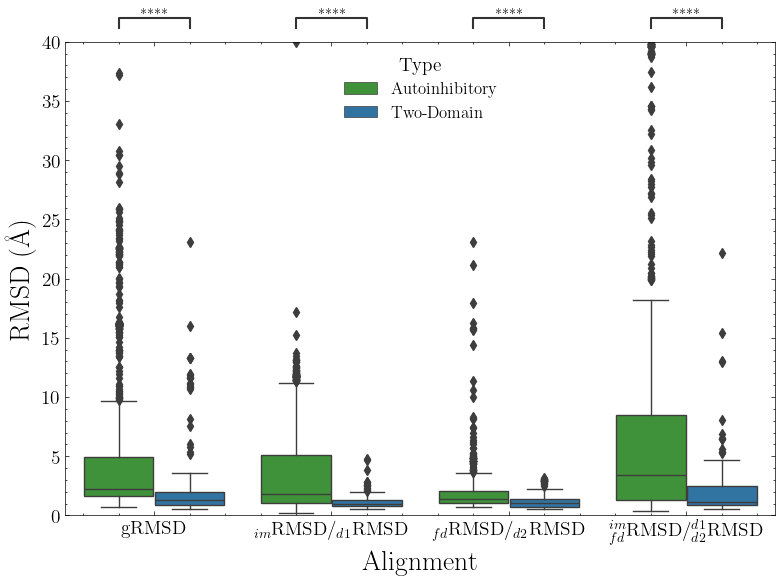

In [252]:
# # Now we plot the data
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.boxplot(data=allPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
# ax.set_ylim(0, 40)
# ax.set_ylabel('RMSD (Å)', fontsize=20)
# ax.set_xlabel('Alignment', fontsize=20)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
# ax.legend(title='Type', fontsize=12, title_fontsize=14)

# # Add the annotations, comparing between structural alignment categories
# pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
#          [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
#          [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
#          [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
# subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]
# annotator = Annotator(ax, pairs, data=allPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
# annotator.apply_and_annotate()

# # Save the plot
# plt.tight_layout()
# plt.savefig('./project_pipeline/data/figures/paper/ai_md_all_rmsd_distributions.png', dpi=500, bbox_inches='tight')

The above plot was for all of our experimental structures. How about only the best ones for each protein?

In [253]:
min_cl = clSub.groupby('UniProt')['gRMSD'].min()
minimum_cl = pd.merge(min_cl, clSub, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

min_md = mdSub.groupby('UniProt')['gRMSD'].min()
minimum_md = pd.merge(min_md, mdSub, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

In [254]:
minimum_cl[minimum_cl['gRMSD'] < 3].shape

(75, 7)

In [255]:
minimum_cl.describe()

,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
count,128.000000,128.000000,128.000000,128.000000
mean,6.557945,2.900789,2.294359,13.093375
std,12.142941,4.258162,2.275397,26.957151
min,0.712000,0.344000,0.683000,0.742000
25%,1.552750,1.121000,1.140500,1.429000
50%,2.426500,1.635000,1.685000,3.310500
75%,6.725500,3.072000,2.390250,12.173750
max,113.774000,40.009000,17.946000,220.629000


In [256]:
# Turn it into plotting form
minPlot = pd.concat([minimum_cl, minimum_md])

# Melt the data
minPlot = pd.melt(minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
minPlot['RMSD'] = minPlot['RMSD'].astype(float)

/tmp/ipykernel_2466124/2276745409.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.644e-07 U_stat=3.914e+03
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.596e-05 U_stat=3.690e+03
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.477e-08 U_stat=4.082e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.381e-03 U_stat=3.348e+03


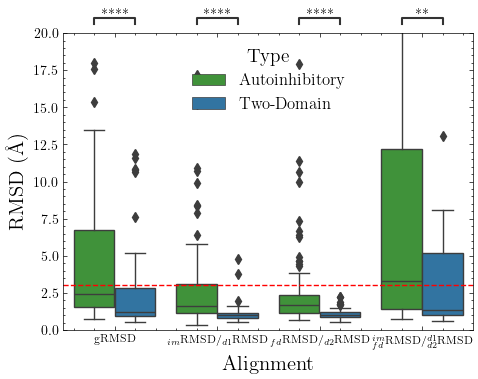

In [2060]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=minPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 20)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=minPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/ai_md_best_rmsd_distributions.png', dpi=1200, bbox_inches='tight')

In [258]:
minPlot.groupby('Type')['PDB'].nunique()

Type
Autoinhibitory    128
Two-Domain         40
Name: PDB, dtype: int64

Real quick make a graph showing the correlation between imfdRMSD & the domains.

In [259]:
# Pivot the data back to the original form
pivoted = minPlot.pivot(index=['UniProt', 'PDB', 'Type'], columns='Alignment', values='RMSD').reset_index()
ai_only = pivoted[pivoted['Type'] == 'Autoinhibitory']
md_only = pivoted[pivoted['Type'] == 'Two-Domain']

In [260]:
ai_matrix = ai_only[['gRMSD', imd1, fdd2, imfdd1d2]].corr()
ai_matrix

Alignment,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
Alignment,,,,
gRMSD,1.000000,0.355732,0.316230,0.938790
$_{im}$RMSD/$_{d1}$RMSD,0.355732,1.000000,0.268982,0.417048
$_{fd}$RMSD/$_{d2}$RMSD,0.316230,0.268982,1.000000,0.243025
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,0.938790,0.417048,0.243025,1.000000


We look at only those proteins with structured inhibitory modules. 

In [261]:
dis = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t')

dis = dis[['uniprot', 'r1_mean_plddt', 'mean_pae_1_1', 'ar_disorder', 'percent_disorder_1']].drop_duplicates()

dis_uniprots = dis[dis['ar_disorder'] == 'structured']['uniprot'].unique()
len(dis_uniprots)

dis_cl = minimum_cl[minimum_cl['UniProt'].isin(dis_uniprots)]

dis_minPlot = pd.concat([dis_cl, minimum_md])

# Melt the data
dis_minPlot = pd.melt(dis_minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
dis_minPlot['RMSD'] = dis_minPlot['RMSD'].astype(float)

In [262]:
dis_minPlot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    105
Two-Domain         40
Name: UniProt, dtype: int64

/tmp/ipykernel_2466124/1457189136.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.021e-05 U_stat=3.098e+03
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.460e-04 U_stat=2.959e+03
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.027e-07 U_stat=3.304e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.443e-02 U_stat=2.654e+03


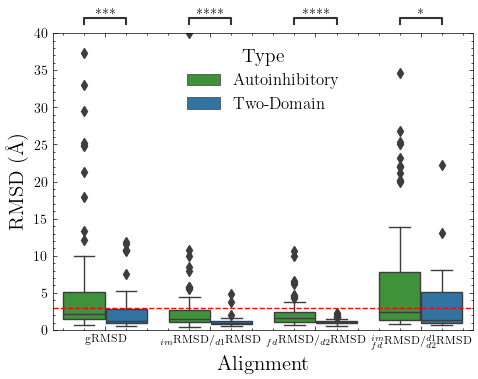

In [1190]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=dis_minPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=dis_minPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/structured_im_only_rmsd.png', dpi=1200, bbox_inches='tight')

And now only those autoinhibitory proteins without extra annotated domains in UniProt (i.e. domains that fall outside of the IM or FD)

In [687]:
extra = pd.read_csv('./project_pipeline/data/extra_domains.csv')
no_extra_prots = extra[extra['has_extra'] == False]['uniprot'].unique().tolist()

no_extra_cl = minimum_cl[minimum_cl['UniProt'].isin(no_extra_prots)]

no_extra_clPlot = pd.concat([no_extra_cl, minimum_md])

# Melt the data
no_extra_clPlot = pd.melt(no_extra_clPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
no_extra_clPlot['RMSD'] = no_extra_clPlot['RMSD'].astype(float)

/tmp/ipykernel_2466124/2027431306.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_Autoinhibitory vs. $_{im}$RMSD/$_{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.770e-05 U_stat=2.036e+03
gRMSD_Autoinhibitory vs. gRMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.812e-04 U_stat=1.976e+03
$_{fd}$RMSD/$_{d2}$RMSD_Autoinhibitory vs. $_{fd}$RMSD/$_{d2}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:5.573e-08 U_stat=2.244e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Autoinhibitory vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.583e-02 U_stat=1.735e+03


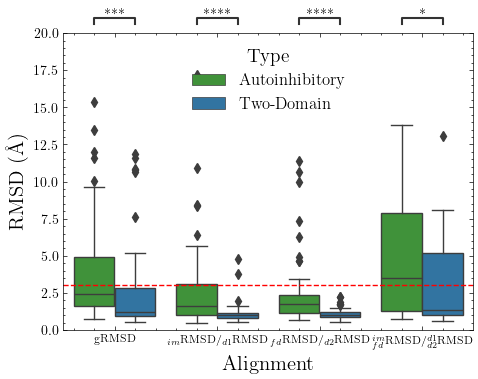

In [688]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=no_extra_clPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylim(0, 20)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Autoinhibitory'), ('gRMSD', 'Two-Domain')],
         [(imd1, 'Autoinhibitory'), (imd1, 'Two-Domain')],
         [(fdd2, 'Autoinhibitory'), (fdd2, 'Two-Domain')],
         [(imfdd1d2, 'Autoinhibitory'), (imfdd1d2, 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=no_extra_clPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/ai_md_no_extra_domains_rmsds.png', dpi=1200, bbox_inches='tight')

How about only obligate two-domain proteins?

In [1706]:
obli_uniprots = obli['uniprot'].unique()

obli_md = minimum_md[minimum_md['UniProt'].isin(obli_uniprots)]
obli_md['Type'] = 'Obligate'

minimum_af2 = minimum_cl.copy()
minimum_af2['Type'] = 'AI (AF2)'

obli_minPlot = pd.concat([minimum_af2, obli_md])

# Melt the data
obli_minPlot = pd.melt(obli_minPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
obli_minPlot['RMSD'] = obli_minPlot['RMSD'].astype(float)

/tmp/ipykernel_2466124/1954088604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obli_md['Type'] = 'Obligate'


Next we show this for only those proteins with two distinct conformations.

In [269]:
# Find the max and min $_{im}$RMSDAE per protein and create a new dataframe with the difference between those two values
df_max = clSub.groupby('UniProt')[imfdd1d2].max().reset_index()
df_min = clSub.groupby('UniProt')[imfdd1d2].min().reset_index().drop_duplicates(keep='first')
df_diff = pd.merge(df_max, df_min, on='UniProt')
df_diff['diff'] = df_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x'] - df_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y']
df_diff = df_diff.sort_values('diff', ascending=False)
df_diff.head()

,UniProt,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y,diff
107,Q96P20,80.422,6.447,73.975
62,Q00944,71.123,1.906,69.217
66,Q06124,58.638,0.770,57.868
35,P29350,57.427,1.765,55.662
5,O08967,54.034,1.593,52.441


In [270]:
# What are the state and conformation annotations for these proteins?
df_smol = df_diff[['UniProt', 'diff']]
df_max = pd.merge(clSub, df_max, on=['UniProt', imfdd1d2])
df_min = pd.merge(clSub, df_min, on=['UniProt', imfdd1d2])
bounds = pd.concat([df_max, df_min])
df = pd.merge(clSub, df_smol, on='UniProt')
g3 = pd.merge(bounds, df_smol, on='UniProt')

g3 = g3[g3['diff'] > 3]

In [271]:
g3['UniProt'].nunique()

29

In [272]:
# Take the best structure for each protein, based on $_{im}$RMSDAE
min_g3 = g3.groupby('UniProt')[imfdd1d2].min().reset_index()
min_g3 = pd.merge(min_g3, g3, on=['UniProt', imfdd1d2], how='inner').drop_duplicates(subset='UniProt')

In [273]:
rand = min_g3.rename(columns={'UniProt': 'uniprot', 'PDB': 'pdb'})
min_state = pd.merge(rand, cl, on=['uniprot', 'pdb'], how='inner')
min_state['state'].value_counts()

Active           14
Autoinhibited    10
Name: state, dtype: int64

In [274]:
match = min_state[min_state['gRMSD'] <= 3]
non_match = min_state[min_state['gRMSD'] > 3]

match['state'].value_counts()

Active           9
Autoinhibited    5
Name: state, dtype: int64

In [275]:
non_match['state'].value_counts()

Autoinhibited    5
Active           5
Name: state, dtype: int64

Repeat for multi-domain proteins

In [276]:
md_max = mdSub.groupby('UniProt')[imfdd1d2].max().reset_index()
md_min = mdSub.groupby('UniProt')[imfdd1d2].min().reset_index().drop_duplicates(keep='first')
md_diff = pd.merge(md_max, md_min, on='UniProt')
md_diff['diff'] = md_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_x'] - md_diff['$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_y']
md_diff = md_diff.sort_values('diff', ascending=False)
md_diff.head()

# What are the state and conformation annotations for these proteins?
md_smol = md_diff[['UniProt', 'diff']]
md_max = pd.merge(mdSub, md_max, on=['UniProt', imfdd1d2])
md_min = pd.merge(mdSub, md_min, on=['UniProt', imfdd1d2])
md_bounds = pd.concat([md_max, md_min])
md = pd.merge(mdSub, md_smol, on='UniProt')
md_g3 = pd.merge(md_bounds, md_smol, on='UniProt')

md_g3 = md_g3[md_g3['diff'] > 3]

In [277]:
# Take the best structure for each protein, based on $_{im}$RMSDAE
min_md_g3 = md_g3.groupby('UniProt')[imfdd1d2].min().reset_index()
min_md_g3 = pd.merge(min_md_g3, md_g3, on=['UniProt', imfdd1d2], how='inner').drop_duplicates(subset='UniProt')

In [278]:
min_md_g3['UniProt'].nunique()

6

In [279]:
ming3plot = pd.concat([min_g3, minimum_md]) # Minimum md if you want all 40 proteins
ming3plot = pd.melt(ming3plot, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
ming3plot['RMSD'] = ming3plot['RMSD'].astype(float)

Just to be safe, I'll make a graph showing two-domain proteins with at least two structures

In [280]:
ming3plot2 = pd.concat([min_g3, min_md_g3]) # Minimum md if you want all 40 proteins
ming3plot2 = pd.melt(ming3plot2, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
ming3plot2['RMSD'] = ming3plot2['RMSD'].astype(float)

In [281]:
ming3plot.groupby('Type')['UniProt'].nunique()

Type
Autoinhibitory    29
Two-Domain        40
Name: UniProt, dtype: int64

Let's directly compare the minimums of single-conformation proteins against the minimums of the multi-conformation ones.

In [282]:
min_g3['Type'] = 'Multi-Conformation'
ming3uniprots = min_g3['UniProt'].unique().tolist()

min_ss = minimum_cl[~minimum_cl['UniProt'].isin(ming3uniprots)]
min_ss['Type'] = 'Single Conformation'

ai_only = pd.concat([min_g3, min_ss])
ai_only.head()

/tmp/ipykernel_2466124/239083974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_ss['Type'] = 'Single Conformation'


,UniProt,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,PDB,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,Type,diff
0,A0A0R4I961,1.135,6gtv,1.450,0.929,1.673,Multi-Conformation,3.163
1,O00571,1.984,7liu,2.074,1.660,2.105,Multi-Conformation,11.709
2,O08967,1.593,2r09,3.179,1.235,0.968,Multi-Conformation,52.441
3,P00579,45.352,4llg,13.459,2.344,1.750,Multi-Conformation,6.411
4,P07038,12.107,7nxf,4.914,5.410,1.812,Multi-Conformation,10.708


In [283]:
ai_only.columns = ['UniProt', imfd, 'PDB', 'gRMSD', im, fd, 'Type', 'diff']

In [284]:
aiPlot = pd.melt(ai_only, id_vars=['UniProt', 'PDB', 'Type', 'diff'], var_name='Alignment', value_name='RMSD')
aiPlot['RMSD'] = aiPlot['RMSD'].astype(float)

/tmp/ipykernel_2466124/2550473023.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_Multi-Conformation vs. $_{im}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:7.716e-01 U_stat=1.384e+03
gRMSD_Multi-Conformation vs. gRMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:3.491e-01 U_stat=1.270e+03
$_{fd}$RMSD_Multi-Conformation vs. $_{fd}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:2.084e-01 U_stat=1.214e+03
$_{fd}^{im}$RMSD_Multi-Conformation vs. $_{fd}^{im}$RMSD_Single Conformation: Mann-Whitney-Wilcoxon test two-sided, P_val:7.803e-01 U_stat=1.386e+03


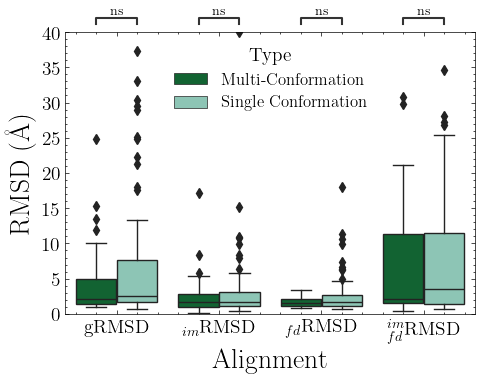

In [1192]:
subcat_order = ['gRMSD', im, fd, imfd]

# Now we plot the data
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=aiPlot, x='Alignment', y='RMSD', ax=ax, palette=gns, hue='Type', order=subcat_order)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Single Conformation'), ('gRMSD', 'Multi-Conformation')],
         [(im, 'Single Conformation'), (im, 'Multi-Conformation')],
         [(fd, 'Single Conformation'), (fd, 'Multi-Conformation')],
         [(imfd, 'Single Conformation'), (imfd, 'Multi-Conformation')]]
annotator = Annotator(ax, pairs, data=aiPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/ai_single_vs_multi_structures.png', dpi=500, bbox_inches='tight')

## Now we do the PAE

In [286]:
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')

In [287]:
# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)

df_single = df_single[['uniprot', 'mean_pae']].dropna()

In [288]:
# Reformat the singles dataframe
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_auto = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_auto = df_auto[df_auto['uniprot'].isin(minimum_cl['UniProt'].unique())]
df_pae = df_auto.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 'mean_pae_2_2': 'FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 vs D2', 'mean_pae_2_2': 'D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
# df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all = pd.concat([df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

/tmp/ipykernel_2466124/1602048795.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_Two-Domain vs. IM vs FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.159e-05 U_stat=2.406e+03
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.737e-05 U_stat=2.386e+03
D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.142e-14 U_stat=1.140e+03


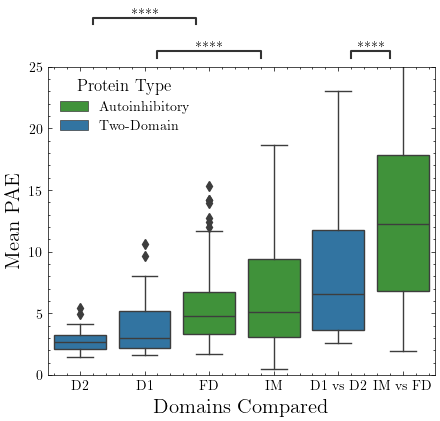

In [289]:
region_order = ['D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

f, ax = plt.subplots(figsize=(5, 4))
ax.set_ylim(0, 25
            )
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10') 

# Annotate statistical significance

pairs = [[('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/ai_md_proteins_pae_annotated.png', bbox_inches='tight', dpi=1200)

In [290]:
df_auto['uniprot'].nunique()

128

In [291]:
df_dis_melt = df_pae_melt[df_pae_melt['uniprot'].isin(dis_uniprots)]

df_dis_all = pd.concat([df_single_melt, df_dis_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_dis_all['mean_pae'] = df_dis_all['mean_pae'].astype('float')

In [292]:
df_dis_all.groupby('type')['uniprot'].nunique()

type
Autoinhibitory    105
Single Domain     258
Two-Domain         61
Name: uniprot, dtype: int64

In [293]:
# region_order = ['Single Domain', 'D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

# f, ax = plt.subplots(figsize=(9, 5))
# sns.boxplot(data=df_dis_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
# ax.set_xlabel('Domains Compared', fontsize=20)
# ax.set_ylabel('Mean PAE', fontsize=20)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
# ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# # Annotate statistical significance

# pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
#          [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
#          [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
#          [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
#          [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
#          [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Two-Domain')]]
# annotator = Annotator(ax, pairs, data=df_dis_all, x='region', y='mean_pae', order=region_order, hue='type')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
# _, corrected_results = annotator.apply_and_annotate()

# # Save the figure
# plt.savefig('./project_pipeline/data/figures/paper/structured_im_only_pae.png')

For only those proteins with ordered inhibitory modules.

In [294]:
# Add obligate column
obligate_uniprots = obli['uniprot'].unique().tolist()

df_obli_melt = df_multi_melt[df_multi_melt['uniprot'].isin(obligate_uniprots)]
df_obli_melt['type'] = 'Obligate'

df_all_plus_obli = pd.concat([df_all, df_obli_melt], ignore_index=True).drop_duplicates()

/tmp/ipykernel_2466124/3584162902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obli_melt['type'] = 'Obligate'


In [295]:
df_all_plus_obli = df_all_plus_obli[df_all_plus_obli['type'] != 'Two-Domain']
df_all_plus_obli['mean_pae'] = df_all_plus_obli['mean_pae'].astype('float')

In [296]:
df_all_plus_obli.groupby('type')['uniprot'].nunique()

type
Autoinhibitory    128
Obligate            7
Name: uniprot, dtype: int64

In [297]:
# region_order = ['Single Domain', 'D2', 'D1', 'FD', 'IM', 'D1 vs D2', 'IM vs FD']

# f, ax = plt.subplots(figsize=(7, 4))
# sns.boxplot(data=df_all_plus_obli, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
# ax.set_xlabel('Domains Compared', fontsize=14)
# ax.set_ylabel('Mean PAE', fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
# ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# # Annotate statistical significance

# pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
#          [('Single Domain', 'Single Domain'), ('D2', 'Obligate')],
#          [('Single Domain', 'Single Domain'), ('D1', 'Obligate')],
#          [('FD', 'Autoinhibitory'), ('D2', 'Obligate')],
#          [('IM', 'Autoinhibitory'), ('D1', 'Obligate')],
#          [('IM vs FD', 'Autoinhibitory'), ('D1 vs D2', 'Obligate')]]
# annotator = Annotator(ax, pairs, data=df_all_plus_obli, x='region', y='mean_pae', order=region_order, hue='type')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
# _, corrected_results = annotator.apply_and_annotate()

# # Save the figure
# plt.savefig('./project_pipeline/data/figures/ai_sd_obli_proteins_pae_annotated.png')

## Full-Depth pLDDT

In [1756]:
# Functions to rename columns

def rename_auto_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Global AI', 'r1_mean_plddt': 'IM', 'r2_mean_plddt': 'FD'})

    return df

def rename_multi_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Global TD', 'r1_mean_plddt': 'D1', 'r2_mean_plddt': 'D2'})

    return df

# Quick functions to melt dataframes
def pivot_af_df(df):

    df = df.melt(id_vars=['uniprot', 'region_1', 'region_2', 'af_filename'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

def pivot_cf_df(df):

    df = df.melt(id_vars=['uniprot', 'cluster', 'region_1', 'region_2'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

# Add signifier column
def add_auto_type(df):
    df['type'] = 'Autoinhibitory (AF2)'

    return df

def add_multi_type(df):
    df['type'] = 'Two-Domain (AF2)'

    return df

In [1749]:
afAuto = pd.read_csv('./project_pipeline/data/ai_full-depth_pLDDT.tsv', sep='\t').astype('object')
afMulti = pd.read_csv('./project_pipeline/data/md_full-depth_pLDDT.tsv', sep='\t').astype('object')

In [1750]:
afAuto = afAuto[['uniprot', 'region_1', 'region_2', 'af_filename', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']].drop_duplicates()
afMulti = afMulti[['uniprot', 'region_1', 'region_2', 'af_filename', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']].drop_duplicates()

In [1751]:
afAuto['uniprot'].nunique()

128

In [1752]:
afAuto = afAuto.drop_duplicates()
afAuto['r1_mean_plddt'].astype('float').describe()

count    128.000000
mean      81.248320
std       13.239812
min       37.542000
25%       74.893250
50%       84.223500
75%       91.533250
max       98.189000
Name: r1_mean_plddt, dtype: float64

In [1757]:
# Rename columns
af_auto = rename_auto_columns(afAuto)
af_multi = rename_multi_columns(afMulti)

# Pivot dataframes
afAuto_p = pivot_af_df(af_auto)
afMulti_p = pivot_af_df(af_multi)

# Add type column
afAuto_p = add_auto_type(afAuto_p)
afMulti_p = add_multi_type(afMulti_p)

# Concatenate dataframes
af = pd.concat([afAuto_p, afMulti_p]).drop_duplicates()

In [1754]:
af['uniprot'].nunique()

168

/tmp/ipykernel_2466124/1215475420.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory (AF2) vs. Global TD_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:5.945e-16 U_stat=3.870e+02
IM_Autoinhibitory (AF2) vs. D1_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.309e-13 U_stat=5.710e+02
FD_Autoinhibitory (AF2) vs. D2_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.574e-05 U_stat=1.400e+03


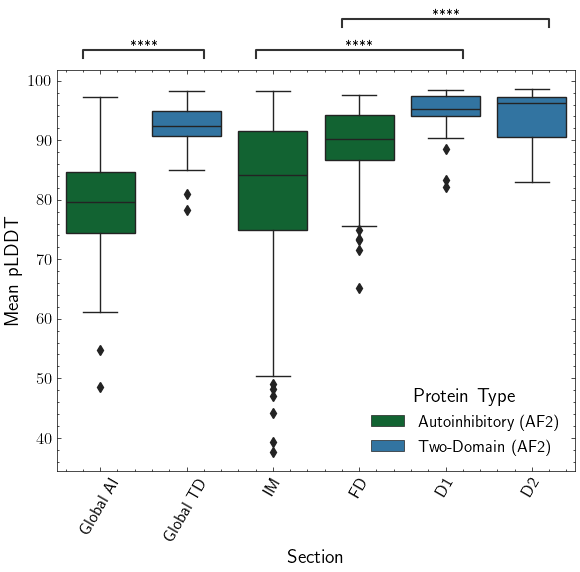

In [2912]:
plot_plddt(af, 'Autoinhibitory (AF2)', 'Two-Domain (AF2)', colors3)
# subcat_order = ['Global AI', 'Global TD', 'IM', 'FD', 'D1', 'D2']

# fig, ax = plt.subplots(figsize=(6, 6))
# sns.boxplot(data=af, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order, dodge=False)
# ax.set_ylabel('Mean pLDDT', fontsize=14)
# ax.set_xlabel('Section', fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
# ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')


# # Annotate statistical significance
# pairs = [[('Global AI', 'Autoinhibitory'), ('Global TD', 'Two-Domain')],
#          [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
#          [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')]]

# type_order = ['Autoinhibitory', 'Two-Domain']
# annotator = Annotator(ax, pairs, data=af, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
# annotator.apply_and_annotate()

# plt.xticks(rotation=60)
# # Save the figure
# plt.style.use('science')
# plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/ai_md_full_depth_plddt.png', dpi=500, bbox_inches='tight')

pLDDT for only structured inhibitory modules now.

In [1770]:
dis_Autop = afAuto_p[afAuto_p['uniprot'].isin(dis_uniprots)]

dis_af = pd.concat([dis_Autop, afMulti_p]).drop_duplicates()

In [1771]:
dis_af.head()

,uniprot,region_1,region_2,af_filename,Section,Mean pLDDT,type
4,P60240,1-110,"147-416,441-659",F-P60240-F1-model_v3.cif,Global AI,87.890,Autoinhibitory (AF2)
5,P14633,26-100,185-404,F-P14633-F1-model_v3.cif,Global AI,90.694,Autoinhibitory (AF2)
6,A0A0R4I961,155-279,3-147,F-A0A0R4I961-F1-model_v3.cif,Global AI,97.231,Autoinhibitory (AF2)
7,P00523,"148-245,246-266","81-142,521-533",F-P00523-F1-model_v3.cif,Global AI,84.200,Autoinhibitory (AF2)
8,Q00944,35-362,422-680,F-Q00944-F1-model_v3.cif,Global AI,74.869,Autoinhibitory (AF2)


/tmp/ipykernel_2466124/1215475420.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory (AF2) vs. Global TD_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:6.129e-15 U_stat=3.360e+02
IM_Autoinhibitory (AF2) vs. D1_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.857e-12 U_stat=5.070e+02
FD_Autoinhibitory (AF2) vs. D2_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.771e-05 U_stat=1.152e+03


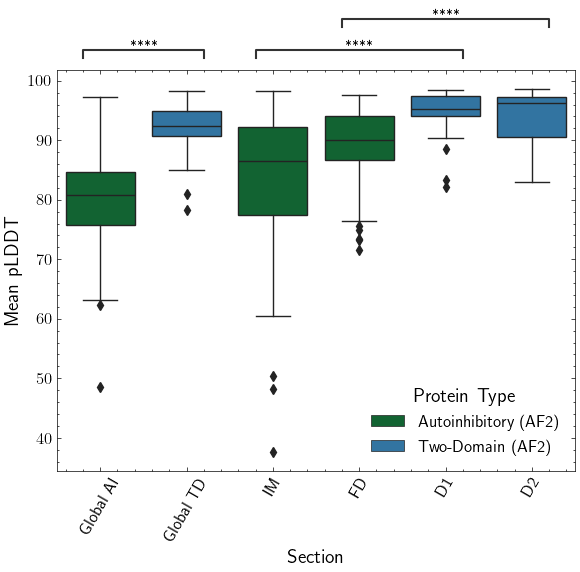

In [2917]:
plot_plddt(dis_af, 'Autoinhibitory (AF2)', 'Two-Domain (AF2)', colors3)
plt.savefig('./project_pipeline/data/figures/paper/structured_im_only_plddt.png', dpi=500, bbox_inches='tight')

## DockQ

In [1674]:
ai1 = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv').astype('object')
md_dockq = pd.read_csv('./project_pipeline/data/md_pdb_full_depth_dockq.csv').astype('object')
af3_dockq = pd.read_csv('./project_pipeline/data/jp_data/result_dockq.csv').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})

af3_all = pd.read_csv('./project_pipeline/data/jp_data/rmsds_all_af3_best.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
af3_min = af3_all.sort_values('gRMSD').groupby('UniProt').first().reset_index()

ai1 = ai1.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
md_dockq = md_dockq.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
af3_dockq['UniProt'] = af3_dockq['UniProt'].apply(lambda x: x.upper())

In [2587]:
ai1['UniProt'].nunique()

121

In [2687]:
g3dockq = pd.merge(minimum_cl, ai1, on=['UniProt', 'PDB'], how='left')
g3dockq['capri'] = g3dockq['capri'].fillna('Incorrect')
mddockq = pd.merge(md_dockq, minimum_md, on=['UniProt', 'PDB'], how='inner').fillna(0)
af3dockq = pd.merge(af3_min, af3_dockq, on=['UniProt', 'PDB'], how='left').fillna(0).drop_duplicates(subset='UniProt')
af3dockq = af3dockq[af3dockq['capri'] != 0]

obli_dockq = mddockq[mddockq['UniProt'].isin(obli_uniprots)].reset_index(drop=True)

g3dockq['Type'] = 'Autoinhibitory (AF2)'
mddockq['Type'] = 'Two-Domain (AF2)'
obli_dockq['Type'] = 'Obligate (AF2)'
af3dockq['Type'] = 'Autoinhibitory (AF3)'

In [2688]:
plot = pd.concat([g3dockq, af3dockq, mddockq], ignore_index=True)

plot_dockq = pd.concat([g3dockq, af3dockq, obli_dockq])

/tmp/ipykernel_2466124/3827050862.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


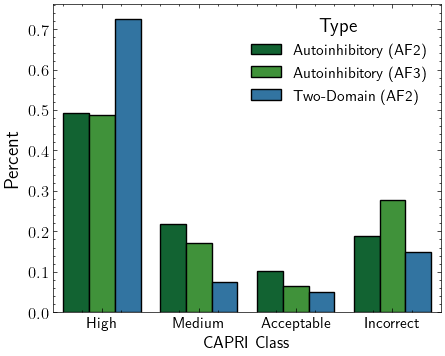

In [2849]:
# We want percentages of CAPRI Classes
perc = plot.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc

# Make the CAPRI Class categorical
perc['capri'] = pd.Categorical(perc['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(5, 4))

sns.barplot(data=perc, x='capri', y='Percent', hue='Type', palette=colors3, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=12)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize=14, fontsize=11)

plt.savefig('./project_pipeline/data/figures/paper/dockq_histograms.png', bbox_inches='tight', dpi=300)

/tmp/ipykernel_2466124/2336576914.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


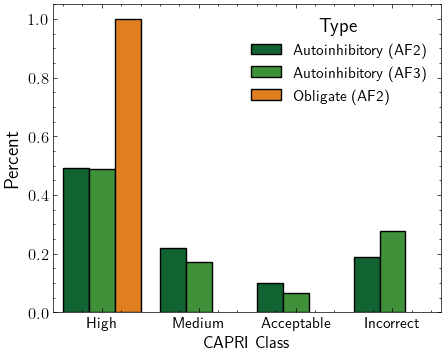

In [2894]:
# We want percentages of CAPRI Classes
perc2 = plot_dockq.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc2

# Make the CAPRI Class categorical
perc2['capri'] = pd.Categorical(perc2['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(5, 4))

sns.barplot(data=perc2, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=12)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize=14, fontsize=11, loc='upper right')

plt.savefig('./project_pipeline/data/figures/paper/dockq_obli.png', bbox_inches='tight', dpi=500)

## Looking at Proteins with Structures in the Training Set and Outside of the Training Set

In [322]:
# Get the dates data
ai_dates = pd.read_csv('./project_pipeline/data/ai_dates.tsv', sep='\t')
md_dates = pd.read_csv('./project_pipeline/data/md_dates.tsv', sep='\t')

# Get interpro data
interpro = pd.read_csv('./project_pipeline/data/interpro.tsv', sep='\t')

# Convert the dates to datetime objects
ai_dates['date'] = pd.to_datetime(ai_dates['date'])
md_dates['date'] = pd.to_datetime(md_dates['date'])

In [323]:
# The maximum release date for AlphaFold2 was April 30, 2018. Select only those structures released after this date
ai_after = ai_dates[ai_dates['date'] > datetime.datetime(2018, 4, 30)]
md_after = md_dates[md_dates['date'] > datetime.datetime(2018, 4, 30)]

ai_before = ai_dates[ai_dates['date'] <= datetime.datetime(2018, 4, 30)]
md_before = md_dates[md_dates['date'] <= datetime.datetime(2018, 4, 30)]

In [324]:
# Let's find the proteins with structures both before and after the release date
ai_before_uniprots = ai_before['uniprot'].unique().tolist()
ai_after_uniprots = ai_after['uniprot'].unique().tolist()

md_before_uniprots = md_before['uniprot'].unique().tolist()
md_after_uniprots = md_after['uniprot'].unique().tolist()

ai_only_after = list(set(ai_after_uniprots).difference(set(ai_before_uniprots)))
md_only_after = list(set(md_after_uniprots).difference(set(md_before_uniprots)))

print(len(ai_only_after), len(md_only_after))

30 8


In [325]:
multi_conf_ai_after = min_g3[min_g3['UniProt'].isin(ai_only_after)]
best_md_after = minimum_md[minimum_md['UniProt'].isin(md_only_after)].reset_index(drop=True)
best_ai_after = minimum_cl[minimum_cl['UniProt'].isin(ai_only_after)]

In [326]:
# Add gene names
gene_names = pd.read_csv('./source_protein_lists/Autoinhibited proteins (more added by Brooks).csv')
gene_names.head()

/tmp/ipykernel_2466124/1606980015.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_names = pd.read_csv('./source_protein_lists/Autoinhibited proteins (more added by Brooks).csv')


,Protein name,Gene names,Protein length,Uniprot ID,Species,Autoinhibitory regions,References,Description (Refer to H and I),Evidence,Structure?,...,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,ALK tyrosine kinase receptor (EC 2.7.10.1) (An...,ALK,1620.0,Q9UM73,Homo sapiens (Human),1096-1103(β1'-sheet and β2'-sheet);1271-1277(α...,20695522,ALK is a receptor tyrosine kinase involved in ...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BH3-interacting domain death agonist (p22 BID)...,BID,195.0,P55957,Homo sapiens (Human),14-41(N-terminal autoinhibitory region),10089877,BID is a proapoptotic member of the BCL2 famil...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tyrosine-protein kinase Blk (EC 2.7.10.2) (B l...,BLK,505.0,P51451,Homo sapiens (Human),58-118(SH3 domain);221-240(SH2-CD linker);376-...,15489910,Tyrosine-protein kinase Blk plays an important...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Calcium/calmodulin-dependent protein kinase ty...,CAMK2B CAM2 CAMK2 CAMKB,666.0,Q13554,Homo sapiens (Human),283-292(Autoinhibitory domain),20668654,CAMK2B is a Calcium/Calmodulin (CaM)-dependent...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Calcium/calmodulin-dependent protein kinase ty...,CAMK2D CAMKD,499.0,Q13557,Homo sapiens (Human),283-292(Autoinhibitory domain),20668654,CAMK2D is a Calcium/Calmodulin (CaM)-dependent...,Inferred by structure analysis without experim...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
interpro = interpro.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})

In [328]:
names_only = gene_names[['Uniprot ID', 'Gene names', 'Protein name']]
best_ai_after_gn = pd.merge(best_ai_after, names_only, left_on='UniProt', right_on='Uniprot ID', how='left')
best_ai_after_gn.columns

Index(['UniProt', 'gRMSD', 'PDB', '$_{im}$RMSD/$_{d1}$RMSD',
       '$_{fd}$RMSD/$_{d2}$RMSD', '$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD', 'Type',
       'Uniprot ID', 'Gene names', 'Protein name'],
      dtype='object')

In [329]:
best_ai_after_gn = pd.merge(best_ai_after_gn, interpro, on=['UniProt', 'PDB'], how='left')
best_ai_after_gn.columns
best_ai_after_gn = best_ai_after_gn.drop(columns=['notes', 'date', 'region_1', 'region_2', 'percent_region_1', 'percent_region_2',
                                                '2_aligned', '2_comp', 'complex_rmsd', 'state', 'conformation', 'organism', 'Uniprot ID', 'Type'])

In [330]:
best_ai_after_gn

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Gene names,Protein name,domain,homologous_superfamily,family,active_site,conserved_site,repeat,binding_site,ptm
0,B5XAZ0,2.591,7bfl,0.656,2.760,0.807,ANG1,Angiogenin-1,Ribonuclease A-domain,Ribonuclease A-like domain superfamily,Pancreatic ribonuclease,"Ribonuclease A, active site",NaN,NaN,NaN,NaN
1,D2AJU0,3.539,6lol,0.945,2.829,7.860,ipaH9.8 SFxv_5076,E3 ubiquitin-protein ligase ipaH9.8 (EC 2.3.2....,"Novel E3 ligase domain, LRR-containing bacteri...",Leucine-rich repeat domain superfamily,NaN,NaN,NaN,NaN,NaN,NaN
2,O95376,1.926,7od1,1.319,1.145,3.092,ARIH2 ARI2 TRIAD1 HT005,E3 ubiquitin-protein ligase ARIH2 (ARI-2) (Pro...,"Zinc finger, RING-type, IBR domain, TRIAD supr...","Zinc finger, RING/FYVE/PHD-type",E3 ubiquitin ligase RBR family,NaN,"Zinc finger, RING-type, conserved site",NaN,NaN,NaN
3,P09769,1.930,7uy0,1.356,1.323,2.425,FGR SRC2,Tyrosine-protein kinase Fgr (EC 2.7.10.2) (Gar...,"Protein kinase domain, SH2 domain, Serine-thre...","Protein kinase-like domain superfamily, SH3-li...",NaN,"Tyrosine-protein kinase, active site",NaN,NaN,"Protein kinase, ATP binding site",NaN
4,Q14674,5.868,7nj0,3.423,4.668,5.274,ESPl1,Separin,SEPARIN core domain,NaN,"Peptidase C50, separase",NaN,NaN,NaN,NaN,NaN
5,Q6SZW1,1.709,7cm6,0.962,1.016,2.948,SARM1,NAD(+) hydrolase SARM1,Toll/interleukin-1 receptor homology (TIR) dom...,"Armadillo-like helical, Sterile alpha motif/po...",Sterile alpha and TIR motif-containing protein 1,NaN,NaN,NaN,NaN,NaN
6,Q86WJ1,24.842,7epu,3.875,6.410,25.112,CHD1L,Chromodomain-helicase-DNA-binding protein 1-like,"SNF2, N-terminal, Helicase, C-terminal, Macro ...",P-loop containing nucleoside triphosphate hydr...,Chromodomain-helicase-DNA-binding protein 1-like,NaN,"DNA/RNA helicase, ATP-dependent, DEAH-box type...",NaN,NaN,NaN
7,Q8R4B8,13.366,7vtq,1.285,6.638,47.240,Nlrp3 Cias1 Mmig1 Nalp3 Pypaf1,"NACHT, LRR and PYD domains-containing protein ...","DAPIN domain, NACHT nucleoside triphosphatase,...","Death-like domain superfamily, P-loop containi...",NaN,NaN,NaN,Leucine-rich repeat,NaN,NaN
8,Q96RD7,11.566,6m02,5.523,11.360,27.251,PANX1 MRS1 UNQ2529/PRO6028,Pannexin-1,NaN,NaN,"Innexin, Pannexin",NaN,NaN,NaN,NaN,NaN
9,Q9NPP4,21.290,8fw2,5.774,2.340,42.119,NLRC4 CARD12 CLAN CLAN1 IPAF UNQ6189/PRO20215,NLR family CARD domain-containing protein 4 (C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
md_gene_names = {'Protein name': ['Putative ATP-dependent b-aminoacyl-ACP synthetase', 'Cfl',
                                  'Fructose-1,6-bisphosphatase 1', '2,3-dihydroxybenzoate-AMP ligase',
                                  '2-methylcitrate dehydratase'],
                 'Gene names': ['hitB', 'Cfl',
                                'FBP1', np.nan,
                                'prpD']}

md_genes_df = pd.DataFrame(md_gene_names)
best_md_after_gn = pd.merge(best_md_after, md_genes_df, how='left', left_index=True, right_index=True)

In [332]:
best_md_after_gn[['UniProt', 'PDB', imfdd1d2, 'gRMSD', 'Gene names', 'Protein name']]

,UniProt,PDB,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,gRMSD,Gene names,Protein name
0,A0A0F7R6G7,6m01,6.903,2.806,hitB,Putative ATP-dependent b-aminoacyl-ACP synthetase
1,M4GWN4,7a9i,13.047,5.219,Cfl,Cfl
2,Q2TU34,5zwk,3.829,2.921,FBP1,"Fructose-1,6-bisphosphatase 1"
3,Q47NR5,6e97,60.475,11.86,NaN,"2,3-dihydroxybenzoate-AMP ligase"
4,Q9I5E6,6s62,8.086,3.348,prpD,2-methylcitrate dehydratase


In [333]:
# Turn it into plotting form
afterPlot = pd.concat([best_md_after, best_ai_after])

# Melt the data
afterPlot = pd.melt(afterPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
afterPlot['RMSD'] = afterPlot['RMSD'].astype(float)

/tmp/ipykernel_2466124/1567931889.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


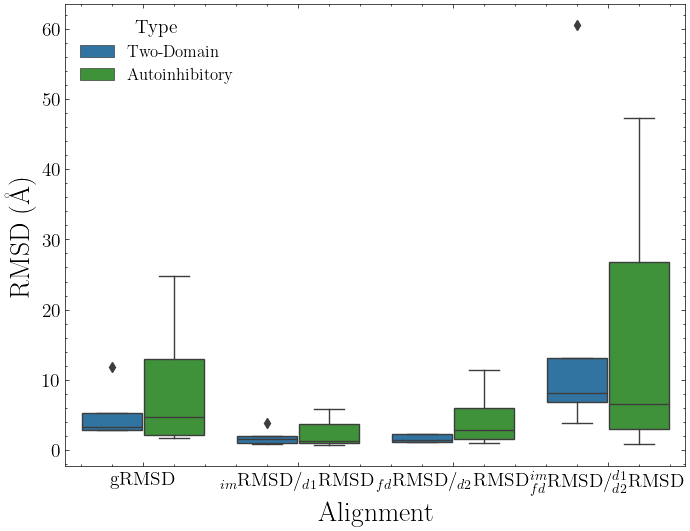

In [334]:
subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=afterPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order)
ax.set_ylabel('RMSD (Å)', fontsize=20)
ax.set_xlabel('Alignment', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.legend(title='Type', fontsize=12, title_fontsize=14)

plt.savefig('./project_pipeline/data/figures/paper/not_in_training_set.png', bbox_inches='tight', dpi=500)

## Comparing minimum of PDB-Cluster vs PDB-Full Depth

In [335]:
clust = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t').astype('object')

In [336]:
# Rename the columns
clust = clust.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster', 'complex_rmsd': 'gRMSD',
                              '1_aligned': im, '2_aligned': fd, '2_comp': imfd})
min_g3 = min_g3.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

clust['Type'] = 'Cluster'
min_g3['Type'] = 'Full Depth'

In [337]:
# Get the minimum for the clusters per protein
min_clust = clust.groupby('UniProt')['gRMSD'].min().reset_index()
min_clust = pd.merge(min_clust, clust, on=['UniProt', 'gRMSD'], how='inner').drop_duplicates(subset='UniProt')

min_clust.shape

(38, 25)

In [338]:
# What about the minimums for every cluster?
min_clust_all = clust.groupby(['UniProt', 'Cluster'])['gRMSD'].min().reset_index()
min_clust_uniform = min_clust_all[min_clust_all['Cluster'].str.contains('U')]
min_clust_uniform.shape

(740, 3)

In [339]:
# Find common uniprots between minimum_cl and min_clust
clust_uniprots = min_clust['UniProt'].unique().tolist()
class_uniprots = min_g3['UniProt'].unique().tolist()
all_class_uniprots = minimum_cl['UniProt'].unique().tolist()

common_uniprots = list(set(clust_uniprots).intersection(all_class_uniprots))

to_plot_clust = min_clust[min_clust['UniProt'].isin(common_uniprots)]
to_plot_class = minimum_cl[minimum_cl['UniProt'].isin(common_uniprots)]

to_plot_clust['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
to_plot_class['Type'] = 'Full Depth'

to_plot_class = to_plot_class.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

to_plot = pd.concat([to_plot_clust, to_plot_class])

to_plot = to_plot[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

/tmp/ipykernel_2466124/973839434.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_class['Type'] = 'Full Depth'


In [340]:
to_plot_class['PDB'].nunique()

38

In [341]:
to_plot_clust[to_plot_clust['gRMSD'] <= 3].shape

(15, 25)

In [342]:
# Melt the data for plotting
to_plot_melt = pd.melt(to_plot, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_melt['RMSD'] = to_plot_melt['RMSD'].astype(float)
to_plot_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),001,gRMSD,1.954
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-009,gRMSD,5.493
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-000,gRMSD,19.891
4,O76074,3mf0,AI Cluster (w/ Uniform Clstrs.),U100-001,gRMSD,7.514


In [343]:
to_plot_melt['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    152
Full Depth                         152
Name: Type, dtype: int64

/tmp/ipykernel_2466124/4267276094.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.226e-02 U_stat=9.180e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:9.138e-02 U_stat=8.850e+02
$_{fd}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.247e-02 U_stat=9.630e+02
$_{fd}^{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.532e-01 U_stat=8.600e+02


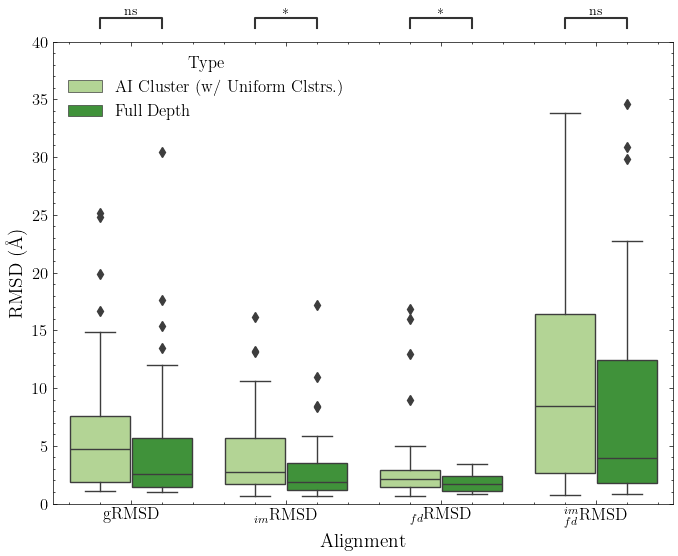

In [344]:
# Change the palette for just this plot
clust_colors = {'Full Depth': pal[3], 'AI Cluster (w/ Uniform Clstrs.)': pal[2]}

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=to_plot_melt, x='Alignment', y='RMSD', ax=ax, palette=clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/ai_all_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

Look at only non-uniform clusters.

In [345]:
no_u = clust[~clust['Cluster'].str.contains('U')].reset_index(drop=True)

no_u['Type'] = 'AI Cluster (w/o Uniform Clstrs.)'

min_nou = no_u.groupby('UniProt')[imfd].min()
min_nou = pd.merge(min_nou, no_u, on=['UniProt', imfd], how='inner').drop_duplicates(subset='UniProt')

In [346]:
no_uniprots = min_nou['UniProt'].unique().tolist()

common_uniprots2 = list(set(no_uniprots).intersection(all_class_uniprots))

to_plot_nou = min_nou[min_nou['UniProt'].isin(common_uniprots2)]

to_plot2 = pd.concat([to_plot_nou, to_plot_class])

to_plot2 = to_plot2[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

In [347]:
to_plot_nou.shape

(34, 25)

In [348]:
to_plot_class[['gRMSD', im, fd, imfd]].astype(float).describe()

,gRMSD,$_{im}$RMSD,$_{fd}$RMSD,$_{fd}^{im}$RMSD
count,38.000000,38.000000,38.000000,38.000000
mean,5.033947,3.117947,1.753079,10.559132
std,6.029770,3.298293,0.705497,14.764120
min,1.031000,0.656000,0.798000,0.807000
25%,1.445500,1.192750,1.106250,1.762750
50%,2.540000,1.889000,1.710500,3.926500
75%,5.687250,3.491250,2.353750,12.398750
max,30.431000,17.161000,3.446000,70.729000


In [349]:
# Melt the data for plotting
to_plot_melt2 = pd.melt(to_plot2, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_melt2['RMSD'] = to_plot_melt2['RMSD'].astype(float)
to_plot_melt2.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfk,AI Cluster (w/o Uniform Clstrs.),013,gRMSD,3.197
1,D2AJU0,6lol,AI Cluster (w/o Uniform Clstrs.),001,gRMSD,5.594
2,O08967,2r0d,AI Cluster (w/o Uniform Clstrs.),005,gRMSD,15.676
3,O60741,6uqg,AI Cluster (w/o Uniform Clstrs.),000,gRMSD,23.507
4,O76074,3mf0,AI Cluster (w/o Uniform Clstrs.),005,gRMSD,8.746


In [350]:
to_plot_melt2['Type'].value_counts()

Full Depth                          152
AI Cluster (w/o Uniform Clstrs.)    136
Name: Type, dtype: int64

/tmp/ipykernel_2466124/3223961030.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.903e-03 U_stat=8.860e+02
gRMSD_AI Cluster (w/o Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.473e-04 U_stat=9.830e+02
$_{fd}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.528e-07 U_stat=1.098e+03
$_{fd}^{im}$RMSD_AI Cluster (w/o Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.063e-02 U_stat=8.280e+02


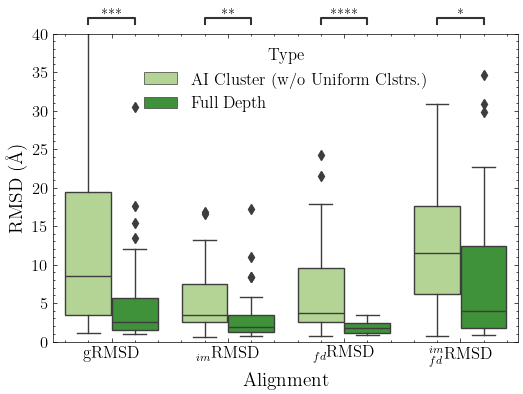

In [351]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=to_plot_melt2, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/o Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/o Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/o Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/o Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_melt2, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/ai_fd_vs_no_u_clust.png', dpi=500, bbox_inches='tight')

Now look at only structures with at least two conformations.

In [352]:
common_uniprots_ai = list(set(clust_uniprots).intersection(class_uniprots))

to_plot_clust2 = min_clust[min_clust['UniProt'].isin(common_uniprots_ai)]
to_plot_class2 = minimum_cl[minimum_cl['UniProt'].isin(common_uniprots_ai)]

to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
to_plot_class2['Type'] = 'Full Depth'

to_plot_class2 = to_plot_class2.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

to_plot_two_confs = pd.concat([to_plot_clust2, to_plot_class2])

to_plot_two_confs = to_plot_two_confs[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

/tmp/ipykernel_2466124/2963792978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
/tmp/ipykernel_2466124/2963792978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_class2['Type'] = 'Full Depth'


In [353]:
to_plot_class2['UniProt'].nunique()

16

In [354]:
# Melt the data for plotting
to_plot_2confs_melt = pd.melt(to_plot_two_confs, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot_2confs_melt['RMSD'] = to_plot_2confs_melt['RMSD'].astype(float)
to_plot_2confs_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
1,P00579,4lk1,AI Cluster (w/ Uniform Clstrs.),U100-000,gRMSD,16.681
2,P07038,7nxf,AI Cluster (w/ Uniform Clstrs.),U100-002,gRMSD,5.015
3,P12931,7yqe,AI Cluster (w/ Uniform Clstrs.),U10-007,gRMSD,1.402
4,P21333,2j3s,AI Cluster (w/ Uniform Clstrs.),U100-008,gRMSD,9.890


In [355]:
to_plot_2confs_melt['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    64
Full Depth                         64
Name: Type, dtype: int64

/tmp/ipykernel_2466124/1794528520.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.503e-01 U_stat=1.590e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.758e-01 U_stat=1.520e+02
$_{fd}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:5.226e-02 U_stat=1.800e+02
$_{fd}^{im}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD_Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.647e-01 U_stat=1.400e+02


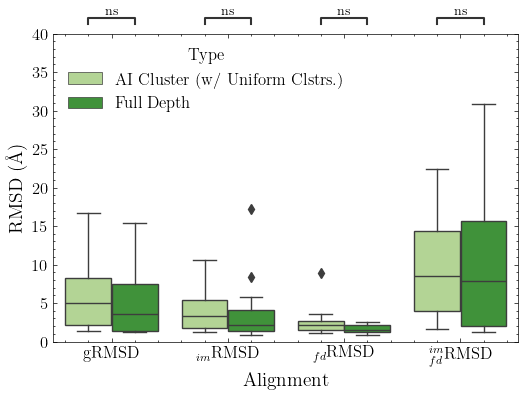

In [356]:
# Change the palette for just this plot
clust_colors = {'Full Depth': pal[3], 'AI Cluster (w/ Uniform Clstrs.)': pal[2]}

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=to_plot_2confs_melt, x='Alignment', y='RMSD', ax=ax, palette=clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Full Depth'), ('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [(im, 'Full Depth'), (im, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(fd, 'Full Depth'), (fd, 'AI Cluster (w/ Uniform Clstrs.)')],
         [(imfd, 'Full Depth'), (imfd, 'AI Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', im, fd, imfd]
annotator = Annotator(ax, pairs, data=to_plot_2confs_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/ai_2confs_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

### Looking at the multi-domain clusters

In [357]:
mdclust = pd.read_csv('./project_pipeline/data/md_pdb_cluster_compared.tsv', sep='\t').astype('object')

In [358]:
# Rename the columns
mdclust = mdclust.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster', 'complex_rmsd': 'gRMSD',
                              '1_aligned': d1, '2_aligned': d2, '2_comp': d1d2})
minimum_md2 = minimum_md.rename(columns={imfdd1d2: d1d2, imd1: d1, fdd2: d2})

mdclust['Type'] = 'Cluster'
minimum_md2['Type'] = 'TD Full Depth'

In [359]:
# Get the minimum for the clusters
min_md_clust = mdclust.groupby('UniProt')[d1d2].min().reset_index()
min_md_clust = pd.merge(min_md_clust, mdclust, on=['UniProt', d1d2], how='inner').drop_duplicates(subset='UniProt')

min_md_clust['UniProt'].nunique()

27

In [360]:
# Find common uniprots between minimum_cl and min_clust
mdclust_uniprots = min_md_clust['UniProt'].unique().tolist()
mdclass_uniprots = minimum_md2['UniProt'].unique().tolist()

mdcommon_uniprots = list(set(mdclust_uniprots).intersection(mdclass_uniprots))

mdto_plot_clust = min_md_clust[min_md_clust['UniProt'].isin(mdcommon_uniprots)]
mdto_plot_class = minimum_md2[minimum_md2['UniProt'].isin(mdcommon_uniprots)]

mdto_plot_clust['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'

mdto_plot = pd.concat([mdto_plot_clust, mdto_plot_class])

mdto_plot = mdto_plot[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

In [361]:
mdto_plot_class[mdto_plot_class['gRMSD'] <= 3].shape

(23, 7)

In [362]:
# Melt the data for plotting
mdto_plot_melt = pd.melt(mdto_plot, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_melt['RMSD'] = mdto_plot_melt['RMSD'].astype(float)
mdto_plot_melt[mdto_plot_melt['Type'] == 'TD Full Depth']

,UniProt,PDB,Type,Cluster,Alignment,RMSD
27,A0A0A0V031,5ups,TD Full Depth,NaN,gRMSD,0.914
28,A0A0F7R6G7,6m01,TD Full Depth,NaN,gRMSD,2.806
29,A0A0H2WY27,5ty7,TD Full Depth,NaN,gRMSD,0.770
30,A0A140DJY3,5wm5,TD Full Depth,NaN,gRMSD,1.296
31,A0A3B6UEQ0,7vxq,TD Full Depth,NaN,gRMSD,0.818
...,...,...,...,...,...,...
211,Q72AS4,3zea,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,0.617
212,Q7KLV9,3txn,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,1.758
213,Q8GN86,3cw9,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,58.555
214,Q941M3,3a9v,TD Full Depth,NaN,$_{d2}^{d1}$RMSD,56.136


In [363]:
mdto_plot_melt['Type'].value_counts()

TD Cluster (w/ Uniform Clstrs.)    108
TD Full Depth                      108
Name: Type, dtype: int64

/tmp/ipykernel_2466124/400108268.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.802e-04 U_stat=5.750e+02
gRMSD_TD Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:8.950e-04 U_stat=5.570e+02
$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d2}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.793e-05 U_stat=6.000e+02
$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:3.710e-02 U_stat=4.855e+02


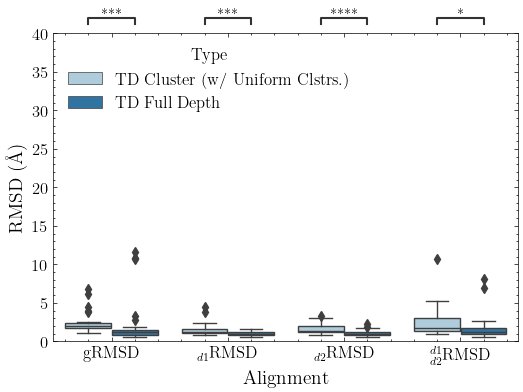

In [364]:
md_clust_colors = {'TD Full Depth': pal[1], 'TD Cluster (w/ Uniform Clstrs.)': pal[0]}

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_melt, x='Alignment', y='RMSD', ax=ax, palette=md_clust_colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'TD Full Depth'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d1, 'TD Full Depth'), (d1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d2, 'TD Full Depth'), (d2, 'TD Cluster (w/ Uniform Clstrs.)')],
         [(d1d2, 'TD Full Depth'), (d1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/md_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

Looking only at the obligate proteins.

In [365]:
mdto_plot_obli_clust = min_md_clust[min_md_clust['UniProt'].isin(obli_uniprots)]
mdto_plot_obli_class = minimum_md2[minimum_md2['UniProt'].isin(obli_uniprots)]

mdto_plot_obli_clust['Type'] = 'Obligate Cluster (w/ Uniform Clstrs.)'
mdto_plot_obli_class['Type'] = 'Obligate Full Depth'

mdto_plot_obli = pd.concat([mdto_plot_obli_clust, mdto_plot_obli_class])

mdto_plot_obli = mdto_plot_obli[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

/tmp/ipykernel_2466124/979203124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdto_plot_obli_clust['Type'] = 'Obligate Cluster (w/ Uniform Clstrs.)'
/tmp/ipykernel_2466124/979203124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdto_plot_obli_class['Type'] = 'Obligate Full Depth'


In [366]:
mdto_plot_obli_melt = pd.melt(mdto_plot_obli, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_obli_melt['RMSD'] = mdto_plot_obli_melt['RMSD'].astype(float)
mdto_plot_obli_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O60729,1ohc,Obligate Cluster (w/ Uniform Clstrs.),U100-007,gRMSD,1.791
1,O69275,2j3z,Obligate Cluster (w/ Uniform Clstrs.),U10-001,gRMSD,2.552
2,P04807,1ig8,Obligate Cluster (w/ Uniform Clstrs.),004,gRMSD,1.774
3,P04958,4j1l,Obligate Cluster (w/ Uniform Clstrs.),U10-008,gRMSD,2.071
4,P0AG30,1a62,Obligate Cluster (w/ Uniform Clstrs.),018,gRMSD,3.854


/tmp/ipykernel_2466124/1051581530.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d1}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.622e-02 U_stat=4.200e+01
gRMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. gRMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:6.993e-03 U_stat=4.500e+01
$_{d2}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d2}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.079e-03 U_stat=4.600e+01
$_{d2}^{d1}$RMSD_Obligate Cluster (w/ Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_Obligate Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:9.732e-02 U_stat=3.800e+01


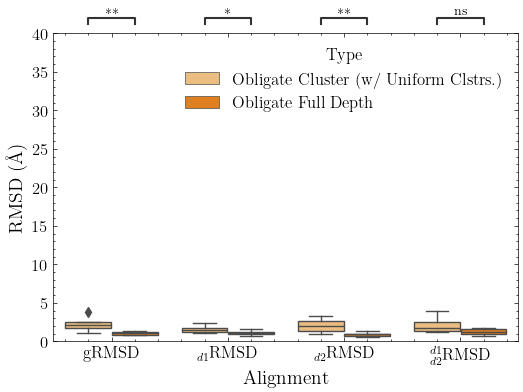

In [367]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_obli_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'Obligate Full Depth'), ('gRMSD', 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d1, 'Obligate Full Depth'), (d1, 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d2, 'Obligate Full Depth'), (d2, 'Obligate Cluster (w/ Uniform Clstrs.)')],
         [(d1d2, 'Obligate Full Depth'), (d1d2, 'Obligate Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_obli_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/obli_fd_vs_u_clust.png', dpi=500, bbox_inches='tight')

In [368]:
mdno_u = mdclust[~mdclust['Cluster'].str.contains('U')].reset_index(drop=True)

mdno_u['Type'] = 'TD Cluster (w/o Uniform Clstrs.)'

mdmin_nou = mdno_u.groupby('UniProt')[d1d2].min()
mdmin_nou = pd.merge(mdmin_nou, mdno_u, on=['UniProt', d1d2], how='inner').drop_duplicates(subset='UniProt')

In [369]:
mdno_uniprots = mdmin_nou['UniProt'].unique().tolist()

mdcommon_uniprots2 = list(set(mdno_uniprots).intersection(mdclass_uniprots))

mdto_plot_nou = mdmin_nou[mdmin_nou['UniProt'].isin(mdcommon_uniprots2)]

mdto_plot2 = pd.concat([mdto_plot_nou, mdto_plot_class])

mdto_plot2 = mdto_plot2[['UniProt', 'PDB', 'Cluster', 'gRMSD', d1, d2, d1d2, 'Type']]

In [370]:
mdto_plot_nou[['gRMSD', d1, d2, d1d2]].astype(float).describe()

,gRMSD,$_{d1}$RMSD,$_{d2}$RMSD,$_{d2}^{d1}$RMSD
count,23.000000,23.000000,23.000000,23.000000
mean,12.077043,7.270217,5.803478,14.731261
std,13.637417,8.032977,8.918208,23.217087
min,1.400000,1.057000,0.963000,1.151000
25%,2.891500,1.451000,1.758500,2.158000
50%,4.998000,2.575000,2.970000,5.889000
75%,16.432000,11.378500,4.122500,19.893000
max,50.568000,26.040000,38.742000,107.120000


In [371]:
# Melt the data for plotting
mdto_plot_melt2 = pd.melt(mdto_plot2, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
mdto_plot_melt2['RMSD'] = mdto_plot_melt2['RMSD'].astype(float)
mdto_plot_melt2['Alignment'].unique()

array(['gRMSD', '$_{d1}$RMSD', '$_{d2}$RMSD', '$_{d2}^{d1}$RMSD'],
      dtype=object)

/tmp/ipykernel_2466124/2201244073.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{d1}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.246e-07 U_stat=5.770e+02
gRMSD_TD Cluster (w/o Uniform Clstrs.) vs. gRMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.030e-06 U_stat=5.620e+02
$_{d2}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d2}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.364e-07 U_stat=5.765e+02
$_{d2}^{d1}$RMSD_TD Cluster (w/o Uniform Clstrs.) vs. $_{d2}^{d1}$RMSD_TD Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.940e-04 U_stat=4.970e+02


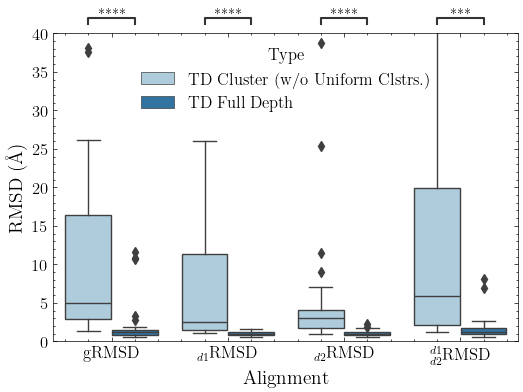

In [372]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=mdto_plot_melt2, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'TD Full Depth'), ('gRMSD', 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d1, 'TD Full Depth'), (d1, 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d2, 'TD Full Depth'), (d2, 'TD Cluster (w/o Uniform Clstrs.)')],
         [(d1d2, 'TD Full Depth'), (d1d2, 'TD Cluster (w/o Uniform Clstrs.)')]]
subcat_order = ['gRMSD', d1, d2, d1d2]
annotator = Annotator(ax, pairs, data=mdto_plot_melt2, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/md_fd_vs_no_u_clust.png', dpi=500, bbox_inches='tight')

## Now Cluster Dockq

In [373]:
ai2 = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_dockq.csv')
md2 = pd.read_csv('./project_pipeline/data/md_pdb_cluster_dockq.csv')

ai2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
ai2 = ai2.rename(columns={'pdb': 'PDB', 'cluster': 'Cluster'})

md2['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'
md2 = md2.rename(columns={'pdb': 'PDB', 'cluster': 'Cluster'})

In [374]:
ai2.head()

,Cluster,PDB,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri,Type
0,015,8hug,0.571,4.0,7.0,0.000,0.0,4.0,14.080,22.928,0.234,Acceptable,AI Cluster (w/ Uniform Clstrs.)
1,291,7nr5,0.161,18.0,112.0,0.750,54.0,72.0,18.655,28.054,0.084,Incorrect,AI Cluster (w/ Uniform Clstrs.)
2,287,1tvo,0.324,36.0,111.0,0.493,35.0,71.0,3.626,5.632,0.388,Acceptable,AI Cluster (w/ Uniform Clstrs.)
3,172,6qaq,0.167,18.0,108.0,0.654,34.0,52.0,15.519,24.091,0.096,Incorrect,AI Cluster (w/ Uniform Clstrs.)
4,301,8aof,0.382,42.0,110.0,0.512,44.0,86.0,3.044,5.386,0.430,Acceptable,AI Cluster (w/ Uniform Clstrs.)


In [375]:
# Select only the best fits
min_clust = min_clust.drop(columns=['Type'])
min_md_clust = min_md_clust.drop(columns=['Type'])

min_dockq_clust = pd.merge(min_clust, ai2, on=['PDB', 'Cluster'], how='inner')
min_dockq_md_clust = pd.merge(min_md_clust, md2, on=['PDB', 'Cluster'], how='inner')

In [376]:
min_dockq_clust.shape

(38, 35)

In [377]:
plotdockq = pd.concat([min_dockq_clust, min_dockq_md_clust], ignore_index=True)
plotdockq.columns

Index(['UniProt', 'gRMSD', 'PDB', 'Cluster', 'region_1', 'region_2',
       '1.0_aligned', '1.0_comp', '1.1_aligned', '1.1_comp', '1.2_aligned',
       '1.2_comp', '2.0_aligned', '2.0_comp', '2.1_aligned', '2.1_comp',
       '2.2_aligned', '2.2_comp', '2.3_aligned', '2.3_comp', '$_{im}$RMSD',
       '1_comp', '$_{fd}$RMSD', '$_{fd}^{im}$RMSD', 'fnat', 'fnat_correct',
       'fnat_total', 'fnonnat', 'fnonnat_nnative', 'fnonnat_model', 'irms',
       'lrms', 'dockq', 'capri', 'Type', '$_{d2}^{d1}$RMSD', '$_{d1}$RMSD',
       '$_{d2}$RMSD'],
      dtype='object')

/tmp/ipykernel_2466124/317834153.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


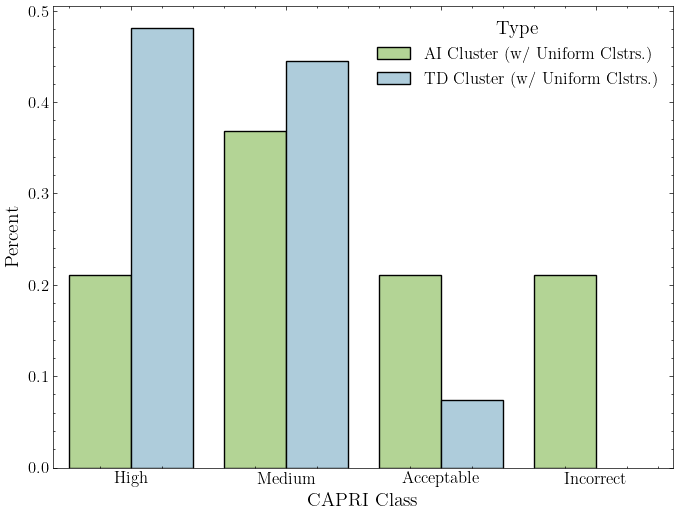

In [378]:
# We want percentages of CAPRI Classes
perc2 = plotdockq.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc2

# Make the CAPRI Class categorical
perc2['capri'] = pd.Categorical(perc2['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=perc2, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=14)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize='14', fontsize='12')

plt.savefig('./project_pipeline/data/figures/paper/clust_dockq_histograms.png', bbox_inches='tight', dpi=1200)

In [379]:
# min_nou = min_nou.drop(columns=['Type'])
# mdmin_nou = mdmin_nou.drop(columns=['Type'])

min_dockq_nou = pd.merge(min_nou, ai2, on=['PDB', 'Cluster'], how='inner')
mdmin_dockq_nou = pd.merge(mdmin_nou, md2, on=['PDB', 'Cluster'], how='inner')

min_dockq_nou['Type'] = 'AI Cluster (w/o Uniform Clstrs.)'
mdmin_dockq_nou['Type'] = 'TD Cluster (w/o Uniform Clstrs.)'

plotdockq2 = pd.concat([min_dockq_nou, mdmin_dockq_nou], ignore_index=True)
plotdockq2.shape

(57, 40)

/tmp/ipykernel_2466124/2949212632.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


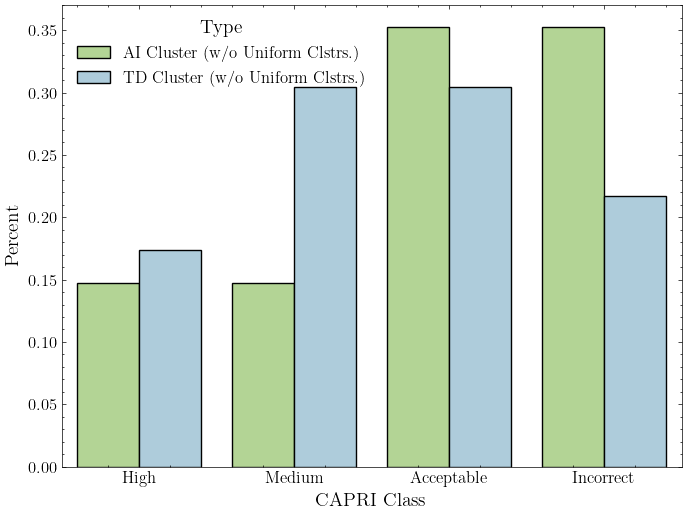

In [380]:
# We want percentages of CAPRI Classes
perc3 = plotdockq2.groupby('Type')['capri'].value_counts(normalize=True).reset_index(name='Percent')
perc3

# Make the CAPRI Class categorical
perc3['capri'] = pd.Categorical(perc3['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])
# Plot the data

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=perc3, x='capri', y='Percent', hue='Type', palette=colors, ax=ax, edgecolor='black')
ax.set_xlabel('CAPRI Class', fontsize=14)
ax.set_ylabel('Percent', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', title_fontsize='14', fontsize='12')

plt.savefig('./project_pipeline/data/figures/paper/clust_nou_dockq_histograms.png', bbox_inches='tight', dpi=300)

In [381]:
perc3

,Type,capri,Percent
0,AI Cluster (w/o Uniform Clstrs.),Acceptable,0.352941
1,AI Cluster (w/o Uniform Clstrs.),Incorrect,0.352941
2,AI Cluster (w/o Uniform Clstrs.),High,0.147059
3,AI Cluster (w/o Uniform Clstrs.),Medium,0.147059
4,TD Cluster (w/o Uniform Clstrs.),Acceptable,0.304348
5,TD Cluster (w/o Uniform Clstrs.),Medium,0.304348
6,TD Cluster (w/o Uniform Clstrs.),Incorrect,0.217391
7,TD Cluster (w/o Uniform Clstrs.),High,0.173913


#### Plotting TD cluster vs AI cluster

In [382]:
to_plot_clust = to_plot_clust.rename(columns={imfd: imfdd1d2,
                                               im: imd1, fd: '$_{fd}$RMSD/$_{d2}$RMSD'})
mdto_plot_clust = mdto_plot_clust.rename(columns={d1d2: imfdd1d2,
                                                  d1: imd1,
                                                  d2: '$_{fd}$RMSD/$_{d2}$RMSD'})

In [383]:
to_plot_clust['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'
mdto_plot_clust['Type'] = 'TD Cluster (w/ Uniform Clstrs.)'

to_plot3 = pd.concat([to_plot_clust, mdto_plot_clust])
to_plot3 = to_plot3[['UniProt', 'PDB', 'Type', 'Cluster', 'gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', 
                     imfdd1d2]]
to_plot3.head()

,UniProt,PDB,Type,Cluster,gRMSD,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),001,1.954,0.879,2.043,1.044
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-009,5.493,1.779,5.023,10.595
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,8.897,3.742,1.24,8.351
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-000,19.891,16.193,16.013,24.167
4,O76074,3mf0,AI Cluster (w/ Uniform Clstrs.),U100-001,7.514,2.492,2.779,6.1


In [384]:
# Melt the data for plotting
to_plot3_melt = pd.melt(to_plot3, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot3_melt['RMSD'] = to_plot3_melt['RMSD'].astype(float)
to_plot3_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,B5XAZ0,7bfl,AI Cluster (w/ Uniform Clstrs.),001,gRMSD,1.954
1,D2AJU0,6lol,AI Cluster (w/ Uniform Clstrs.),U10-009,gRMSD,5.493
2,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
3,O60741,5u6o,AI Cluster (w/ Uniform Clstrs.),U10-000,gRMSD,19.891
4,O76074,3mf0,AI Cluster (w/ Uniform Clstrs.),U100-001,gRMSD,7.514


In [385]:
to_plot3['Type'].value_counts()

AI Cluster (w/ Uniform Clstrs.)    38
TD Cluster (w/ Uniform Clstrs.)    27
Name: Type, dtype: int64

/tmp/ipykernel_2466124/286088877.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD/$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.250e-06 U_stat=8.505e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:2.568e-03 U_stat=7.400e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.165e-03 U_stat=7.155e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.729e-06 U_stat=8.610e+02


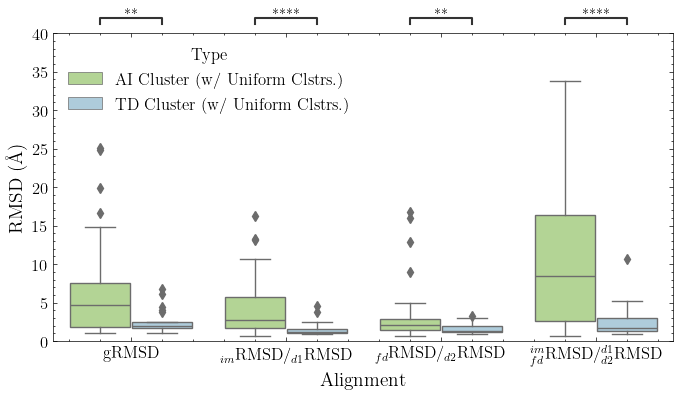

In [386]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=to_plot3_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imd1, 'AI Cluster (w/ Uniform Clstrs.)'), (imd1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [('$_{fd}$RMSD/$_{d2}$RMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('$_{fd}$RMSD/$_{d2}$RMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imfdd1d2, 'AI Cluster (w/ Uniform Clstrs.)'), (imfdd1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', imfdd1d2]
annotator = Annotator(ax, pairs, data=to_plot3_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/ai_vs_md_clust.png', dpi=500, bbox_inches='tight')

Now compare for AI structures with two conformations.

In [387]:
to_plot_clust2 = to_plot_clust2.rename(columns={imfd: imfdd1d2,
                                               im: imd1, fd: '$_{fd}$RMSD/$_{d2}$RMSD'})

to_plot_clust2['Type'] = 'AI Cluster (w/ Uniform Clstrs.)'

to_plot4 = pd.concat([to_plot_clust2, mdto_plot_clust])
to_plot4 = to_plot4[['UniProt', 'PDB', 'Type', 'Cluster', 'gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', 
                     imfdd1d2]]
to_plot4.head()

# Melt the data for plotting
to_plot4_melt = pd.melt(to_plot4, id_vars=['UniProt', 'PDB', 'Type', 'Cluster'], var_name='Alignment', value_name='RMSD')
to_plot4_melt['RMSD'] = to_plot4_melt['RMSD'].astype(float)
to_plot4_melt.head()

,UniProt,PDB,Type,Cluster,Alignment,RMSD
0,O08967,2r0d,AI Cluster (w/ Uniform Clstrs.),020,gRMSD,8.897
1,P00579,4lk1,AI Cluster (w/ Uniform Clstrs.),U100-000,gRMSD,16.681
2,P07038,7nxf,AI Cluster (w/ Uniform Clstrs.),U100-002,gRMSD,5.015
3,P12931,7yqe,AI Cluster (w/ Uniform Clstrs.),U10-007,gRMSD,1.402
4,P21333,2j3s,AI Cluster (w/ Uniform Clstrs.),U100-008,gRMSD,9.890


/tmp/ipykernel_2466124/4097917051.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{im}$RMSD/$_{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.820e-05 U_stat=3.750e+02
gRMSD_AI Cluster (w/ Uniform Clstrs.) vs. gRMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:2.084e-03 U_stat=3.390e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:2.453e-02 U_stat=3.060e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Cluster (w/ Uniform Clstrs.) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.206e-05 U_stat=3.820e+02


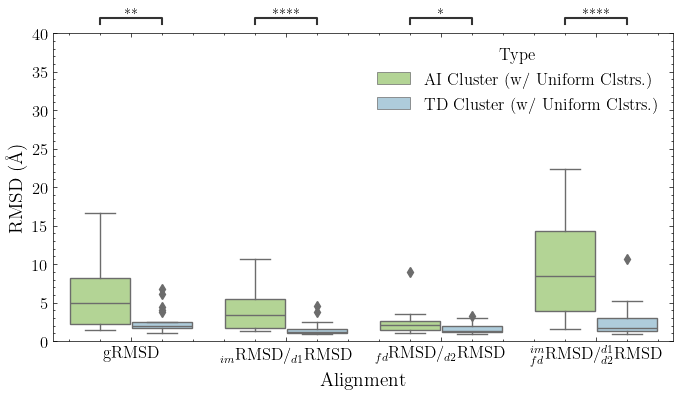

In [388]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=to_plot4_melt, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('gRMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imd1, 'AI Cluster (w/ Uniform Clstrs.)'), (imd1, 'TD Cluster (w/ Uniform Clstrs.)')],
         [('$_{fd}$RMSD/$_{d2}$RMSD', 'AI Cluster (w/ Uniform Clstrs.)'), ('$_{fd}$RMSD/$_{d2}$RMSD', 'TD Cluster (w/ Uniform Clstrs.)')],
         [(imfdd1d2, 'AI Cluster (w/ Uniform Clstrs.)'), (imfdd1d2, 'TD Cluster (w/ Uniform Clstrs.)')]]
subcat_order = ['gRMSD', imd1, '$_{fd}$RMSD/$_{d2}$RMSD', imfdd1d2]
annotator = Annotator(ax, pairs, data=to_plot4_melt, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/two_conf_ai_vs_md_clust.png', dpi=500, bbox_inches='tight')

## pLDDT of Clusters

In [2765]:
clAuto = pd.read_csv('./project_pipeline/data/ai_cluster_pLDDT.tsv', sep='\t')
clMulti = pd.read_csv('./project_pipeline/data/md_cluster_pLDDT.tsv', sep='\t')
clAuto = clAuto.drop(columns=['Unnamed: 0'])
clMulti['cluster'] = clMulti.apply(lambda x: x['cf_filename'].split('_')[1], axis=1)
clMulti.head()

clAuto = clAuto.rename(columns={'uniprot': 'UniProt', 'cluster': 'Cluster'})
clMulti = clMulti.rename(columns={'uniprot': 'UniProt', 'cluster': 'Cluster'})

In [390]:
clAuto.head()

,UniProt,pdb,region_1,region_2,af_filename,chain,Cluster,cf_filename,complex_mean_plddt,r1_mean_plddt,r2_mean_plddt
0,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,004,P04637_004_unrelaxed_rank_001_alphafold2_multi...,55.981,41.231,68.223
1,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,000,P04637_000_unrelaxed_rank_001_alphafold2_multi...,54.921,35.245,60.018
2,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,015,P04637_015_unrelaxed_rank_001_alphafold2_multi...,59.944,35.621,77.713
3,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,009,P04637_009_unrelaxed_rank_001_alphafold2_multi...,55.534,42.184,64.641
4,P04637,8f2h,364-393,102-292,F-P04637-F1-model_v3.cif,A,U100-003,P04637_U100-003_unrelaxed_rank_001_alphafold2_...,76.372,33.071,95.035


In [391]:
afAutosub = afAuto[afAuto['uniprot'].isin(clust_uniprots)].drop_duplicates()
afMultisub = afMulti[afMulti['uniprot'].isin(mdclust_uniprots)].drop_duplicates()

In [2766]:
clAuto = clAuto.drop(columns=['cf_filename', 'pdb', 'af_filename', 'chain']).drop_duplicates().reset_index(drop=True)
clMulti = clMulti.drop(columns=['cf_filename', 'af_filename']).drop_duplicates().reset_index(drop=True)

In [2767]:
# clAuto for only our fifteen proteins.
clAuto_fif = clAuto[clAuto['UniProt'].isin(fifteen_prots)]

# Split between uniformly clustered and locally clustered.
uc_fif = clAuto_fif[clAuto_fif['Cluster'].str.contains('U')].rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})
lc_fif = clAuto_fif[~clAuto_fif['Cluster'].str.contains('U')].rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})

uc_fif = rename_auto_columns(uc_fif)
lc_fif = rename_auto_columns(lc_fif)

uc_fif_p = pivot_cf_df(uc_fif)
lc_fif_p = pivot_cf_df(lc_fif)

uc_fif_p['type'] = 'AI Uniform Clusters'
lc_fif_p['type'] = 'AI Local Clusters'

fif_p = pd.concat([uc_fif_p, lc_fif_p])

In [2772]:
fif_p['type'].value_counts()

AI Local Clusters      3177
AI Uniform Clusters     900
Name: type, dtype: int64

/tmp/ipykernel_2466124/1107180147.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Uniform Clusters vs. IM_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:4.828e-44 U_stat=2.424e+05
Global AI_AI Uniform Clusters vs. Global AI_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.858e-47 U_stat=2.455e+05
FD_AI Uniform Clusters vs. FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:9.556e-53 U_stat=2.506e+05
6.741398733563159 4.0642161747504995


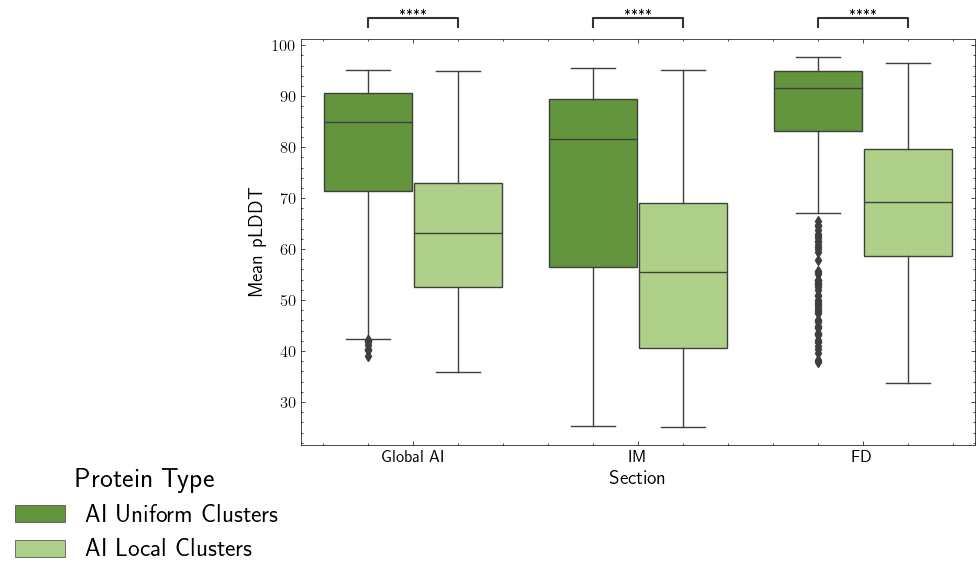

In [2871]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=fif_p, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
handles, labels = ax.get_legend_handles_labels()
# labels = ['AI Full Depth', 'AI Cluster \n (w/ Uniform \n Clstrs.)']
ax.legend(title='Protein Type', title_fontsize='20', fontsize='18', bbox_to_anchor=(0, 0))


# Annotate statistical significance
pairs = [[('Global AI', 'AI Uniform Clusters'), ('Global AI', 'AI Local Clusters')],
         [('IM', 'AI Uniform Clusters'), ('IM', 'AI Local Clusters')],
         [('FD', 'AI Uniform Clusters'), ('FD', 'AI Local Clusters')]]

type_order = ['AI Cluster (w/ Uniform Clstrs.)', 'AI Full Depth']
annotator = Annotator(ax, pairs, data=fif_p, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the figure
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/15_prots_cluster_plddt.png', dpi=500, bbox_inches='tight')

bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(width, height)

In [393]:
# Get the pLDDT of only the best clusters
bestclAuto = pd.merge(min_clust[['UniProt', 'Cluster']], clAuto, on=['UniProt', 'Cluster'], how='inner')
bestclMulti = pd.merge(min_md_clust[['UniProt', 'Cluster']], clMulti, on=['UniProt', 'Cluster'], how='inner')

bestclAuto = bestclAuto.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})
bestclMulti = bestclMulti.rename(columns={'UniProt': 'uniprot', 'Cluster': 'cluster'})

In [394]:
bestclAuto = rename_auto_columns(bestclAuto)
bestclMulti = rename_multi_columns(bestclMulti)

afAutosub = rename_auto_columns(afAutosub)
afMultisub = rename_multi_columns(afMultisub)

bestclAuto_p = pivot_cf_df(bestclAuto)
bestclMulti_p = pivot_cf_df(bestclMulti)

bestafAuto_p = pivot_af_df(afAutosub)
bestafMulti_p = pivot_af_df(afMultisub)

bestclAuto_p['type'] = 'AI Cluster (w/ Uniform Clstrs.)'
bestclMulti_p['type'] = 'TD Cluster (w/ Uniform Clstrs.)'

bestafAuto_p['type'] = 'AI Full Depth'
bestafMulti_p['type'] = 'TD Full Depth'

clplddt = pd.concat([bestclAuto_p, bestclMulti_p])
aiplddt = pd.concat([bestafAuto_p, bestclAuto_p])
mdplddt = pd.concat([bestafMulti_p, bestclMulti_p])

## PAE for Clusters

In [2774]:
df_auto_cl = pd.read_csv('./project_pipeline/data/ai_cluster_pae.tsv', sep='\t').astype('object')
df_multi_cl = pd.read_csv('./project_pipeline/data/md_cluster_pae.tsv', sep='\t').astype('object')

In [1432]:
df_multi_cl.head()

,uniprot,cluster,region_1,region_2,mean_pae_1_1,mean_pae_1_2,mean_pae_2_2
0,D9N168,U10-007,3-169,336-543,NaN,NaN,NaN
1,D9N168,U100-004,3-169,336-543,NaN,NaN,NaN
2,D9N168,U10-005,3-169,336-543,NaN,NaN,NaN
3,D9N168,U100-002,3-169,336-543,NaN,NaN,NaN
4,D9N168,U10-009,3-169,336-543,NaN,NaN,NaN


In [901]:
print('The number of unique autoinhibitory clusters is ' + str(df_auto_cl.groupby('uniprot')['cluster'].nunique().sum()))
print('The number of unique two-domain clusters is ' + str(df_multi_cl.groupby('uniprot')['cluster'].nunique().sum()))

The number of unique autoinhibitory clusters is 1536
The number of unique two-domain clusters is 2168


In [2775]:
# Reformat all pae dataframe
df_auto_cl = df_auto_cl[['uniprot', 'cluster', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_auto_cl = df_auto_cl.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 'mean_pae_2_2': 'FD', 'uniprot': 'UniProt', 'cluster': 'Cluster'})
best_cl_pae = pd.merge(min_clust[['UniProt', 'Cluster']], df_auto_cl, on=['UniProt', 'Cluster'], how='inner')
best_cl_pae_melt = best_cl_pae.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Get full-depth PAEs for only the cluster proteins
df_pae_melt2 = df_pae_melt[df_pae_melt['uniprot'].isin(clust_uniprots)]

# Reformat the multi dataframe
df_multi_cl = df_multi_cl[['uniprot', 'cluster', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi_cl = df_multi_cl.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 vs D2', 'mean_pae_2_2': 'D2', 'uniprot': 'UniProt', 'cluster': 'Cluster'})
best_multi_cl_pae = pd.merge(min_md_clust[['UniProt', 'Cluster']], df_multi_cl, on=['UniProt', 'Cluster'], how='inner')
best_multi_cl_pae_melt = best_multi_cl_pae.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Get full-depth PAEs for only the md cluster proteins
df_multi_melt2 = df_multi_melt[df_multi_melt['uniprot'].isin(mdclust_uniprots)]

# Add type column
best_cl_pae_melt['type'] = 'AI Cluster (w/ Uniform Clstrs.)'
df_pae_melt2['type'] = 'AI Full Depth'
best_multi_cl_pae_melt['type'] = 'TD Cluster (w/ Uniform Clstrs.)'
df_multi_melt2['type'] = 'TD Full Depth'

# Merge all dataframes
all_ai = pd.concat([df_pae_melt2, best_cl_pae_melt])
all_md = pd.concat([df_multi_melt2, best_multi_cl_pae_melt])

all_ai['mean_pae'] = all_ai['mean_pae'].astype(float)
all_md['mean_pae'] = all_md['mean_pae'].astype(float)

/tmp/ipykernel_2466124/3252188992.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pae_melt2['type'] = 'AI Full Depth'
/tmp/ipykernel_2466124/3252188992.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multi_melt2['type'] = 'TD Full Depth'


In [2776]:
fif_pae = df_auto_cl[df_auto_cl['UniProt'].isin(fifteen_prots)]

pae_uc = fif_pae[fif_pae['Cluster'].str.contains('U')]
pae_lc = fif_pae[~fif_pae['Cluster'].str.contains('U')]

pae_uc_melt = pae_uc.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').astype({'mean_pae': float})
pae_lc_melt = pae_lc.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').astype({'mean_pae': float})

pae_uc_melt['type'] = 'AI Uniform Clusters'
pae_lc_melt['type'] = 'AI Local Clusters'

fif_pae_plot = pd.concat([pae_uc_melt, pae_lc_melt])

/tmp/ipykernel_2466124/1219959084.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Uniform Clusters vs. IM_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:4.828e-44 U_stat=2.424e+05
Global AI_AI Uniform Clusters vs. Global AI_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.858e-47 U_stat=2.455e+05
FD_AI Uniform Clusters vs. FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:9.556e-53 U_stat=2.506e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Uniform Clusters vs. IM_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:5.054e-40 U_stat=7.939e+04


/tmp/ipykernel_2466124/1219959084.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=12)


FD_AI Uniform Clusters vs. FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.593e-51 U_stat=6.843e+04
IM vs FD_AI Uniform Clusters vs. IM vs FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.200e-24 U_stat=9.770e+04


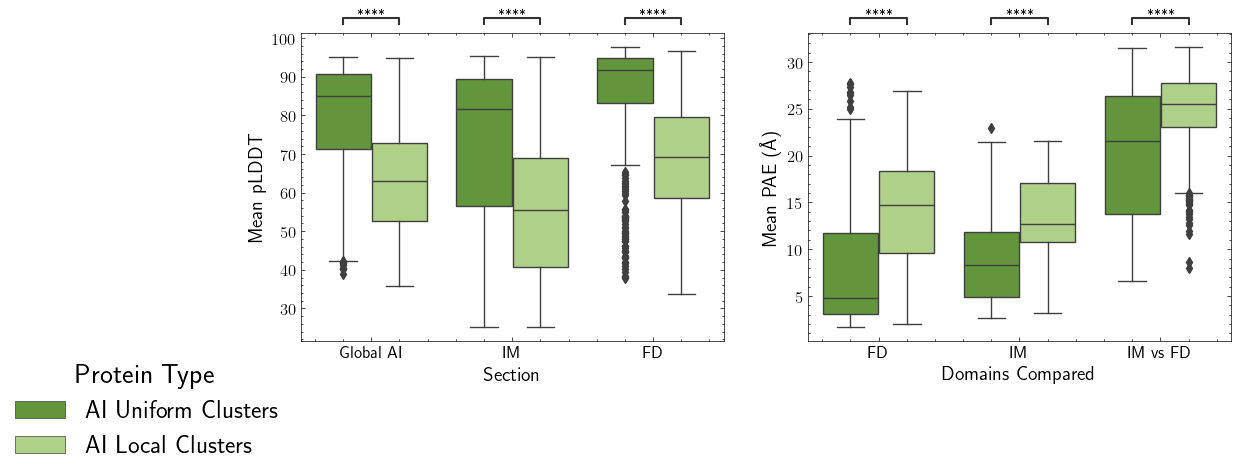

In [2879]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

region_order = ['FD', 'IM', 'IM vs FD']


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=fif_p, x='Section', y='Mean pLDDT', ax = ax[0], hue='type', palette=colors, order=subcat_order)
ax[0].set_ylabel('Mean pLDDT', fontsize=14)
ax[0].set_xlabel('Section', fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=12)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=12)
handles, labels = ax[0].get_legend_handles_labels()
# labels = ['AI Full Depth', 'AI Cluster \n (w/ Uniform \n Clstrs.)']
ax[0].legend(title='Protein Type', title_fontsize='20', fontsize='18', bbox_to_anchor=(0, 0))


# Annotate statistical significance
pairs = [[('Global AI', 'AI Uniform Clusters'), ('Global AI', 'AI Local Clusters')],
         [('IM', 'AI Uniform Clusters'), ('IM', 'AI Local Clusters')],
         [('FD', 'AI Uniform Clusters'), ('FD', 'AI Local Clusters')]]

type_order = ['AI Cluster (w/ Uniform Clstrs.)', 'AI Full Depth']
annotator = Annotator(ax[0], pairs, data=fif_p, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

sns.boxplot(data=fif_pae_plot, x='region', y='mean_pae', hue='type', order=region_order, ax=ax[1], palette=colors)
ax[1].set_xlabel('Domains Compared', fontsize=14)
ax[1].set_ylabel('Mean PAE (Å)', fontsize=14)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=12)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=12)
ax[1].get_legend().remove()

# Annotate statistical significance

pairs = [[('FD', 'AI Uniform Clusters'), ('FD', 'AI Local Clusters')],
         [('IM', 'AI Uniform Clusters'), ('IM', 'AI Local Clusters')],
         [('IM vs FD', 'AI Uniform Clusters'), ('IM vs FD', 'AI Local Clusters')]]
annotator = Annotator(ax[1], pairs, data=fif_pae_plot, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/15_prots_cluster_pae_plddt.png', dpi=500, bbox_inches='tight')

/tmp/ipykernel_2466124/3974771457.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.857e-01 U_stat=3.260e+02
FD_AI Full Depth vs. FD_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.060e-01 U_stat=3.200e+02
IM vs FD_AI Full Depth vs. IM vs FD_AI Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:3.948e-01 U_stat=2.930e+02


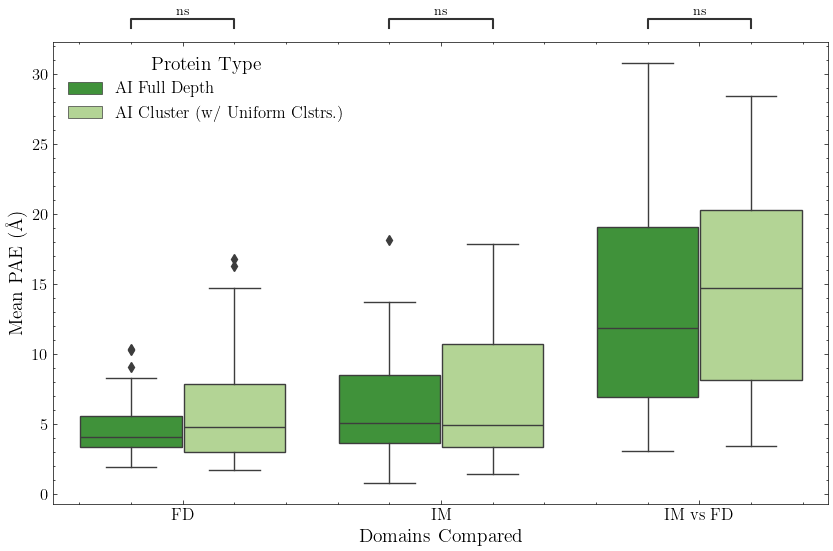

In [408]:
region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_ai, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('FD', 'AI Full Depth'), ('FD', 'AI Cluster (w/ Uniform Clstrs.)')],
         [('IM', 'AI Full Depth'), ('IM', 'AI Cluster (w/ Uniform Clstrs.)')],
         [('IM vs FD', 'AI Full Depth'), ('IM vs FD', 'AI Cluster (w/ Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_ai, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/ai_cluster_v_fd_pae_annotated.png')

/tmp/ipykernel_2466124/2486192647.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.735e-02 U_stat=1.740e+02
D2_TD Full Depth vs. D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:7.718e-01 U_stat=2.700e+02
D1 vs D2_TD Full Depth vs. D1 vs D2_TD Cluster (w/ Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.736e-01 U_stat=1.950e+02


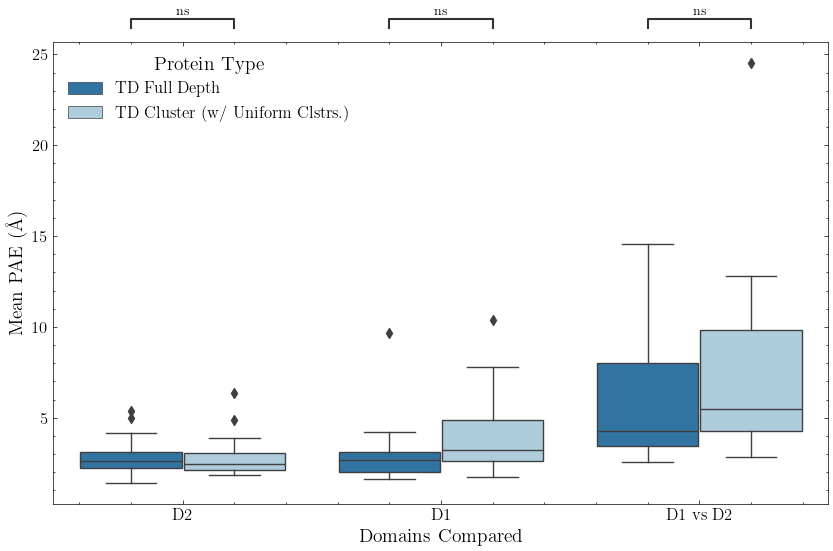

In [409]:
region_order = ['D2', 'D1', 'D1 vs D2']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_md, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('D2', 'TD Full Depth'), ('D2', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('D1', 'TD Full Depth'), ('D1', 'TD Cluster (w/ Uniform Clstrs.)')],
         [('D1 vs D2', 'TD Full Depth'), ('D1 vs D2', 'TD Cluster (w/ Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_md, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/md_cluster_v_fd_pae_annotated.png')

In [410]:
# Non-uniformly clustered proteins
best_cl_pae_nou = pd.merge(min_nou[['UniProt', 'Cluster']], df_auto_cl, on=['UniProt', 'Cluster'], how='inner')
best_cl_pae_nou_melt = best_cl_pae_nou.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Multi-domain
best_multi_cl_pae_nou = pd.merge(mdmin_nou[['UniProt', 'Cluster']], df_multi_cl, on=['UniProt', 'Cluster'], how='inner')
best_multi_cl_pae_nou_melt = best_multi_cl_pae_nou.melt(id_vars=['UniProt', 'Cluster'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
best_cl_pae_nou_melt['type'] = 'AI Cluster (w/o Uniform Clstrs.)'
best_multi_cl_pae_nou_melt['type'] = 'TD Cluster (w/o Uniform Clstrs.)'

# Merge all dataframes
all_ai_nou = pd.concat([df_pae_melt2, best_cl_pae_nou_melt])
all_md_nou = pd.concat([df_multi_melt2, best_multi_cl_pae_nou_melt])

all_ai_nou['mean_pae'] = all_ai_nou['mean_pae'].astype(float)
all_md_nou['mean_pae'] = all_md_nou['mean_pae'].astype(float)

In [411]:
all_ai_nou.shape

(162, 6)

/tmp/ipykernel_2466124/107397626.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.421e-01 U_stat=2.260e+02
FD_AI Full Depth vs. FD_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:8.148e-06 U_stat=6.800e+01
IM vs FD_AI Full Depth vs. IM vs FD_AI Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:8.227e-03 U_stat=1.640e+02


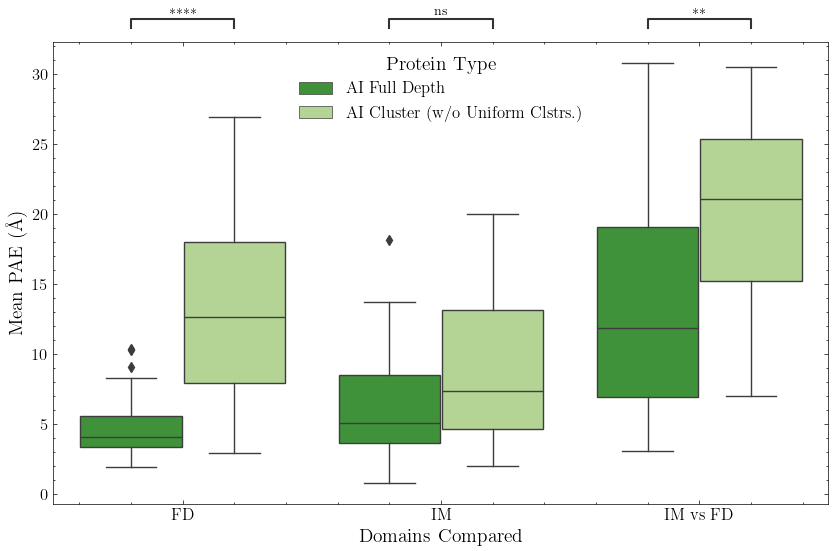

In [412]:
region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_ai_nou, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('FD', 'AI Full Depth'), ('FD', 'AI Cluster (w/o Uniform Clstrs.)')],
         [('IM', 'AI Full Depth'), ('IM', 'AI Cluster (w/o Uniform Clstrs.)')],
         [('IM vs FD', 'AI Full Depth'), ('IM vs FD', 'AI Cluster (w/o Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_ai_nou, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/ai_cluster_v_fd_pae_nou.png')

/tmp/ipykernel_2466124/4146658570.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1_TD Full Depth vs. D1_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:5.514e-05 U_stat=5.500e+01
D2_TD Full Depth vs. D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:6.627e-04 U_stat=8.000e+01
D1 vs D2_TD Full Depth vs. D1 vs D2_TD Cluster (w/o Uniform Clstrs.): Mann-Whitney-Wilcoxon test two-sided, P_val:1.906e-04 U_stat=6.700e+01


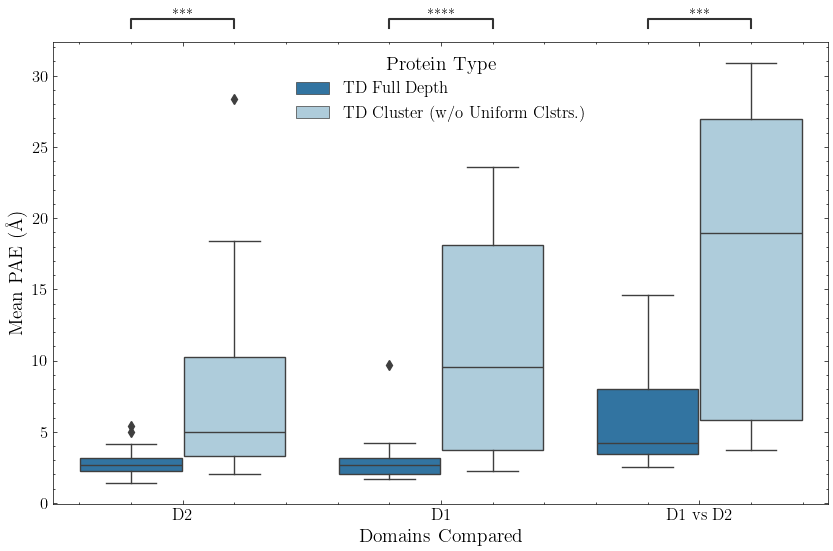

In [413]:
region_order = ['D2', 'D1', 'D1 vs D2']

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=all_md_nou, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE (Å)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('D2', 'TD Full Depth'), ('D2', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('D1', 'TD Full Depth'), ('D1', 'TD Cluster (w/o Uniform Clstrs.)')],
         [('D1 vs D2', 'TD Full Depth'), ('D1 vs D2', 'TD Cluster (w/o Uniform Clstrs.)')]]
annotator = Annotator(ax, pairs, data=all_md_nou, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/md_cluster_v_fd_pae_nou.png')

## Making a table of the one-state proteins

In [414]:
two_state_proteins = cl.groupby('uniprot')['state'].nunique()
two_state_proteins = two_state_proteins[two_state_proteins > 1].index.tolist()

two_conf_proteins = to_plot_class2['UniProt'].unique()

one_state = min_clust[~min_clust['UniProt'].isin(common_uniprots_ai)]
one_state_proteins = one_state['UniProt'].unique()
one_state_cluster = one_state[['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]] \
                    .rename(columns={'PDB': 'Cluster PDB',
                                     'gRMSD': 'Cluster gRMSD',
                                     imfd: 'Cluster $_{fd}^{im}$RMSD'})

one_state_full_depth = minimum_cl[minimum_cl['UniProt'].isin(one_state_proteins)]
one_state_full_depth = one_state_full_depth[['UniProt', 'PDB', 'gRMSD', imfdd1d2]] \
                        .rename(columns={'PDB': 'Full Depth PDB',
                                        'gRMSD': 'Full Depth gRMSD', 
                                         imfdd1d2: 'Full Depth $_{fd}^{im}$RMSD'})

one_state_both = pd.merge(one_state_cluster, one_state_full_depth, on='UniProt', how='inner')

cols = ['UniProt', 'Full Depth $_{fd}^{im}$RMSD', 'Cluster $_{fd}^{im}$RMSD', 'Full Depth gRMSD', 'Cluster gRMSD']

to_table_1state = one_state_both[cols]

to_table_1state = to_table_1state.astype({'Full Depth gRMSD': float, 'Cluster gRMSD': float,
                                          'Full Depth $_{fd}^{im}$RMSD': float, 'Cluster $_{fd}^{im}$RMSD': float})

In [415]:
one_state_both

,UniProt,Cluster PDB,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,Full Depth PDB,Full Depth gRMSD,Full Depth $_{fd}^{im}$RMSD
0,B5XAZ0,7bfl,001,1.954,1.044,7bfl,2.591,0.807
1,D2AJU0,6lol,U10-009,5.493,10.595,6lol,3.539,7.860
2,O60741,5u6o,U10-000,19.891,24.167,5u6p,1.182,1.290
3,O76074,3mf0,U100-001,7.514,6.1,3mf0,3.048,3.890
4,P00520,1opk,U10-003,24.798,55.076,1opk,1.679,1.654
5,P00523,2ptk,U100-006,2.794,17.475,2ptk,1.737,3.093
6,P04637,8f2h,023,25.15,66.959,8f2h,30.431,70.729
7,P13864,3pt6,U100-003,7.651,33.829,3pt6,7.752,34.613
8,P14633,1na6,U100-002,2.901,5.365,1na6,2.214,4.067
9,P31016,1jxm,U100-004,1.54,2.27,1jxm,1.597,2.827


In [416]:
to_table_1state

,UniProt,Full Depth $_{fd}^{im}$RMSD,Cluster $_{fd}^{im}$RMSD,Full Depth gRMSD,Cluster gRMSD
0,B5XAZ0,0.807,1.044,2.591,1.954
1,D2AJU0,7.860,10.595,3.539,5.493
2,O60741,1.290,24.167,1.182,19.891
3,O76074,3.890,6.100,3.048,7.514
4,P00520,1.654,55.076,1.679,24.798
5,P00523,3.093,17.475,1.737,2.794
6,P04637,70.729,66.959,30.431,25.150
7,P13864,34.613,33.829,7.752,7.651
8,P14633,4.067,5.365,2.214,2.901
9,P31016,2.827,2.270,1.597,1.540


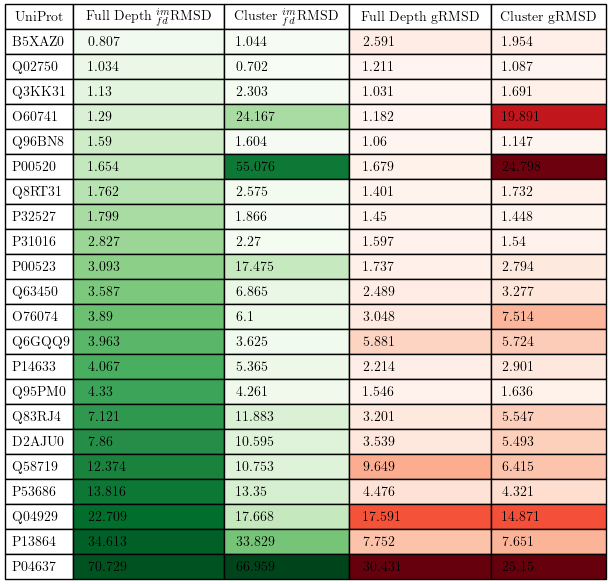

<Figure size 350x262.5 with 0 Axes>

In [417]:
fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')

to_table = to_table_1state.sort_values('Full Depth $_{fd}^{im}$RMSD', ascending=True)

table = ax.table(cellText=to_table.values,
                  colLabels=to_table.columns,
                  cellLoc = 'left', loc='center')
table.auto_set_column_width(col=list(range(len(to_table.columns))))
table.scale(1, 1.5)

bcmap = sns.mpl_palette('Greens', len(to_table['Full Depth $_{fd}^{im}$RMSD'].unique()))
for idx, b in enumerate(bcmap):
    table[(idx + 1, 1)].set_facecolor(b)

from matplotlib import cm
vals = to_table['Cluster $_{fd}^{im}$RMSD'].values
normal = cm.colors.Normalize(vals.min(), vals.max())
bcmap2 = plt.cm.Greens(normal(vals))

for idx, bb in enumerate(bcmap2):
    table[(idx + 1, 2)].set_facecolor(bb)

vals2 = to_table['Full Depth gRMSD'].values
normal2 = cm.colors.Normalize(vals2.min(), vals2.max())
bcmap3 = plt.cm.Reds(normal2(vals2))

for idx, bbb in enumerate(bcmap3):
    table[(idx+1, 3)].set_facecolor(bbb)

vals3 = to_table['Cluster gRMSD'].values
normal3 = cm.colors.Normalize(vals3.min(), vals3.max())
bcmap4 = plt.cm.Reds(normal3(vals3))

for idx, bbbb in enumerate(bcmap4):
    table[(idx+1, 4)].set_facecolor(bbbb)

plt.show()

plt.savefig('./project_pipeline/data/figures/paper/one_state_proteins.png', dpi=300, bbox_inches='tight')

To make a table comparing cluster $_{im}$RMSDs with full-depth $_{im}$RMSDs, we'll rename some of the columns

In [418]:
to_table_nou = to_plot_nou[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd, 'Type']]

to_table_class = to_plot_class2[['UniProt', 'PDB', 'gRMSD', im, fd, imfd, 'Type']]

to_table_nou = to_table_nou.rename(columns={imfd: 'Cluster $_{fd}^{im}$RMSD', 'gRMSD': 'Cluster gRMSD'})

to_table_class = to_table_class.rename(columns={imfd: 'Full Depth $_{fd}^{im}$RMSD', 'gRMSD': 'Full Depth gRMSD'})

to_table_nou = to_table_nou[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]

to_table_class = to_table_class[['UniProt', 'Full Depth gRMSD', 'Full Depth $_{fd}^{im}$RMSD']]

to_table = pd.merge(to_table_nou, to_table_class, on=['UniProt'], how='inner')

to_table['Full Depth gRMSD'] = to_table['Full Depth gRMSD'].astype(float)
to_table['Cluster gRMSD'] = to_table['Cluster gRMSD'].astype(float)
to_table['Cluster $_{fd}^{im}$RMSD'] = to_table['Cluster $_{fd}^{im}$RMSD'].astype(float)
to_table['Full Depth $_{fd}^{im}$RMSD'] = to_table['Full Depth $_{fd}^{im}$RMSD'].astype(float)

In [419]:
cols = to_table.columns.tolist()
cols = ['UniProt', 'Full Depth gRMSD', 'Cluster gRMSD', 'Full Depth $_{fd}^{im}$RMSD', 'Cluster $_{fd}^{im}$RMSD']

to_table = to_table[cols]

This is the table with non-uniform clusters.

In [420]:
# fig, ax = plt.subplots(1,1)
# ax.axis('tight')
# ax.axis('off')

# to_table = to_table.sort_values('Full Depth gRMSD')

# table = ax.table(cellText=to_table.values,
#                   colLabels=to_table.columns,
#                   cellLoc = 'left', loc='center')
# table.auto_set_column_width(col=list(range(len(to_table.columns))))
# table.scale(1, 1.5)

# bcmap = sns.mpl_palette('Greens', len(to_table['Full Depth gRMSD'].unique()))
# for idx, b in enumerate(bcmap):
#     table[(idx + 2, 1)].set_facecolor(b)

# from matplotlib import cm
# vals = to_table['Cluster gRMSD'].values
# normal = cm.colors.Normalize(vals.min(), vals.max())
# bcmap2 = plt.cm.Greens(normal(vals))

# for idx, bb in enumerate(bcmap2):
#     table[(idx + 1, 2)].set_facecolor(bb)

# vals2 = to_table['Full Depth $_{fd}^{im}$RMSD'].values
# normal2 = cm.colors.Normalize(vals2.min(), vals2.max())
# bcmap3 = plt.cm.Reds(normal2(vals2))

# for idx, bbb in enumerate(bcmap3):
#     table[(idx+1, 3)].set_facecolor(bbb)

# vals3 = to_table['Cluster $_{fd}^{im}$RMSD'].values
# normal3 = cm.colors.Normalize(vals3.min(), vals3.max())
# bcmap4 = plt.cm.Reds(normal3(vals3))

# for idx, bbbb in enumerate(bcmap4):
#     table[(idx+1, 4)].set_facecolor(bbbb)

# plt.show()

# plt.savefig('./project_pipeline/data/figures/paper/full_depth_vs_no_u_cluster_table.png', dpi=300, bbox_inches='tight')

What about including uniform clusters?

In [421]:
to_table_clust = min_clust[['UniProt', 'PDB', 'Cluster', 'gRMSD', im, fd, imfd]]

to_table_clust = to_table_clust.rename(columns={imfd: 'Cluster $_{fd}^{im}$RMSD', 'gRMSD': 'Cluster gRMSD'})

to_table_clust = to_table_clust[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]

to_table2 = pd.merge(to_table_clust, to_table_class, on=['UniProt'], how='inner')

to_table2['Full Depth gRMSD'] = to_table2['Full Depth gRMSD'].astype(float)
to_table2['Cluster gRMSD'] = to_table2['Cluster gRMSD'].astype(float)
to_table2['Cluster $_{fd}^{im}$RMSD'] = to_table2['Cluster $_{fd}^{im}$RMSD'].astype(float)
to_table2['Full Depth $_{fd}^{im}$RMSD'] = to_table2['Full Depth $_{fd}^{im}$RMSD'].astype(float)

In [422]:
to_table2 = to_table2[cols]

In [423]:
# fig, ax = plt.subplots(1,1)

# ax.axis('tight')
# ax.axis('off')

# to_table2f = to_table2.sort_values('Full Depth gRMSD')

# table = ax.table(cellText=to_table2f.values,
#                     colLabels=to_table2f.columns,
#                     cellLoc = 'left', loc='center')
# table.auto_set_column_width(col=list(range(len(to_table2f.columns))))
# table.scale(1, 1.5)

# bcmp = sns.mpl_palette('Greens', len(to_table2f['Full Depth gRMSD'].unique()))
# for idx, b in enumerate(bcmp):
#     table[(idx + 2, 1)].set_facecolor(b)

# val = to_table2f['Cluster gRMSD'].values
# norml = cm.colors.Normalize(val.min(), val.max())
# bcmp2 = plt.cm.Greens(norml(val))

# for idx, bb in enumerate(bcmp2):
#     table[(idx + 1, 2)].set_facecolor(bb)

# val2 = to_table2f['Full Depth $_{fd}^{im}$RMSD'].values
# norml2 = cm.colors.Normalize(val2.min(), val2.max())
# bcmp3 = plt.cm.Reds(norml2(val2))

# for idx, bbb in enumerate(bcmp3):
#     table[(idx+1, 3)].set_facecolor(bbb)

# val3 = to_table2f['Cluster $_{fd}^{im}$RMSD'].values
# norml3 = cm.colors.Normalize(val3.min(), val3.max())
# bcmp4 = plt.cm.Reds(norml3(val3))

# for idx, bbbb in enumerate(bcmp4):
#     table[(idx+1, 4)].set_facecolor(bbbb)

# plt.show()

# plt.savefig('./project_pipeline/data/figures/paper/full_depth_vs_cluster_table.png', dpi=300, bbox_inches='tight')

Let's plot the above

In [424]:
# First we have to adjust things a little
to_plot_cl = to_table2[['UniProt', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD']]
to_plot_cl = to_plot_cl.rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
to_plot_cl['Type'] = 'Cluster'



to_plot_fd = to_table2[['UniProt', 'Full Depth gRMSD', 'Full Depth $_{fd}^{im}$RMSD']]
to_plot_fd = to_plot_fd.rename(columns={'Full Depth gRMSD': 'gRMSD', 'Full Depth $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
to_plot_fd['Type'] = 'Full Depth'

plot_best_fd_clst = pd.concat([to_plot_fd, to_plot_cl])

In [425]:
plot_best_fd_clst

,UniProt,gRMSD,$_{fd}^{im}$RMSD,Type
0,O08967,3.115,1.619,Full Depth
1,P00579,13.459,45.352,Full Depth
2,P07038,4.914,12.107,Full Depth
3,P12931,1.254,2.074,Full Depth
4,P21333,10.018,21.192,Full Depth
5,P22681,1.351,1.498,Full Depth
6,P26358,1.673,2.180,Full Depth
7,P27577,3.953,4.394,Full Depth
8,P28482,1.647,3.565,Full Depth
9,P29350,1.444,1.765,Full Depth


In [426]:
# fig, ax = plt.subplots(figsize=(8, 6))

# sns.scatterplot(x='UniProt', y='gRMSD', data=plot_best_fd_clst, hue='Type', style='Type', palette=colors, ax=ax)
# ax.set_xlabel('UniProt', fontsize=14)
# plt.xticks(rotation=45)
# plt.axhline(y=3, color='r', linestyle='--')

# plt.savefig('./project_pipeline/data/figures/paper/best_fd_clst_grmsd.png', dpi=300, bbox_inches='tight')

In [427]:
# fig, ax = plt.subplots(figsize=(8, 6))

# sns.scatterplot(x='UniProt', y=imfd, data=plot_best_fd_clst, hue='Type', style='Type', palette=colors, ax=ax,
#                 markers=['o', 's'])
# ax.set_xlabel('UniProt', fontsize=14)
# plt.xticks(rotation=45)
# plt.axhline(y=3, color='r', linestyle='--')

# plt.savefig('./project_pipeline/data/figures/paper/best_fd_clst_imfd.png', dpi=300, bbox_inches='tight')

## Making the two-state graph.

In [479]:
minimum_cl.head()

,UniProt,gRMSD,PDB,$_{im}$RMSD/$_{d1}$RMSD,$_{fd}$RMSD/$_{d2}$RMSD,$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD,Type
0,A0A0R4I961,1.450,6gtv,0.929,1.673,1.135,Autoinhibitory
1,B5XAZ0,2.591,7bfl,0.656,2.760,0.807,Autoinhibitory
2,D2AJU0,3.539,6lol,0.945,2.829,7.860,Autoinhibitory
3,O00571,2.074,7liu,1.660,2.105,1.984,Autoinhibitory
4,O08722,0.922,3g5b,0.872,0.959,0.927,Autoinhibitory


In [2183]:
two_conf_prots = to_table_class['UniProt'].unique().tolist()
two_conf = cl[cl['uniprot'].isin(two_conf_prots)]
fd_pdbs = two_conf['pdb'].unique().tolist()

In [1536]:
best_clust_per_pdb = clust.sort_values(imfd).groupby('PDB').first().reset_index()
best_clust_per_pdb = best_clust_per_pdb[['PDB', 'Cluster', 'UniProt', 'gRMSD', imfd]].rename(columns={'gRMSD': 'Cluster gRMSD', imfd: 'Cluster $_{fd}^{im}$RMSD'})

best_clust_per_pdb_grmsd = clust.sort_values('gRMSD').groupby('PDB').first().reset_index()
best_clust_per_pdb_grmsd = best_clust_per_pdb_grmsd[['PDB', 'Cluster', 'UniProt', 'gRMSD', imfd]].rename(columns={'gRMSD': 'Cluster gRMSD', imfd: 'Cluster $_{fd}^{im}$RMSD'})

full_depth = cl[['uniprot', 'pdb', 'state', 'conformation', 'complex_rmsd', '2_comp']]
full_depth = full_depth.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'complex_rmsd': 'FD gRMSD', '2_comp': 'FD $_{fd}^{im}$RMSD'})

best = pd.merge(best_clust_per_pdb, full_depth, on=['UniProt', 'PDB'], how='inner')

In [482]:
accurate_fd_imfd = best[best['FD $_{fd}^{im}$RMSD'] <= 3]

accurate_cluster_imfd = best[best['Cluster $_{fd}^{im}$RMSD'] <= 3]

accurate_fd_grmsd = best[best['FD gRMSD'] <= 3]

accurate_cluster_grmsd = best[best['Cluster gRMSD'] <= 3]

acc = pd.concat([accurate_fd_imfd, accurate_cluster_imfd, accurate_fd_grmsd, accurate_cluster_grmsd]).drop_duplicates().reset_index(drop=True)

In [483]:
acc[acc['UniProt'] == 'P12931']

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD
4,2h8h,U100-003,P12931,3.746,7.940,Autoinhibited,Closed,1.346,2.700
49,4k11,U100-003,P12931,3.758,6.714,Autoinhibited,Closed,1.254,2.074
139,7yqe,U10-007,P12931,1.402,2.585,Autoinhibited,Closed,2.092,6.031
145,1fmk,U100-001,P12931,2.972,5.604,Autoinhibited,Closed,1.857,7.045
146,1ksw,U100-003,P12931,3.798,12.614,Autoinhibited,Closed,1.767,5.018
152,2src,U100-003,P12931,3.821,12.483,Autoinhibited,Closed,1.693,5.354


In [484]:
best[(best['UniProt'] == 'P12931')]

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD
2,1fmk,U100-001,P12931,2.972,5.604,Autoinhibited,Closed,1.857,7.045
8,1ksw,U100-003,P12931,3.798,12.614,Autoinhibited,Closed,1.767,5.018
21,1y57,028,P12931,19.964,26.474,Active,Closed,24.076,47.288
23,2h8h,U100-003,P12931,3.746,7.940,Autoinhibited,Closed,1.346,2.700
37,2src,U100-003,P12931,3.821,12.483,Autoinhibited,Closed,1.693,5.354
127,4k11,U100-003,P12931,3.758,6.714,Autoinhibited,Closed,1.254,2.074
354,7yqe,U10-007,P12931,1.402,2.585,Autoinhibited,Closed,2.092,6.031


In [485]:
best[(best['FD $_{fd}^{im}$RMSD'] <= 3) & (best['Cluster $_{fd}^{im}$RMSD'] <= 3)]['UniProt'].value_counts()

Q02750    69
Q96BN8     9
P31016     2
B5XAZ0     2
P32527     1
Q3KK31     1
P29350     1
Q8RT31     1
Q6GQQ9     1
Name: UniProt, dtype: int64

In [486]:
best = pd.read_csv('./project_pipeline/data/best.csv').astype('object')
best.head()

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD,two_state,two_conf
0,7bfk,13,B5XAZ0,3.197,0.815,Autoinhibited,Closed,4.781,0.965,False,False
1,7bfl,U10-006,B5XAZ0,2.45,0.767,Autoinhibited,Closed,2.591,0.807,False,False
2,6lol,U10-005,D2AJU0,7.466,9.835,Autoinhibited,Closed,3.539,7.86,False,False
3,2r09,5,O08967,15.556,6.143,Autoinhibited,Closed,3.179,1.593,True,True
4,2r0d,5,O08967,15.676,5.99,Autoinhibited,Closed,3.115,1.619,True,True


In [487]:
clSub2 = clSub.rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})

In [488]:
cl_bins = assign_bins(clSub2)

/tmp/ipykernel_2466124/1979494058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df[imfd], bins=bins, labels=labels, include_lowest=True).astype(float)
/tmp/ipykernel_2466124/1979494058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df[imfd], bins=bins, labels=labels, include_lowest=True).astype(float)
/tmp/ipykernel_2466124/1979494058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [489]:
two_conf_bins = cl_bins[cl_bins['UniProt'].isin(common_uniprots_ai)]
two_conf_bins = two_conf_bins.drop(columns={im, fd}).rename(columns={'gRMSD': 'FD gRMSD', imfd: 'FD $_{fd}^{im}$RMSD'})

In [1537]:
cl_state = cl[['pdb', 'state']].rename(columns={'pdb': 'PDB'})
clust_bins = pd.merge(two_conf_bins, best_clust_per_pdb, on=['UniProt', 'PDB'], how='inner')
clust_bins = pd.merge(clust_bins, cl_state, on='PDB', how='inner')

# Create a column we can use to differentiate between the two states
clust_bins['prot_state'] = clust_bins['UniProt'] + '_' + clust_bins['state']


# For best by gRMSD
clust_bins_grmsd = pd.merge(two_conf_bins, best_clust_per_pdb_grmsd, on=['UniProt', 'PDB'], how='inner')
clust_bins_grmsd = pd.merge(clust_bins_grmsd, cl_state, on='PDB', how='inner')

# Create a column we can use to differentiate between the two states
clust_bins_grmsd['prot_state'] = clust_bins_grmsd['UniProt'] + '_' + clust_bins_grmsd['state']

In [491]:
clust_bins.head()

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state
0,P07038,1mhs,14.225,22.815,Autoinhibitory,3.0,P07038_3.0,U100-003,21.192,19.764,Active,P07038_Active
1,P07038,7nxf,4.914,12.107,Autoinhibitory,0.0,P07038_0.0,U100-008,5.250,4.866,Autoinhibited,P07038_Autoinhibited
2,P07038,7ny1,4.914,12.107,Autoinhibitory,0.0,P07038_0.0,U100-008,5.250,4.866,Autoinhibited,P07038_Autoinhibited
3,Q8NQJ3,2kb3,15.371,29.829,Autoinhibitory,0.0,Q8NQJ3_0.0,076,11.525,22.172,Autoinhibited,Q8NQJ3_Autoinhibited
4,Q8NQJ3,2kb4,30.770,61.982,Autoinhibitory,10.0,Q8NQJ3_10.0,U100-009,12.044,21.566,Active,Q8NQJ3_Active


In [492]:
nstds = pd.read_csv('./project_pipeline/data/ai_nonstandard_monomers.tsv', sep='\t')
nstds = nstds[['uniprot', 'pdb', 'nstds', 'non-polymers', 'has_partner', 'num_partners', 'has_nstds', 'has_nplymrs']].rename(columns={'uniprot': 'UniProt',
                                                                                                                                 'pdb': 'PDB'})

In [493]:
species = cl[['uniprot', 'pdb', 'organism']].rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})

In [2185]:
clust_bins[clust_bins['UniProt'] == 'P12931']

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state
240,P12931,1fmk,1.857,7.045,Autoinhibitory,1.0,P12931_1.0,U100-001,2.972,5.604,Autoinhibited,P12931_Autoinhibited
241,P12931,1ksw,1.767,5.018,Autoinhibitory,0.0,P12931_0.0,U100-003,3.798,12.614,Autoinhibited,P12931_Autoinhibited
242,P12931,1y57,24.076,47.288,Autoinhibitory,15.0,P12931_15.0,028,19.964,26.474,Active,P12931_Active
243,P12931,2h8h,1.346,2.700,Autoinhibitory,0.0,P12931_0.0,U100-003,3.746,7.940,Autoinhibited,P12931_Autoinhibited
244,P12931,2src,1.693,5.354,Autoinhibitory,1.0,P12931_1.0,U100-003,3.821,12.483,Autoinhibited,P12931_Autoinhibited
245,P12931,4k11,1.254,2.074,Autoinhibitory,0.0,P12931_0.0,U100-003,3.758,6.714,Autoinhibited,P12931_Autoinhibited
246,P12931,7yqe,2.092,6.031,Autoinhibitory,1.0,P12931_1.0,U10-007,1.402,2.585,Autoinhibited,P12931_Autoinhibited


In [2208]:
# Get the best full-depth structure fit as per the imfd. This will be the best full-depth conformation.
best_conf_one = clust_bins.sort_values('FD $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
best_conf_one = pd.merge(best_conf_one, nstds, on=['UniProt', 'PDB'], how='left')
# Now we want to exclude the bin that contains the best full-depth structure fit and get the next best bin as per the cluster imfd
best_fd_binids = best_conf_one['bin_id'].unique()
best_fd_prot_states = best_conf_one['prot_state'].unique()
best_conf_two_dif_bins = clust_bins[~clust_bins['bin_id'].isin(best_fd_binids)]
best_conf_two_dif_states = best_conf_two_dif_bins[~best_conf_two_dif_bins['prot_state'].isin(best_fd_prot_states)]
best_conf_two_dif_states = best_conf_two_dif_states.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()

best_conf_one_fd = best_conf_one[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_one_fd['Type'] = 'Full-Depth vs Base Conf.'

# What are the best cluster structures for the same bin as the full-depth structure?
best_conf_one_clust = clust_bins[clust_bins['bin_id'].isin(best_conf_one['bin_id'])]
best_conf_one_clust = best_conf_one_clust.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
best_conf_one_clust = best_conf_one_clust[['UniProt', 'PDB', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                        .rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_one_clust['Type'] = 'Cluster vs Base Conf.'

# They're almost exactly the same, but not quite. So we'll have to go with these.

In [2188]:
# Get the best full-depth structure fit as per the gRMSD. This will be the best full-depth conformation.
best_conf_one_grmsd = clust_bins_grmsd.sort_values('FD gRMSD').groupby('UniProt').first().reset_index()
best_conf_one_grmsd = pd.merge(best_conf_one_grmsd, nstds, on=['UniProt', 'PDB'], how='left')
# Now we want to exclude the bin that contains the best full-depth structure fit and get the next best bin as per the cluster gRMSD
best_fd_binids_grmsd = best_conf_one_grmsd['bin_id'].unique()
best_fd_prot_states_grmsd = best_conf_one_grmsd['prot_state'].unique()
best_conf_two_dif_bins_grmsd = clust_bins_grmsd[~clust_bins_grmsd['bin_id'].isin(best_fd_binids_grmsd)]
best_conf_two_dif_states_grmsd = best_conf_two_dif_bins_grmsd[~best_conf_two_dif_bins_grmsd['prot_state'].isin(best_fd_binids_grmsd)]
best_conf_two_dif_states_grmsd = best_conf_two_dif_states_grmsd.sort_values('Cluster gRMSD').groupby('UniProt').first().reset_index()

# Have to manually change the best structure for P12931 in best_conf_dif_two_states_grmsd
best_conf_two_dif_states_grmsd = best_conf_two_dif_states_grmsd[best_conf_two_dif_states_grmsd['UniProt'] != 'P12931']
best_two_P12931 = best_conf_two_dif_bins_grmsd[best_conf_two_dif_bins_grmsd['PDB'] == '1y57']

best_conf_two_dif_states_grmsd = pd.concat([best_conf_two_dif_states_grmsd, best_two_P12931])

best_conf_one_grmsd_fd = best_conf_one_grmsd[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_one_grmsd_fd['Type'] = 'Full-Depth vs Base Conf.'

# What are the best cluster structures for the same bin as the full-depth structure?
best_conf_one_grmsdclust = clust_bins_grmsd[clust_bins_grmsd['bin_id'].isin(best_conf_one_grmsd['bin_id'])]
best_conf_one_grmsdclust = best_conf_one_grmsdclust.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
best_conf_one_grmsdclust = best_conf_one_grmsdclust[['UniProt', 'PDB', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                        .rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_one_grmsdclust['Type'] = 'Cluster vs Base Conf.'

# They're almost exactly the same, but not quite. So we'll have to go with these.

In [2189]:
# I have to manually add in P00579's second conformation
best_two_P00579 = best_conf_two_dif_bins.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
best_two_P00579 = best_two_P00579[best_two_P00579['UniProt'] == 'P00579']
# best_conf_two = best_conf_two_dif_bins.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
best_conf_two = pd.concat([best_conf_two_dif_states, best_two_P00579]).sort_values('UniProt').reset_index(drop=True)
best_conf_two = pd.merge(best_conf_two, nstds, on=['UniProt', 'PDB'], how='left')

In [2191]:
# # Again for grmsd
# # I have to manually add in P00579's second conformation
# best_two_P00579_grmsd = best_conf_two_dif_bins.sort_values('Cluster gRMSD').groupby('UniProt').first().reset_index()
# best_two_P00579_grmsd = best_two_P00579_grmsd[best_two_P00579_grmsd['UniProt'] == 'P00579']
# # best_conf_two = best_conf_two_dif_bins.sort_values('Cluster $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()
# best_conf_two_grmsd = pd.concat([best_conf_two_dif_states_grmsd, best_two_P00579_grmsd]).sort_values('UniProt').reset_index(drop=True)
best_conf_two_grmsd = pd.merge(best_conf_two_dif_states_grmsd, nstds, on=['UniProt', 'PDB'], how='left')

In [2192]:
best_conf_two_grmsd

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs
0,O08967,6bbq,24.786,54.034,Autoinhibitory,17.0,O08967_17.0,U100-004,10.721,27.671,Active,O08967_Active,"[""GUANOSINE-5'-TRIPHOSPHATE""]","['INOSITOL-(1,3,4,5)-TETRAKISPHOSPHATE', 'MAGN...",False,0,True,True
1,P00579,7khi,18.080,51.763,Autoinhibitory,2.0,P00579_2.0,U100-000,18.845,53.614,Active,P00579_Active,[],"['CHAPSO', ""GUANOSINE-5',3'-TETRAPHOSPHATE"", '...",True,5,False,True
2,P07038,1mhs,14.225,22.815,Autoinhibitory,3.0,P07038_3.0,U100-004,19.607,21.083,Active,P07038_Active,[],[],False,0,False,False
3,P21333,4p3w,15.047,50.342,Autoinhibitory,9.0,P21333_9.0,U10-007,11.348,35.898,Active,P21333_Active,[],"['WATER', 'SODIUM ION', 'PRASEODYMIUM ION', 'S...",True,1,False,True
4,P22681,2k4d,16.721,30.187,Autoinhibitory,9.0,P22681_9.0,005,13.288,33.836,Autoinhibited,P22681_Autoinhibited,[],['ZINC ION'],False,0,False,True
5,P26358,7xi9,8.479,36.219,Autoinhibitory,11.0,P26358_11.0,U100-000,4.872,19.891,Active,P26358_Active,"[""5-METHYL-2'-DEOXY-CYTIDINE-5'-MONOPHOSPHATE""...","['WATER', 'ZINC ION']",False,0,True,True
6,P27577,6da1,8.249,13.892,Autoinhibitory,3.0,P27577_3.0,U100-001,7.941,13.778,Active,P27577_Active,"['2,3,4,5,6-PENTAFLUORO-L-PHENYLALANINE', 'PHO...","['WATER', 'AMINO GROUP', 'SULFATE ION']",True,1,True,True
7,P28482,6slg,2.065,6.293,Autoinhibitory,1.0,P28482_1.0,U10-009,2.006,5.284,Autoinhibited,P28482_Autoinhibited,[],"['1,2-ETHANEDIOL', 'WATER', '(6~{R})-7-[[3,4-b...",True,1,False,True
8,P29350,2b3o,25.878,57.427,Autoinhibitory,18.0,P29350_18.0,U100-002,6.684,2.673,Autoinhibited,P29350_Autoinhibited,[],['WATER'],False,0,False,True
9,P35520,4l28,18.155,38.980,Autoinhibitory,8.0,P35520_8.0,000,5.935,12.433,Autoinhibited,P35520_Autoinhibited,[],"['PROTOPORPHYRIN IX CONTAINING FE', ""PYRIDOXAL...",False,0,False,True


In [2193]:
best_conf_one_grmsd

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs
0,O08967,2r0d,3.115,1.619,Autoinhibitory,0.0,O08967_0.0,020,8.897,8.351,Autoinhibited,O08967_Autoinhibited,[],"['INOSITOL-(1,3,4,5)-TETRAKISPHOSPHATE', 'WATE...",False,0,False,True
1,P00579,4llg,13.459,45.352,Autoinhibitory,0.0,P00579_0.0,U100-000,16.890,46.794,Active,P00579_Active,[],"['MAGNESIUM ION', 'ZINC ION']",True,5,False,True
2,P07038,7nxf,4.914,12.107,Autoinhibitory,0.0,P07038_0.0,U100-002,5.015,7.087,Autoinhibited,P07038_Autoinhibited,"[""ADENOSINE-5'-DIPHOSPHATE""]","['POTASSIUM ION', 'MAGNESIUM ION']",False,0,True,True
3,P12931,4k11,1.254,2.074,Autoinhibitory,0.0,P12931_0.0,U100-001,3.706,13.021,Autoinhibited,P12931_Autoinhibited,['O-PHOSPHOTYROSINE'],['1-tert-butyl-3-(naphthalen-1-yl)-1H-pyrazolo...,False,0,True,True
4,P21333,2j3s,10.018,21.192,Autoinhibitory,0.0,P21333_0.0,U100-008,9.890,21.107,Autoinhibited,P21333_Autoinhibited,[],"['BROMIDE ION', '1,4-DIETHYLENE DIOXIDE', 'GLY...",False,0,False,True
5,P22681,4a49,1.351,1.498,Autoinhibitory,0.0,P22681_0.0,U100-003,5.325,8.563,Active,P22681_Active,['O-PHOSPHOTYROSINE'],"['WATER', 'POTASSIUM ION', 'ZINC ION']",True,1,True,True
6,P26358,4wxx,1.673,2.180,Autoinhibitory,0.0,P26358_0.0,U100-002,6.363,15.518,Autoinhibited,P26358_Autoinhibited,['S-ADENOSYL-L-HOMOCYSTEINE'],"['WATER', 'ZINC ION']",False,0,True,True
7,P27577,1r36,3.953,4.394,Autoinhibitory,0.0,P27577_0.0,U100-002,3.859,4.294,Autoinhibited,P27577_Autoinhibited,[],[],False,0,False,False
8,P28482,3tei,1.647,3.565,Autoinhibitory,0.0,P28482_0.0,U10-006,1.604,4.086,Autoinhibited,P28482_Autoinhibited,[],['PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER'...,True,1,False,True
9,P29350,3ps5,1.444,1.765,Autoinhibitory,0.0,P29350_0.0,U100-007,2.199,2.209,Active,P29350_Active,[],"['WATER', 'SULFATE ION']",False,0,False,True


In [2194]:
best_conf_one['conformation_type'] = 'base'
best_conf_two['conformation_type'] = 'alternate'

best_conf_one_grmsd['conformation_type'] = 'base'
best_conf_two_grmsd['conformation_type'] = 'alternate'

regions = cl[['uniprot', 'region_1', 'region_2']].rename(columns={'uniprot': 'UniProt'})
best_conf_one = pd.merge(regions, best_conf_one, on='UniProt', how='inner').drop_duplicates().reset_index(drop=True)
best_conf_two = pd.merge(regions, best_conf_two, on='UniProt', how='inner').drop_duplicates().reset_index(drop=True)

best_conf_one

,UniProt,region_1,region_2,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state,conformation_type
0,P07038,892-917,562-625,7ny1,4.914,12.107,Autoinhibitory,0.0,P07038_0.0,U100-008,5.250,4.866,Autoinhibited,P07038_Autoinhibited,base
1,Q8NQJ3,1-40,68-117,2kb3,15.371,29.829,Autoinhibitory,0.0,Q8NQJ3_0.0,076,11.525,22.172,Autoinhibited,Q8NQJ3_Autoinhibited,base
2,P00579,2-80,"379-449,458-534",4llg,13.459,45.352,Autoinhibitory,0.0,P00579_0.0,U10-002,29.770,31.666,Active,P00579_Active,base
3,P60240,1-110,"147-416,441-659",7m8e,5.106,11.303,Autoinhibitory,0.0,P60240_0.0,U10-007,4.591,9.540,Active,P60240_Active,base
4,P28482,173-196,"25-172,197-313",4qp2,1.729,3.241,Autoinhibitory,0.0,P28482_0.0,U10-009,2.447,3.042,Active,P28482_Active,base
5,P62826,179-216,10-169,1rrp,11.976,30.840,Autoinhibitory,0.0,P62826_0.0,010,4.928,10.590,Active,P62826_Active,base
6,P12931,"249-269,151-248","84-145,524-536",4k11,1.254,2.074,Autoinhibitory,0.0,P12931_0.0,U100-003,3.758,6.714,Autoinhibited,P12931_Autoinhibited,base
7,P22681,353-380,381-435,4a49,1.351,1.498,Autoinhibitory,0.0,P22681_0.0,U100-003,5.325,8.563,Active,P22681_Active,base
8,P21333,2142-2235,2236-2325,2j3s,10.018,21.192,Autoinhibitory,0.0,P21333_0.0,U10-003,14.661,13.504,Autoinhibited,P21333_Autoinhibited,base
9,Q9Y6K1,476-626,634-912,4u7t,1.245,1.268,Autoinhibitory,0.0,Q9Y6K1_0.0,U100-004,15.648,16.568,Active,Q9Y6K1_Active,base


In [2195]:
best_conf_two

,UniProt,region_1,region_2,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin,bin_id,Cluster,...,Cluster $_{fd}^{im}$RMSD,state,prot_state,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs,conformation_type
0,P07038,892-917,562-625,1mhs,14.225,22.815,Autoinhibitory,3.0,P07038_3.0,U100-003,...,19.764,Active,P07038_Active,[],[],False,0,False,False,alternate
1,Q8NQJ3,1-40,68-117,2kb4,30.770,61.982,Autoinhibitory,10.0,Q8NQJ3_10.0,U100-009,...,21.566,Active,Q8NQJ3_Active,[],[],False,0,False,False,alternate
2,P00579,2-80,"379-449,458-534",7khi,18.080,51.763,Autoinhibitory,2.0,P00579_2.0,005,...,31.657,Active,P00579_Active,[],"['CHAPSO', ""GUANOSINE-5',3'-TETRAPHOSPHATE"", '...",True,5,False,True,alternate
3,P60240,1-110,"147-416,441-659",4s20,11.120,29.595,Autoinhibitory,6.0,P60240_6.0,U10-002,...,12.116,Autoinhibited,P60240_Autoinhibited,[],"['MAGNESIUM ION', 'ZINC ION']",True,4,False,True,alternate
4,P28482,173-196,"25-172,197-313",6slg,2.065,6.293,Autoinhibitory,1.0,P28482_1.0,U10-009,...,5.284,Autoinhibited,P28482_Autoinhibited,[],"['1,2-ETHANEDIOL', 'WATER', '(6~{R})-7-[[3,4-b...",True,1,False,True,alternate
5,P62826,179-216,10-169,3gj7,22.089,59.019,Autoinhibitory,9.0,P62826_9.0,U10-005,...,1.314,Autoinhibited,P62826_Autoinhibited,"[""GUANOSINE-5'-DIPHOSPHATE""]","['WATER', 'MAGNESIUM ION', 'ZINC ION']",True,1,True,True,alternate
6,P12931,"249-269,151-248","84-145,524-536",1y57,24.076,47.288,Autoinhibitory,15.0,P12931_15.0,028,...,26.474,Active,P12931_Active,[],"['WATER', '4-[(4-METHYLPIPERAZIN-1-YL)METHYL]-...",False,0,False,True,alternate
7,P22681,353-380,381-435,2y1m,23.817,22.284,Autoinhibitory,6.0,P22681_6.0,U10-001,...,13.351,Autoinhibited,P22681_Autoinhibited,[],"['CALCIUM ION', 'WATER', 'ZINC ION']",False,0,False,True,alternate
8,P21333,2142-2235,2236-2325,4p3w,15.047,50.342,Autoinhibitory,9.0,P21333_9.0,U10-007,...,35.898,Active,P21333_Active,[],"['WATER', 'SODIUM ION', 'PRASEODYMIUM ION', 'S...",True,1,False,True,alternate
9,Q9Y6K1,476-626,634-912,4u7p,15.705,47.330,Autoinhibitory,15.0,Q9Y6K1_15.0,U100-009,...,8.196,Autoinhibited,Q9Y6K1_Autoinhibited,['S-ADENOSYL-L-HOMOCYSTEINE'],['ZINC ION'],True,1,True,True,alternate


In [2196]:
best_both_confs_nstds = pd.concat([best_conf_one, best_conf_two]).drop_duplicates().reset_index(drop=True)

In [2197]:
best_both_confs_nstds.to_csv('./two_state_proteins_for_jp.csv', index=False)

In [2198]:
best_conf_two_fd = best_conf_two[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_two_fd['Type'] = 'Full-Depth vs Alt. Conf.'

best_conf_two_clust = best_conf_two[['UniProt', 'PDB', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                        .rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_two_clust['Type'] = 'Cluster vs Alt. Conf.'

In [2199]:
best_conf_two_grmsd_fd = best_conf_two_grmsd[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_two_grmsd_fd['Type'] = 'Full-Depth vs Alt. Conf.'

best_conf_two_grmsdclust = best_conf_two_grmsd[['UniProt', 'PDB', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                        .rename(columns={'Cluster gRMSD': 'gRMSD', 'Cluster $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})
best_conf_two_grmsdclust['Type'] = 'Cluster vs Alt. Conf.'

In [2210]:
best_both_confs = pd.concat([best_conf_one_fd, best_conf_one_clust, best_conf_two_fd, best_conf_two_clust]).drop_duplicates().reset_index(drop=True)
best_both_confs_grmsd = pd.concat([best_conf_one_grmsd_fd, best_conf_one_grmsdclust, best_conf_two_grmsd_fd, best_conf_two_grmsdclust]) \
    .drop_duplicates().reset_index(drop=True)

/tmp/ipykernel_2466124/975541371.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


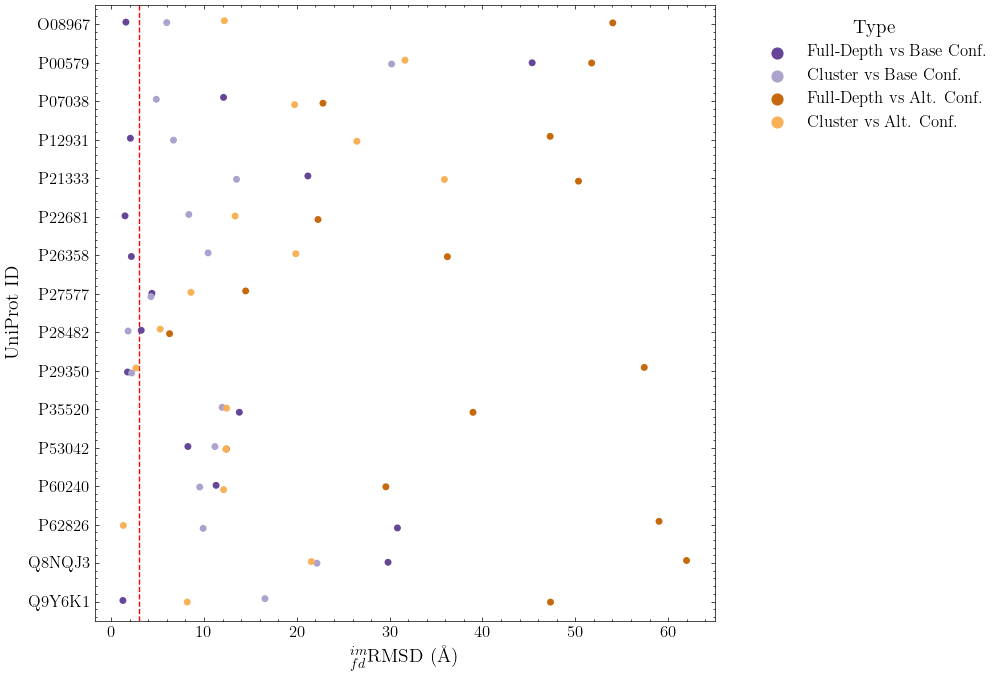

In [2212]:
fig, ax = plt.subplots(figsize=(8, 8))

markers = {'Full-Depth vs Base Conf.': 'o', 'Cluster vs Base Conf.': 'o', 'Full-Depth vs Alt. Conf.': 's', 'Cluster vs Alt. Conf.': 's'}

sns.stripplot(y='UniProt', x=imfd, data=best_both_confs, hue='Type', ax=ax, palette=conf_palette,
                )
ax.set_xlabel('$_{fd}^{im}$RMSD (\AA)', fontsize=14)
ax.set_ylabel('UniProt ID', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.axvline(x=3, color='r', linestyle='--')
ax.legend(title='Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1))

plt.savefig('./project_pipeline/data/figures/paper/two_confs_plot.png', dpi=300, bbox_inches='tight')

In [2213]:
best_both_confs_grmsd[best_both_confs_grmsd['UniProt'] == 'P12931']

,UniProt,PDB,gRMSD,$_{fd}^{im}$RMSD,bin,bin_id,Type
3,P12931,4k11,1.254,2.074,0.0,P12931_0.0,Full-Depth vs Base Conf.
19,P12931,1ksw,3.798,12.614,0.0,P12931_0.0,Cluster vs Base Conf.
47,P12931,1y57,24.076,47.288,15.0,P12931_15.0,Full-Depth vs Alt. Conf.
63,P12931,1y57,15.573,30.454,15.0,P12931_15.0,Cluster vs Alt. Conf.


/tmp/ipykernel_2466124/441326232.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


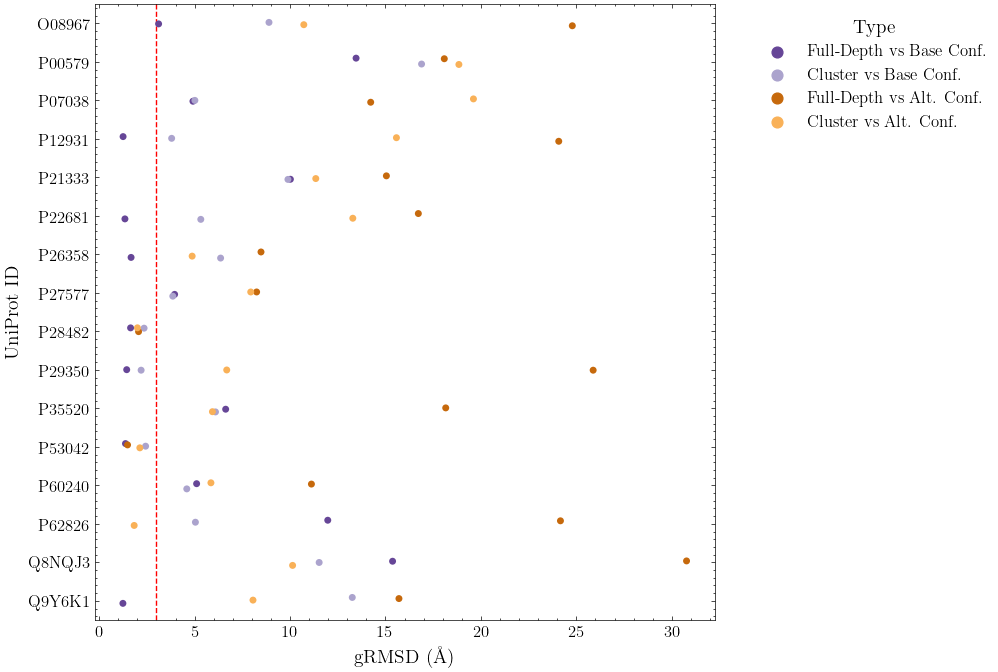

In [2214]:
fig, ax = plt.subplots(figsize=(8, 8))

markers = {'Full-Depth vs Base Conf.': 'o', 'Cluster vs Base Conf.': 'o', 'Full-Depth vs Alt. Conf.': 's', 'Cluster vs Alt. Conf.': 's'}

sns.stripplot(y='UniProt', x='gRMSD', data=best_both_confs_grmsd, hue='Type', ax=ax, palette=conf_palette,
                )
ax.set_xlabel('gRMSD (\AA)', fontsize=14)
ax.set_ylabel('UniProt ID', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.axvline(x=3, color='r', linestyle='--')
ax.legend(title='Type', title_fontsize='14', fontsize='12', bbox_to_anchor=(1.05, 1))

plt.savefig('./project_pipeline/data/figures/paper/two_confs_grmsd_plot.png', dpi=300, bbox_inches='tight')

In [506]:
accurate_clusts = clust_bins[clust_bins['Cluster gRMSD'] <= 3]
accurate_fd = clust_bins[clust_bins['FD gRMSD'] <= 3]
accurate_both = pd.concat([accurate_clusts, accurate_fd]).drop_duplicates().reset_index(drop=True)
accurate_both.groupby('UniProt')['bin'].nunique()

UniProt
P12931    2
P22681    1
P26358    1
P28482    2
P29350    1
P53042    2
P62826    1
Q9Y6K1    1
Name: bin, dtype: int64

In [507]:
accurate_fd.sort_values('FD gRMSD').groupby(['UniProt', 'bin']).first().reset_index()

,UniProt,bin,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state
0,P12931,0.0,4k11,1.254,2.074,Autoinhibitory,P12931_0.0,U100-003,3.758,6.714,Autoinhibited,P12931_Autoinhibited
1,P12931,1.0,2src,1.693,5.354,Autoinhibitory,P12931_1.0,U100-003,3.821,12.483,Autoinhibited,P12931_Autoinhibited
2,P22681,0.0,4a49,1.351,1.498,Autoinhibitory,P22681_0.0,U100-003,5.325,8.563,Active,P22681_Active
3,P26358,0.0,4wxx,1.673,2.180,Autoinhibitory,P26358_0.0,U100-004,6.813,10.444,Autoinhibited,P26358_Autoinhibited
4,P28482,0.0,3tei,1.647,3.565,Autoinhibitory,P28482_0.0,281,3.005,3.330,Autoinhibited,P28482_Autoinhibited
5,P28482,1.0,5nhp,2.060,6.410,Autoinhibitory,P28482_1.0,U10-009,2.472,5.712,Autoinhibited,P28482_Autoinhibited
6,P29350,0.0,3ps5,1.444,1.765,Autoinhibitory,P29350_0.0,U100-007,2.199,2.209,Active,P29350_Active
7,P53042,0.0,4ja9,1.488,8.268,Autoinhibitory,P53042_0.0,U100-000,2.132,11.179,Active,P53042_Active
8,P53042,1.0,4ja7,1.380,12.407,Autoinhibitory,P53042_1.0,044,3.065,12.354,Autoinhibited,P53042_Autoinhibited
9,Q9Y6K1,0.0,4u7t,1.245,1.268,Autoinhibitory,Q9Y6K1_0.0,U100-004,15.648,16.568,Active,Q9Y6K1_Active


In [508]:
accurate_clusts.sort_values('Cluster gRMSD').groupby(['UniProt', 'bin']).first().reset_index()

,UniProt,bin,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Type,bin_id,Cluster,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,prot_state
0,P12931,1.0,7yqe,2.092,6.031,Autoinhibitory,P12931_1.0,U10-007,1.402,2.585,Autoinhibited,P12931_Autoinhibited
1,P28482,0.0,5v60,2.003,6.093,Autoinhibitory,P28482_0.0,U100-004,1.997,1.929,Autoinhibited,P28482_Autoinhibited
2,P28482,1.0,6slg,2.065,6.293,Autoinhibitory,P28482_1.0,U10-009,2.006,5.284,Autoinhibited,P28482_Autoinhibited
3,P29350,0.0,3ps5,1.444,1.765,Autoinhibitory,P29350_0.0,U100-007,2.199,2.209,Active,P29350_Active
4,P53042,0.0,4ja9,1.488,8.268,Autoinhibitory,P53042_0.0,U100-000,2.132,11.179,Active,P53042_Active
5,P62826,9.0,5cit,21.438,58.062,Autoinhibitory,P62826_9.0,096,1.887,1.466,Autoinhibited,P62826_Autoinhibited


In [509]:
best_two_conf = best[best['two_conf'] == True]

# Let's bin all of the conformations. So divide up the FD gRMSD into bins based on 3 angstroms



In [2215]:
best_grmsd = best.sort_values('FD $_{fd}^{im}$RMSD').groupby(['UniProt', 'state']).head(1)
best_imfd = best.sort_values('FD $_{fd}^{im}$RMSD').groupby(['UniProt', 'state']).head(1)

best_grmsd.sort_values('UniProt')

,PDB,Cluster,UniProt,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,state,conformation,FD gRMSD,FD $_{fd}^{im}$RMSD
305,7bfl,U10-006,B5XAZ0,2.450,0.767,Autoinhibited,Closed,2.591,0.807
255,6lol,U10-005,D2AJU0,7.466,9.835,Autoinhibited,Closed,3.539,7.860
228,6bbp,U100-004,O08967,13.809,15.237,Active,Closed,24.061,51.878
35,2r09,005,O08967,15.556,6.143,Autoinhibited,Closed,3.179,1.593
200,5u6p,U10-004,O60741,21.302,21.721,Active,Closed,1.182,1.290
199,5u6o,U10-003,O60741,23.197,21.264,Autoinhibited,Closed,1.516,2.148
61,3lfv,U100-004,O76074,7.663,5.267,Autoinhibited,Closed,3.163,3.791
12,1opk,U10-006,P00520,25.012,31.702,Autoinhibited,Closed,1.679,1.654
34,2ptk,014,P00523,6.073,16.925,Autoinhibited,Closed,1.737,3.093
134,4llg,U10-002,P00579,29.770,31.666,Active,Open,13.459,45.352


In [2216]:
two_conf_clust = min_clust[min_clust['UniProt'].isin(two_conf_prots)]
cl_pdbs = two_conf_clust['PDB'].unique().tolist()
two_conf_clust.shape

(16, 24)

Get the best clusters for the full-depth PDBs

In [2217]:
match_fd = clust[clust['PDB'].isin(fd_pdbs)]

# Get the minimum of them
min_match_fd = match_fd.groupby('UniProt')[imfd].min()
min_match_fd = pd.merge(min_match_fd, match_fd, on=['UniProt', imfd], how='inner')

# Clean up the columns
min_match_fd = min_match_fd[['UniProt', 'PDB', imfd, 'gRMSD']]

base_match_fd = minimum_cl.rename(columns={imfdd1d2: imfd, imd1: im, fdd2: fd})

base_match_fd = base_match_fd[['UniProt', 'PDB', imfd, 'gRMSD']]

match = pd.merge(base_match_fd, min_match_fd, on=['UniProt', 'PDB'], how='inner')

state_df = cl[['uniprot', 'pdb', 'state']]
state_df = state_df.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
match = pd.merge(match, state_df, on=['UniProt', 'PDB'], how='left')
match['best_fd'] = True
match.head()

,UniProt,PDB,$_{fd}^{im}$RMSD_x,gRMSD_x,$_{fd}^{im}$RMSD_y,gRMSD_y,state,best_fd
0,O08967,2r0d,1.619,3.115,5.99,15.676,Autoinhibited,True
1,P07038,7nxf,12.107,4.914,4.866,5.25,Autoinhibited,True
2,P21333,2j3s,21.192,10.018,13.504,14.661,Autoinhibited,True
3,P26358,4wxx,2.180,1.673,10.444,6.813,Autoinhibited,True
4,P27577,1r36,4.394,3.953,4.294,3.859,Autoinhibited,True


In [2218]:
match_cl = cl[cl['pdb'].isin(cl_pdbs)]

# There's only one predicted structure here so we don't have to find the minimums

match_cl = match_cl.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', '2_comp': imfd, 'complex_rmsd': 'gRMSD'})
match_cl = match_cl[['UniProt', 'PDB', imfd, 'gRMSD']]

base_cl = two_conf_clust[['UniProt', 'PDB', imfd, 'gRMSD']]

match2 = pd.merge(match_cl, base_cl, on=['UniProt', 'PDB'], how='inner')
match2 = pd.merge(match2, state_df, on=['UniProt', 'PDB'], how='left')
match2['best_clust'] = True
match2.shape

(16, 8)

In [2219]:
best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',
                                            'gRMSD_y', f'{imfd}_y', 'state'], how='outer')
best_matches = best_matches.fillna(False)
best_matches.columns = ['UniProt', 'PDB', 'FD $_{fd}^{im}$RMSD', 'FD gRMSD',
                        'Cluster $_{fd}^{im}$RMSD', 'Cluster gRMSD', 'Experimental State', 'Is Best Full-Depth',
                        'Is Best Cluster']
cols = best_matches.columns.tolist()

cols = ['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'Cluster gRMSD', 'Cluster $_{fd}^{im}$RMSD',
        'Experimental State', 'Is Best Full-Depth', 'Is Best Cluster']
best_matches = best_matches[cols]
best_matches.sort_values('UniProt')

/tmp/ipykernel_2466124/1153482066.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',
/tmp/ipykernel_2466124/1153482066.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  best_matches = pd.merge(match, match2, on=['UniProt', 'PDB', 'gRMSD_x', f'{imfd}_x',


,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,Experimental State,Is Best Full-Depth,Is Best Cluster
0,O08967,2r0d,3.115,1.619,15.676,5.990,Autoinhibited,True,False
19,O08967,2r0d,3.115,1.619,8.897,8.351,Autoinhibited,False,True
10,P00579,4lk1,13.988,46.737,16.681,47.353,Active,False,True
8,P07038,7nxf,4.914,12.107,5.015,7.087,Autoinhibited,False,True
1,P07038,7nxf,4.914,12.107,5.250,4.866,Autoinhibited,True,False
13,P12931,7yqe,2.092,6.031,1.402,2.585,Autoinhibited,False,True
15,P21333,2j3s,10.018,21.192,9.890,21.107,Autoinhibited,False,True
2,P21333,2j3s,10.018,21.192,14.661,13.504,Autoinhibited,True,False
14,P22681,4a49,1.351,1.498,5.325,8.563,Active,False,True
3,P26358,4wxx,1.673,2.180,6.813,10.444,Autoinhibited,True,False


In [2220]:
best_matches[(best_matches['Is Best Full-Depth'] == True) & (best_matches['Is Best Cluster'] == True)]

,UniProt,PDB,FD gRMSD,FD $_{fd}^{im}$RMSD,Cluster gRMSD,Cluster $_{fd}^{im}$RMSD,Experimental State,Is Best Full-Depth,Is Best Cluster
4,P27577,1r36,3.953,4.394,3.859,4.294,Autoinhibited,True,True
5,P29350,3ps5,1.444,1.765,2.199,2.209,Active,True,True
7,P60240,7m8e,5.106,11.303,4.591,9.540,Active,True,True


## Comparing performances of AF2, AF3, and the trimmed AF2/AF3

### Preparing the data

In [2221]:
def sort_by_cutoff(df, method): 
    '''
    This function takes an unsorted dataframe, gets the best gRMSD fit per protein,
    and then sorts it into four dataframes based on accuracy and cutoffs. It also takes
    a method name to add to the 'Method' column.
    '''

    best_grmsd = df.sort_values('gRMSD').groupby('UniProt').first().reset_index()

    accurate_five = best_grmsd[best_grmsd['gRMSD'] <= 5]
    inaccurate_five = best_grmsd[best_grmsd['gRMSD'] > 5]

    accurate_three = best_grmsd[best_grmsd['gRMSD'] <= 3]
    inaccurate_three = best_grmsd[best_grmsd['gRMSD'] > 3]

    accurate_five['Accuracy'] = 'Accurate'
    inaccurate_five['Accuracy'] = 'Inaccurate'
    accurate_five['Method'] = f'{method} (5 Å)'
    inaccurate_five['Method'] = f'{method} (5 Å)'

    accurate_three['Accuracy'] = 'Accurate'
    inaccurate_three['Accuracy'] = 'Inaccurate'
    accurate_three['Method'] = f'{method} (3 Å)'
    inaccurate_three['Method'] = f'{method} (3 Å)'

    acc = pd.concat([accurate_five, inaccurate_five, accurate_three, inaccurate_three])

    return acc

In [2222]:
proteinsa = best_conf_one['UniProt'].unique().tolist()

In [2223]:
# Autoinhibitory AF2 trimmed
af2t = pd.read_csv('./project_pipeline/data/jp_data/rmsds_all_trimmed_af2_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
ai_pdbs = cl['pdb'].tolist()
af2t = af2t[af2t['PDB'].isin(ai_pdbs)]
af2t = af2t.sort_values('gRMSD').groupby('UniProt').first().reset_index()

af2t_melt = melt_rmsd_df(af2t, 'AI (AF2T)')

# Autoinhibitory AF3 trimmed
af3t = pd.read_csv('./project_pipeline/data/jp_data/rmsds_all_trimmed_af3_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
af3t = af3t[af3t['PDB'].isin(ai_pdbs)]
af3t = af3t.sort_values('gRMSD').groupby('UniProt').first().reset_index()

af3t_melt = melt_rmsd_df(af3t, 'AI (AF3T)')

# Autoinhibitory AF3 non-trimmed
af3_all = pd.read_csv('./project_pipeline/data/jp_data/rmsds_all_af3_best.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])

af3_all = af3_all[af3_all['PDB'].isin(ai_pdbs)]
af3_all = af3_all.sort_values('gRMSD').groupby('UniProt').first().reset_index()

af3_melt = melt_rmsd_df(af3_all, 'AI (AF3)')

# Two-domain AF2 trimmed
td_af2t = pd.read_csv('./project_pipeline/data/jp_data/rmsds_two_domain_trimmed_af2_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
md_pdbs = md['PDB'].tolist()
td_af2t = td_af2t[td_af2t['PDB'].isin(md_pdbs)]
td_af2t = td_af2t.sort_values('gRMSD').groupby('UniProt').first().reset_index()

td_af2t_melt = melt_rmsd_df(td_af2t, 'TD (AF2T)')

# Two-domain AF3 trimmed
td_af3t = pd.read_csv('./project_pipeline/data/jp_data/rmsds_two_domain_trimmed_af3_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
td_af3t = td_af3t[td_af3t['PDB'].isin(md_pdbs)]
td_af3t = td_af3t.sort_values('gRMSD').groupby('UniProt').first().reset_index()

td_af3t_melt = melt_rmsd_df(td_af3t, 'TD (AF3T)')

# Cluster AF2, trimmed
clust_af2t = pd.read_csv('./project_pipeline/data/af2t_ai_pdb_cluster_compared.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      [['UniProt', 'PDB', imd1, fdd2, imfdd1d2, 
                                                                                                                        'cluster', 'gRMSD']]
clust_af2t_min = clust_af2t.sort_values('gRMSD').groupby('UniProt').first().reset_index()
clust_af2t_min['Type'] = 'AI Cluster (AF2T)'

clust_af2t_melt = pd.melt(clust_af2t_min, id_vars=['UniProt', 'PDB', 'Type', 'cluster'], var_name='Alignment', value_name='RMSD')
clust_af2t_melt['RMSD'] = clust_af2t_melt['RMSD'].astype(float)

# Melt minimum cl
minimum_ai = minimum_cl.copy()
minimum_ai['Type'] = 'AI Full Depth'

minimum_ai_melt = pd.melt(minimum_ai, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
minimum_ai_melt['RMSD'] = minimum_ai_melt['RMSD'].astype(float)

# Melt minimum MD
minimum_td = minimum_md.copy()
minimum_td['Type'] = 'TD (AF2)'

minimum_md_melt = pd.melt(minimum_td, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
minimum_md_melt['RMSD'] = minimum_md_melt['RMSD'].astype(float)

# Melt TD clust
td_clust = mdto_plot_clust.copy()
td_clust = td_clust[['UniProt', imd1, fdd2, imfdd1d2, 'gRMSD', 'PDB']]
td_clust_melt = melt_rmsd_df(td_clust, 'TD Cluster (AF2)')

# Melt obli
obli_plot = obli_md.copy()
obli_plot['Type'] = 'Obligate (AF2)'
obli_plot = pd.melt(obli_plot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
obli_plot['RMSD'] = obli_plot['RMSD'].astype(float)

# Turn into plots

plot_af2t = pd.concat([af2t_melt, td_af2t_melt])
plot_af3t = pd.concat([af3t_melt, td_af3t_melt])
plot_af3 = pd.concat([af3_melt, minimum_md_melt])
plot_af2t_clust = pd.concat([clust_af2t_melt, minimum_ai_melt])

In [2224]:
# Disordered IMs removed
dis_cl2 = dis_cl.copy()
dis_cl2['Type'] = 'AI (AF2)'
dis_cl2_melt = pd.melt(dis_cl2, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

dis_af3_melt = af3_melt[af3_melt['UniProt'].isin(dis_uniprots)]
dis_af3_melt['UniProt'].nunique()

plot_af3_af2_ordered_im = pd.concat([dis_cl2_melt, dis_af3_melt, minimum_md_melt])

# Multi-conformation vs single conformation
af3_multi_conf = af3_all[af3_all['UniProt'].isin(ming3uniprots)].reset_index(drop=True).rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})
af3_multi_conf['Type'] = 'Multi-Conformation (AF3)'
af3_single_conf = af3_all[~af3_all['UniProt'].isin(ming3uniprots)].reset_index(drop=True).rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})
af3_single_conf['Type'] = 'Single Conformation (AF3)'

af3_multi_conf_melt = pd.melt(af3_multi_conf, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
af3_single_conf_melt = pd.melt(af3_single_conf, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Fix AF2 data
min_g3['Type'] = 'Multi-Conformation (AF2)'
min_g3_melt = pd.melt(min_g3, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

min_ss['Type'] = 'Single Conformation (AF2)'
min_ss = min_ss.rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})
min_ss_melt = pd.melt(min_ss, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

plot_conformations = pd.concat([min_g3_melt, min_ss_melt, af3_multi_conf_melt, af3_single_conf_melt])
plot_conformations.head()

,UniProt,PDB,Type,Alignment,RMSD
0,A0A0R4I961,6gtv,Multi-Conformation (AF2),$_{fd}^{im}$RMSD,1.135
1,O00571,7liu,Multi-Conformation (AF2),$_{fd}^{im}$RMSD,1.984
2,O08967,2r09,Multi-Conformation (AF2),$_{fd}^{im}$RMSD,1.593
3,P00579,4llg,Multi-Conformation (AF2),$_{fd}^{im}$RMSD,45.352
4,P07038,7nxf,Multi-Conformation (AF2),$_{fd}^{im}$RMSD,12.107


In [2225]:
# Two-state proteins, AF3 with partners/ptms
af3_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_two_state_proteins.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp',
                                                                                                                                     'prot_state'])
af3_2s_min = af3_2s.sort_values('gRMSD').groupby('UniProt').first().reset_index()
af3_2s_melt = melt_rmsd_df(af3_2s_min, 'AI 2S (AF3)')

# Two-state proteins, AF3 trimmed
af3t_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_twostate_trimmed_AF3_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
af3t_2s_min = af3t_2s.sort_values('gRMSD').groupby('UniProt').first().reset_index()
af3t_2s_melt = melt_rmsd_df(af3t_2s_min, 'AI 2S (AF3T)')

# Two-state proteins, AF2 trimmed
af2t_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_new_two_state_trimmed.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
af2t_2s_min = af2t_2s.sort_values('gRMSD').groupby('UniProt').first().reset_index()
af2t_2s_melt = melt_rmsd_df(af2t_2s_min, 'AI 2S (AF2T)')

# Cfold
cfold = pd.read_csv('./project_pipeline/data/jp_data/rmsds_cfold_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
cfold_melt = melt_rmsd_df(cfold, 'AI 2S (CFold)')

# Cfold trimmed
cfoldt = pd.read_csv('./project_pipeline/data/jp_data/rmsds_cfold_trimmed_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                      '1_aligned': imd1, '2_aligned': fdd2, 
                                                                                                                      '2_comp': imfdd1d2, 'complex_rmsd': 'gRMSD'}) \
                                                                                                                      .drop(columns=['region_1', 'region_2', '1_comp'])
cfoldt_melt = melt_rmsd_df(cfoldt, 'AI 2S (CFold T)')


plot_af3_2s = pd.concat([af3_2s_melt, minimum_md_melt])
plot_af3t_2s = pd.concat([af3t_2s_melt, td_af3t_melt])
plot_af2t_2s = pd.concat([af2t_2s_melt, td_af2t_melt])
plot_cfold = pd.concat([cfold_melt, minimum_md_melt])
plot_cfoldt = pd.concat([cfoldt_melt, td_af2t_melt])

### RMSDs of AI AF2 Trimmed & TD AF2 Trimmed

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF2T) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.775e-06 U_stat=3.670e+03
gRMSD_AI (AF2T) vs. gRMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.567e-05 U_stat=3.552e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF2T) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.197e-07 U_stat=3.804e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF2T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.561e-02 U_stat=3.063e+03


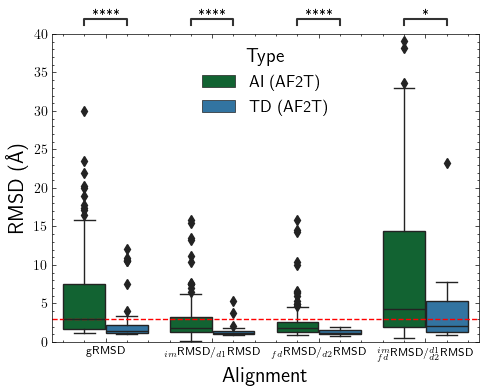

In [2895]:
plot_rmsds(plot_af2t, 'AI (AF2T)', 'TD (AF2T)', colors)

plt.savefig('./project_pipeline/data/figures/paper/trimmed_af2_rmsd.png', bbox_inches='tight', dpi=1200)

### RMSDs of AI AF3 Trimmed & TD AF3 Trimmed

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF3T) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:6.349e-08 U_stat=3.863e+03
gRMSD_AI (AF3T) vs. gRMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.779e-04 U_stat=3.432e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF3T) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.474e-06 U_stat=3.709e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:8.440e-03 U_stat=3.144e+03


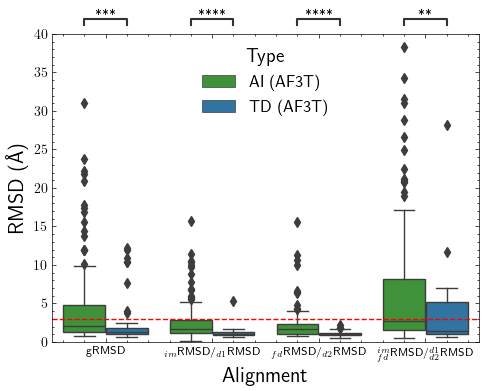

In [2896]:
plot_rmsds(plot_af3t, 'AI (AF3T)', 'TD (AF3T)', colors)

plt.savefig('./project_pipeline/data/figures/paper/trimmed_af3_rmsd.png', bbox_inches='tight', dpi=1200)

### RMSDs of AF3 AI & TD AF2

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF3) vs. $_{im}$RMSD/$_{d1}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:9.771e-03 U_stat=6.815e+02
gRMSD_AI (AF3) vs. gRMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.941e-04 U_stat=7.820e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF3) vs. $_{fd}$RMSD/$_{d2}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:5.088e-04 U_stat=7.680e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.397e-03 U_stat=7.150e+02


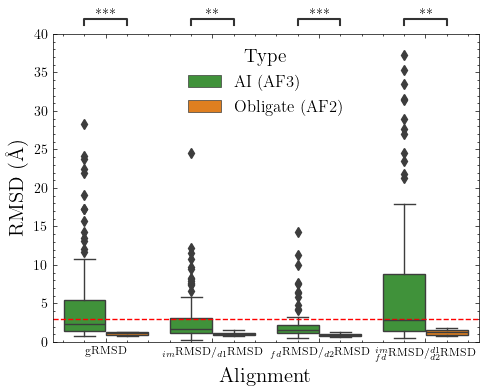

In [2228]:
plot_rmsds(plot_af3_obli, 'AI (AF3)', 'Obligate (AF2)', colors)
plt.savefig('./project_pipeline/data/figures/paper/af3_obli_rmsd.png', bbox_inches='tight', dpi=500)

### RMSDs of Two-State AF3 & TD AF2

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI 2S (AF3) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:9.326e-04 U_stat=5.030e+02
gRMSD_AI 2S (AF3) vs. gRMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:8.992e-02 U_stat=4.140e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI 2S (AF3) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.928e-03 U_stat=4.795e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI 2S (AF3) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:7.723e-02 U_stat=3.940e+02


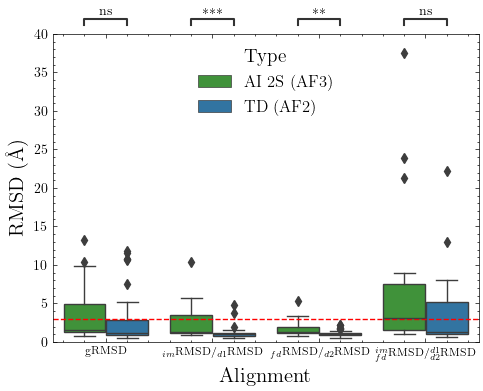

In [2229]:
plot_rmsds(plot_af3_2s, 'AI 2S (AF3)', 'TD (AF2)', colors)

### RMSDs of Two-State AF3 Trimmed & TD AF3 Trimmed

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI 2S (AF3T) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:4.282e-03 U_stat=4.780e+02
gRMSD_AI 2S (AF3T) vs. gRMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.572e-01 U_stat=3.985e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI 2S (AF3T) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.394e-02 U_stat=4.450e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI 2S (AF3T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.346e-01 U_stat=4.030e+02


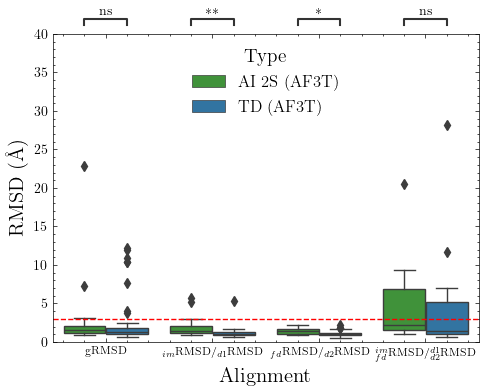

In [2230]:
plot_rmsds(plot_af3t_2s, 'AI 2S (AF3T)', 'TD (AF3T)', colors)

### RMSDs of Two-State AF2, Trimmed & TD AF2 Trimmed

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI 2S (AF2T) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.698e-01 U_stat=2.460e+02
gRMSD_AI 2S (AF2T) vs. gRMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.490e-01 U_stat=2.600e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI 2S (AF2T) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.944e-01 U_stat=2.540e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI 2S (AF2T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:8.729e-02 U_stat=2.710e+02


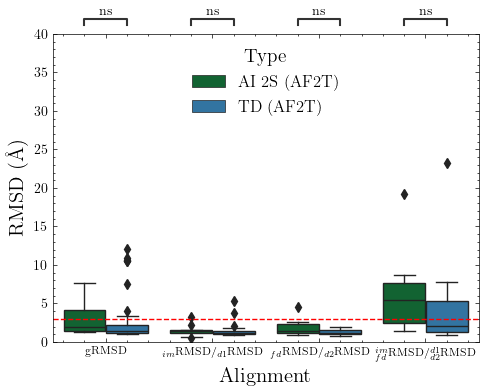

In [2231]:
plot_rmsds(plot_af2t_2s, 'AI 2S (AF2T)', 'TD (AF2T)', colors)

### RMSDs of Two-State Cfold & TD AF2

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI 2S (CFold) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:4.977e-08 U_stat=5.890e+02
gRMSD_AI 2S (CFold) vs. gRMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.738e-07 U_stat=5.770e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI 2S (CFold) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.884e-08 U_stat=5.980e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI 2S (CFold) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:5.923e-05 U_stat=5.130e+02


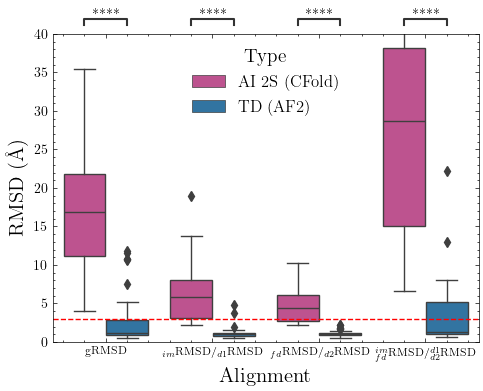

In [2232]:
plot_rmsds(plot_cfold, 'AI 2S (CFold)', 'TD (AF2)', colors)

### RMSDs of Two-State CFold Trimmed & TD AF2T

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI 2S (CFold T) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:6.832e-08 U_stat=5.860e+02
gRMSD_AI 2S (CFold T) vs. gRMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.358e-07 U_stat=5.740e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI 2S (CFold T) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.514e-08 U_stat=6.000e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI 2S (CFold T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:5.923e-05 U_stat=5.130e+02


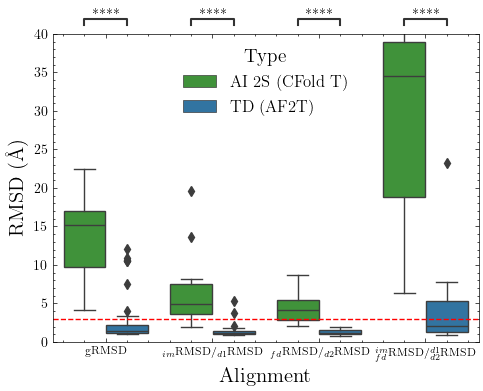

In [2233]:
plot_rmsds(plot_cfoldt, 'AI 2S (CFold T)', 'TD (AF2T)', colors)

### RMSDs of AI Cluster AF2 Trimmed & TD Cluster AF2

/tmp/ipykernel_2466124/2997063109.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI Cluster (AF2T) vs. $_{im}$RMSD/$_{d1}$RMSD_AI Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.504e-02 U_stat=1.377e+03
gRMSD_AI Cluster (AF2T) vs. gRMSD_AI Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:2.473e-01 U_stat=1.206e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI Cluster (AF2T) vs. $_{fd}$RMSD/$_{d2}$RMSD_AI Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:1.226e-02 U_stat=1.418e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Cluster (AF2T) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI Full Depth: Mann-Whitney-Wilcoxon test two-sided, P_val:4.733e-02 U_stat=1.336e+03


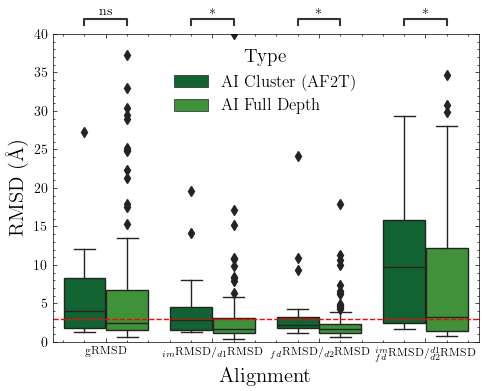

In [2234]:
plot_rmsds(plot_af2t_clust, 'AI Cluster (AF2T)', 'AI Full Depth', colors)

### RMSDs of AF3 AI vs AF2 AI vs TD

In [2577]:
af3_melt['UniProt'].nunique()

123

/tmp/ipykernel_2466124/1630473724.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF3) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:6.846e-08 U_stat=3.860e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF2) vs. $_{fd}$RMSD/$_{d2}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:6.898e-01 U_stat=8.102e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF3) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:7.458e-08 U_stat=3.856e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF2) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:8.722e-01 U_stat=7.965e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.196e-03 U_stat=3.225e+03
gRMSD_AI (AF2) vs. gRMSD_AI (AF3): Mann-Whitney-Wilcoxon t

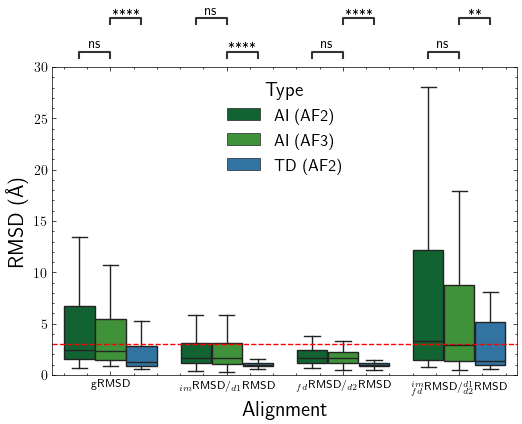

In [2848]:
minimum_ai_melt['Type'] = 'AI (AF2)'
plot_af3_af2_td = pd.concat([minimum_ai_melt, af3_melt, minimum_md_melt])

type1 = 'AI (AF2)'
type2 = 'AI (AF3)'
type3 = 'TD (AF2)'

subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_af3_af2_td, x='Alignment', y='RMSD', ax=ax, palette=colors3, hue='Type', order=subcat_order, fliersize=0)
ax.set_ylim(0, 30)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', type1), ('gRMSD', type2)],
         [('gRMSD', type2), ('gRMSD', type3)],
        [(imd1, type1), (imd1, type2)],
        [(imd1, type2), (imd1, type3)],
        [(fdd2, type1), (fdd2, type2)],
        [(fdd2, type2), (fdd2, type3)],
        [(imfdd1d2, type1), (imfdd1d2, type2)],
        [(imfdd1d2, type2), (imfdd1d2, type3)]]
annotator = Annotator(ax, pairs, data=plot_af3_af2_td, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/all_untrimmed.png', dpi=1200, bbox_inches='tight')


### RMSDs of AF3 AI vs AF2 AI vs Obligate AF2

/tmp/ipykernel_2466124/2956332310.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF3) vs. $_{im}$RMSD/$_{d1}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:9.771e-03 U_stat=6.815e+02
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF2) vs. $_{fd}$RMSD/$_{d2}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:6.898e-01 U_stat=8.102e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF3) vs. $_{fd}$RMSD/$_{d2}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:5.088e-04 U_stat=7.680e+02
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF2) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:8.722e-01 U_stat=7.965e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_Obligate (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.397e-03 U_stat=7.150e+02
gRMSD_AI (AF2) vs. gRMSD_AI (AF3): Mann-

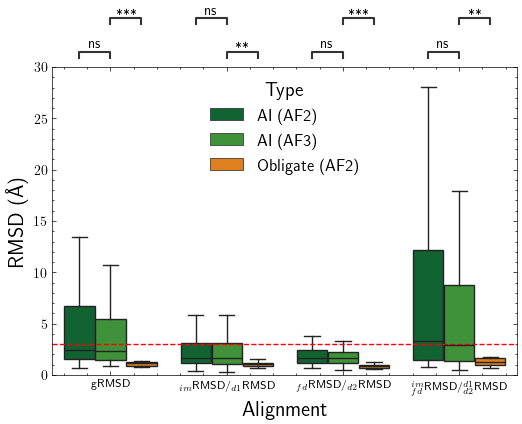

In [2891]:
minimum_ai_melt['Type'] = 'AI (AF2)'
plot_af3_af2_td = pd.concat([minimum_ai_melt, af3_melt, obli_plot])

type1 = 'AI (AF2)'
type2 = 'AI (AF3)'
type3 = 'Obligate (AF2)'

subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_af3_af2_td, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order, fliersize=0)
ax.set_ylim(0, 30)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', type1), ('gRMSD', type2)],
         [('gRMSD', type2), ('gRMSD', type3)],
        [(imd1, type1), (imd1, type2)],
        [(imd1, type2), (imd1, type3)],
        [(fdd2, type1), (fdd2, type2)],
        [(fdd2, type2), (fdd2, type3)],
        [(imfdd1d2, type1), (imfdd1d2, type2)],
        [(imfdd1d2, type2), (imfdd1d2, type3)]]
annotator = Annotator(ax, pairs, data=plot_af3_af2_td, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/all_untrimmed_obli.png', dpi=1200, bbox_inches='tight')


### RMSDs of Structured IM AF2 and AF3 AI with AF2 TD

/tmp/ipykernel_2466124/1082901611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{im}$RMSD/$_{d1}$RMSD_AI (AF3) vs. $_{im}$RMSD/$_{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:8.403e-07 U_stat=3.098e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF2) vs. $_{fd}$RMSD/$_{d2}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:8.070e-01 U_stat=5.408e+03
$_{fd}$RMSD/$_{d2}$RMSD_AI (AF3) vs. $_{fd}$RMSD/$_{d2}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.606e-07 U_stat=3.146e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF2) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:9.711e-01 U_stat=5.286e+03
$_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_AI (AF3) vs. $_{fd}^{im}$RMSD/$_{d2}^{d1}$RMSD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.050e-02 U_stat=2.580e+03
gRMSD_AI (AF2) vs. gRMSD_AI (AF3): Mann-Whitney-Wilcoxon t

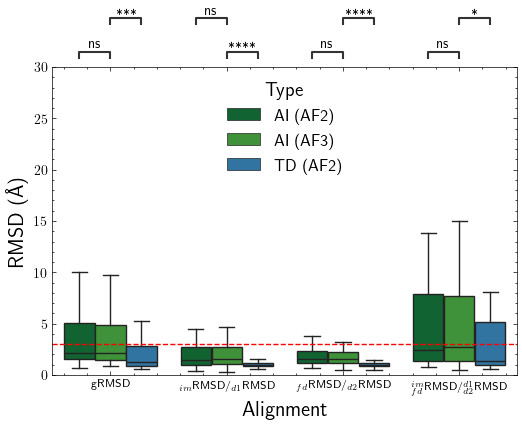

In [2892]:
type1 = 'AI (AF2)'
type2 = 'AI (AF3)'
type3 = 'TD (AF2)'

subcat_order = ['gRMSD', imd1, fdd2, imfdd1d2]

# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_af3_af2_ordered_im, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type', order=subcat_order, fliersize=0)
ax.set_ylim(0, 30)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', type1), ('gRMSD', type2)],
         [('gRMSD', type2), ('gRMSD', type3)],
        [(imd1, type1), (imd1, type2)],
        [(imd1, type2), (imd1, type3)],
        [(fdd2, type1), (fdd2, type2)],
        [(fdd2, type2), (fdd2, type3)],
        [(imfdd1d2, type1), (imfdd1d2, type2)],
        [(imfdd1d2, type2), (imfdd1d2, type3)]]
annotator = Annotator(ax, pairs, data=plot_af3_af2_ordered_im, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/structured_af3_af2.png', dpi=1200, bbox_inches='tight')


In [2935]:
plot_conformations['Type'].value_counts()

Single Conformation (AF2)    396
Single Conformation (AF3)    376
Multi-Conformation (AF2)     116
Multi-Conformation (AF3)     116
Name: Type, dtype: int64

### RMSDs of Multi vs Single Conformation AI, AF3 & AF2

/tmp/ipykernel_2466124/917277576.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{fd}$RMSD_Multi-Conformation (AF3) vs. $_{fd}$RMSD_Single Conformation (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.070e-01 U_stat=1.092e+03
$_{fd}^{im}$RMSD_Multi-Conformation (AF2) vs. $_{fd}^{im}$RMSD_Single Conformation (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:7.803e-01 U_stat=1.386e+03
$_{fd}^{im}$RMSD_Multi-Conformation (AF3) vs. $_{fd}^{im}$RMSD_Single Conformation (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:9.217e-01 U_stat=1.346e+03
$_{im}$RMSD_Multi-Conformation (AF3) vs. $_{im}$RMSD_Single Conformation (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:4.951e-01 U_stat=1.248e+03
$_{fd}$RMSD_Multi-Conformation (AF2) vs. $_{fd}$RMSD_Single Conformation (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.084e-01 U_stat=1.214e+03
gRMSD_Multi-Conformation (AF3) vs

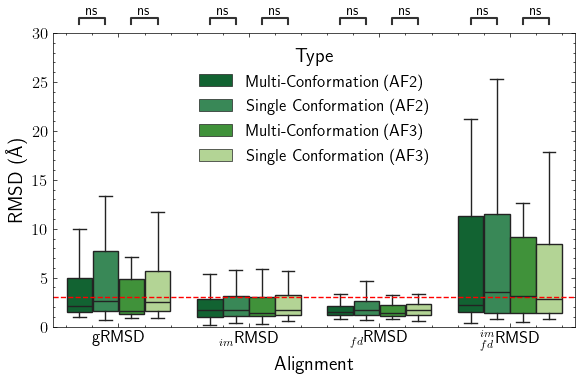

In [2932]:
typ1 = 'Multi-Conformation (AF2)'
typ2 = 'Single Conformation (AF2)'
typ3 = 'Multi-Conformation (AF3)'
typ4 = 'Single Conformation (AF3)'

subcat_order = ['gRMSD', im, fd, imfd]

# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_conformations, x='Alignment', y='RMSD', ax=ax, palette=gns, hue='Type', order=subcat_order, fliersize=0)
ax.set_ylim(0, 30)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14)

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', typ1), ('gRMSD', typ2)],
         [('gRMSD', typ3), ('gRMSD', typ4)],
         [(im, typ1), (im, typ2)],
         [(im, typ3), (im, typ4)],
         [(fd, typ1), (fd, typ2)],
         [(fd, typ3), (fd, typ4)],
         [(imfd, typ1), (imfd, typ2)],
         [(imfd, typ3), (imfd, typ4)]]
annotator = Annotator(ax, pairs, data=plot_conformations, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/af2_af3_single_vs_multi_structures.png', dpi=500, bbox_inches='tight')

## PLDDT/PAE of AF3/Trimmed

### Preparing data

In [2756]:
# PAE
# Non-homologous AF3
pae_nh3 = pd.read_csv('./project_pipeline/data/jp_data/NonF_AF3.csv', sep=';').rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 
                                                                                              'mean_pae_2_2': 'FD'}).drop(columns=['complex_mean_plddt',
                                                                                              'r1_mean_plddt', 'r2_mean_plddt', 'af_filename', 'filename',
                                                                                              'region_1', 'region_2']).reset_index(drop=True)
pae_nh3_melt = pae_nh3.melt(id_vars=['uniprot', 'status'], var_name='region', value_name='mean_pae')
pae_nh3_melt['mean_pae'] = pae_nh3_melt['mean_pae'].astype(float)
pae_nh3_melt['type'] = 'Non-Homologous \nAI (AF3)'

# Non-homologous AF2
pae_nh2 = pd.read_csv('./project_pipeline/data/jp_data/NonH_AF2.csv', sep=';').rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 
                                                                                              'mean_pae_2_2': 'FD'}).drop(columns=['complex_mean_plddt',
                                                                                              'r1_mean_plddt', 'r2_mean_plddt', 'af_filename', 'filename',
                                                                                              'region_1', 'region_2', 'interacting_residue_pairs',
                                                                                              'interface_residues']).reset_index(drop=True)
pae_nh2['IM'] = pae_nh2['IM'].str.replace(',', '.')
pae_nh2['FD'] = pae_nh2['FD'].str.replace(',', '.')
pae_nh2['IM vs FD'] = pae_nh2['IM vs FD'].str.replace(',', '.')
pae_nh2_melt = pae_nh2.melt(id_vars=['uniprot', 'status'], var_name='region', value_name='mean_pae')
pae_nh2_melt['mean_pae'] = pae_nh2_melt['mean_pae'].astype(float)
pae_nh2_melt['type'] = 'Non-Homologous \nAI (AF2)'

# Non-homologous AF3 trimmed
pae_nh3t = pd.read_csv('./project_pipeline/data/jp_data/nonh_trimmed_af3_best.csv').rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 
                                                                                              'mean_pae_2_2': 'FD'}).drop(columns=['complex_mean_plddt',
                                                                                              'r1_mean_plddt', 'r2_mean_plddt', 'af_filename',
                                                                                              'region_1', 'region_2']).reset_index(drop=True)
pae_nh3t_melt = pae_nh3t.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_nh3t_melt['mean_pae'] = pae_nh3t_melt['mean_pae'].astype(float)
pae_nh3t_melt['type'] = 'Non-Homologous \nAI (AF3T)'

# Non-homologous AF2 trimmed
pae_nh2t = pd.read_csv('./project_pipeline/data/jp_data/nonh_trimmed_af2_best.csv').rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 
                                                                                              'mean_pae_2_2': 'FD'}).drop(columns=['complex_mean_plddt',
                                                                                              'r1_mean_plddt', 'r2_mean_plddt', 'af_filename',
                                                                                              'region_1', 'region_2']).reset_index(drop=True)
pae_nh2t_melt = pae_nh2t.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').astype({'mean_pae': float})
pae_nh2t_melt['type'] = 'Non-Homologous \nAI (AF2T)'


# All AF3
pae_af3 = pd.read_csv('./project_pipeline/data/jp_data/all_af3_pae_best.csv').rename(columns={'mean_pae_1_1': 'IM/D1', 'mean_pae_1_2': 'IM vs FD/D1 vs D2', 
                                                                                              'mean_pae_2_2': 'FD/D2'}).drop(columns=['mean_plddt_complex',
                                                                                              'mean_plddt_r1', 'mean_plddt_r2', 'af_filename']).reset_index(drop=True)
pae_af3_melt = pae_af3.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_af3_melt['mean_pae'] = pae_af3_melt['mean_pae'].astype(float)
pae_af3_melt['type'] = 'Autoinhibitory (AF3)'

# AF3T
pae_af3t = pd.read_csv('./project_pipeline/data/jp_data/all_trimmed_af3_pae_best.csv').rename(columns={'mean_pae_1_1': 'IM/D1', 'mean_pae_1_2': 'IM vs FD/D1 vs D2', 
                                                                                              'mean_pae_2_2': 'FD/D2'}).drop(columns=['mean_plddt_complex',
                                                                                              'mean_plddt_r1', 'mean_plddt_r2', 'af_filename']).reset_index(drop=True)
pae_af3t_melt = pae_af3t.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_af3t_melt['mean_pae'] = pae_af3t_melt['mean_pae'].astype(float)
pae_af3t_melt['type'] = 'Autoinhibitory (AF3T)'

# AF2T 
pae_af2t = pd.read_csv('./project_pipeline/data/jp_data/all_trimmed_af2_pae_best.csv').rename(columns={'mean_pae_1_1': 'IM/D1', 'mean_pae_1_2': 'IM vs FD/D1 vs D2', 
                                                                                              'mean_pae_2_2': 'FD/D2'}).drop(columns=['mean_plddt_complex',
                                                                                              'mean_plddt_r1', 'mean_plddt_r2', 'af_filename']).reset_index(drop=True)
pae_af2t_melt = pae_af2t.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_af2t_melt['mean_pae'] = pae_af2t_melt['mean_pae'].astype(float)
pae_af2t_melt['type'] = 'Autoinhibitory (AF2T)'

# AF2 Two-state clusters, trimmed
pae_af2t_2s = pd.read_csv('./project_pipeline/data/af2t_ai_cluster_pae.tsv', sep='\t').rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 
                                                                                              'mean_pae_2_2': 'FD', 'uniprot': 'UniProt'}).drop(columns=['region_1',
                                                                                              'region_2'])
# Get the best ones
best_af2t_clusters = clust_af2t_min[['UniProt', 'cluster']]
pae_af2t_2s = pd.merge(best_af2t_clusters, pae_af2t_2s, on=['UniProt', 'cluster'], how='left')
# Melt
pae_af2t_2s_melt = pae_af2t_2s.melt(id_vars=['UniProt', 'cluster'], var_name='region', value_name='mean_pae')
pae_af2t_2s_melt['mean_pae'] = pae_af2t_2s_melt['mean_pae'].astype(float)
pae_af2t_2s_melt['type'] = 'AI Cluster (AF2T)'

# Select for only the proteins in the clusters for full-depth comparison
df_pae_melt2 = df_pae_melt2[df_pae_melt2['uniprot'].isin(pae_af2t_2s['UniProt'].unique().tolist())]
df_pae_melt2['mean_pae'] = df_pae_melt2['mean_pae'].astype(float)

# Change multi type
df_multi_melt['type'] = 'TD (AF2)'
df_multi_melt['mean_pae'] = df_multi_melt['mean_pae'].astype(float)

# Change autoinhibitory type
df_pae_melt['type'] = 'AI (AF2)'

# For AF3/AF2/TD plot, change a few things
pae_ai = df_pae.copy()
pae_ai_melt = pae_ai.rename(columns={'IM': 'IM/D1', 'FD': 'FD/D2', 'IM vs FD': 'IM vs FD/D1 vs D2'}) \
               .melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_ai_melt['mean_pae'] = pae_ai_melt['mean_pae'].astype(float)
pae_ai_melt['type'] = 'Autoinhibitory (AF2)'

pae_multi = df_multi.copy()
pae_multi_melt = pae_multi.rename(columns={'D1': 'IM/D1', 'D2': 'FD/D2', 'D1 vs D2': 'IM vs FD/D1 vs D2'}) \
               .melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
pae_multi_melt['mean_pae'] = pae_multi_melt['mean_pae'].astype(float)
pae_multi_melt['type'] = 'Two-Domain (AF2)'

# Ordered IMs only
pae_order2_melt = pae_ai_melt[pae_ai_melt['uniprot'].isin(dis_uniprots)]
pae_order3_melt = pae_af3_melt[pae_af3_melt['uniprot'].isin(dis_uniprots)]

# Plotting dataframes
plot_pae_af3 = pd.concat([pae_af3_melt, df_multi_melt])
plot_pae_af3t_af2t_td = pd.concat([pae_multi_melt, pae_af2t_melt, pae_af3t_melt])
plot_pae_af2t = pd.concat([pae_af2t_melt, df_multi_melt])
plot_pae_af2t_2s = pd.concat([df_pae_melt2, pae_af2t_2s_melt])
plot_pae_af2_af3_td = pd.concat([pae_multi_melt, pae_ai_melt, pae_af3_melt])
ordered_af2_af3_td = pd.concat([pae_multi_melt, pae_order2_melt, pae_order3_melt])
plot_pae_af2_td = pd.concat([df_pae_melt, df_multi_melt])
plot_nonh_af3_af2 = pd.concat([pae_nh2_melt, pae_nh3_melt])
plot_nonh_af3t_af2t = pd.concat([pae_nh2t_melt, pae_nh3t_melt])

In [2915]:
# pLDDT
# All AF3
pld_af3 = pd.read_csv('./project_pipeline/data/jp_data/all_af3_pae_best.csv').rename(columns={'mean_plddt_complex': 'Global AI', 'mean_plddt_r1': 'IM', 
                                                                                              'mean_plddt_r2': 'FD'}).drop(columns=['mean_pae_1_1',
                                                                                              'mean_pae_1_2', 'mean_pae_2_2', 'af_filename']).reset_index(drop=True)
pld_af3_melt = pld_af3.melt(id_vars=['uniprot'], var_name='Section', value_name='Mean pLDDT')
pld_af3_melt['Mean pLDDT'] = pld_af3_melt['Mean pLDDT'].astype(float)
pld_af3_melt['type'] = 'Autoinhibitory (AF3)'

# Structured IMs for AF3
pld_af3_struct_melt = pld_af3_melt[pld_af3_melt['uniprot'].isin(dis_uniprots)]

# AF3T
pld_af3t = pd.read_csv('./project_pipeline/data/jp_data/all_trimmed_af3_pae_best.csv').rename(columns={'mean_plddt_complex': 'Global AI', 'mean_plddt_r1': 'IM', 
                                                                                              'mean_plddt_r2': 'FD'}).drop(columns=['mean_pae_1_1',
                                                                                              'mean_pae_1_2', 'mean_pae_2_2', 'af_filename']).reset_index(drop=True)
pld_af3t_melt = pld_af3t.melt(id_vars=['uniprot'], var_name='Section', value_name='Mean pLDDT')
pld_af3t_melt['Mean pLDDT'] = pld_af3t_melt['Mean pLDDT'].astype(float)
pld_af3t_melt['type'] = 'AI (AF3T)'

# AF2T 
pld_af2t = pd.read_csv('./project_pipeline/data/jp_data/all_trimmed_af2_pae_best.csv').rename(columns={'mean_plddt_complex': 'Global AI', 'mean_plddt_r1': 'IM', 
                                                                                              'mean_plddt_r2': 'FD'}).drop(columns=['mean_pae_1_1',
                                                                                              'mean_pae_1_2', 'mean_pae_2_2', 'af_filename']).reset_index(drop=True)
pld_af2t_melt = pld_af2t.melt(id_vars=['uniprot'], var_name='Section', value_name='Mean pLDDT')
pld_af2t_melt['Mean pLDDT'] = pld_af2t_melt['Mean pLDDT'].astype(float)
pld_af2t_melt['type'] = 'AI (AF2T)'

# AF2 Clusters, trimmed
pld_af2t_2s = pd.read_csv('./project_pipeline/data/af2t_ai_cluster_pLDDT.tsv', sep='\t').rename(columns={'complex_mean_plddt': 'Global AI', 'r1_mean_plddt': 'IM', 
                                                                                              'r2_mean_plddt': 'FD', 'uniprot': 'UniProt'}).drop(columns=[
                                                                                                'Unnamed: 0', 'region_1', 'region_2', 'af_filename', 'chain',
                                                                                                'cf_filename', 'pdb'
                                                                                              ]).drop_duplicates().reset_index(drop=True)
# Get the best ones
pld_af2t_2s = pd.merge(best_af2t_clusters, pld_af2t_2s, on=['UniProt', 'cluster'], how='left')
# Melt
pld_af2t_2s_melt = pld_af2t_2s.melt(id_vars=['UniProt', 'cluster'], var_name='Section', value_name='Mean pLDDT')
pld_af2t_2s_melt['Mean pLDDT'] = pld_af2t_2s_melt['Mean pLDDT'].astype(float)
pld_af2t_2s_melt['type'] = 'AI Cluster (AF2T)'
# Select for only the proteins in the clusters for full-depth comparison
bestclAuto_p = bestclAuto_p[bestclAuto_p['uniprot'].isin(pld_af2t_2s['UniProt'].unique().tolist())]
bestclAuto_p['Mean pLDDT'] = bestclAuto_p['Mean pLDDT'].astype(float)
bestclAuto_p['type'] = 'AI Full Depth'

# Change multi type
afMulti_p['type'] = 'Two-Domain (AF2)'
afMulti_p['Mean pLDDT'] = afMulti_p['Mean pLDDT'].astype(float)

# Plotting dataframes
plot_pld_af3 = pd.concat([pld_af3_melt, afMulti_p])
plot_pld_struct_af3 = pd.concat([pld_af3_struct_melt, afMulti_p])
plot_pld_af3t = pd.concat([pld_af3t_melt, afMulti_p])
plot_pld_af2t = pd.concat([pld_af2t_melt, afMulti_p])
plot_pld_af2t_2s = pd.concat([bestclAuto_p, pld_af2t_2s_melt])

### AF3T PAE

/tmp/ipykernel_2466124/2997063109.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_TD (AF2) vs. IM vs FD_AI (AF3T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.490e-04 U_stat=2.548e+03
D1_TD (AF2) vs. IM_AI (AF3T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.076e-03 U_stat=2.749e+03
D2_TD (AF2) vs. FD_AI (AF3T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.284e-08 U_stat=1.950e+03


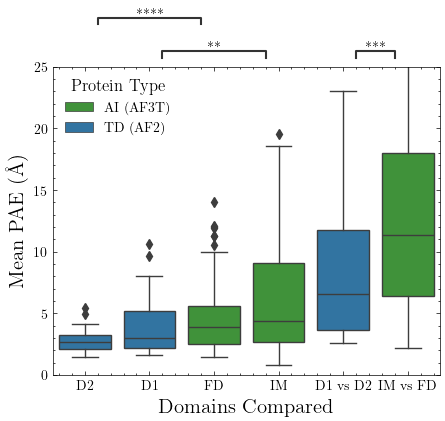

In [2242]:
plot_pae(plot_pae_af3t, 'AI (AF3T)', 'TD (AF2)', colors)

plt.savefig('./project_pipeline/data/figures/paper/af3t_pae.png', bbox_inches='tight', dpi=1200)

### AF2T PAE

/tmp/ipykernel_2466124/2997063109.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D1 vs D2_TD (AF2) vs. IM vs FD_AI (AF2T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.332e-05 U_stat=2.338e+03
D1_TD (AF2) vs. IM_AI (AF2T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.196e-06 U_stat=2.243e+03
D2_TD (AF2) vs. FD_AI (AF2T): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.191e-16 U_stat=9.340e+02


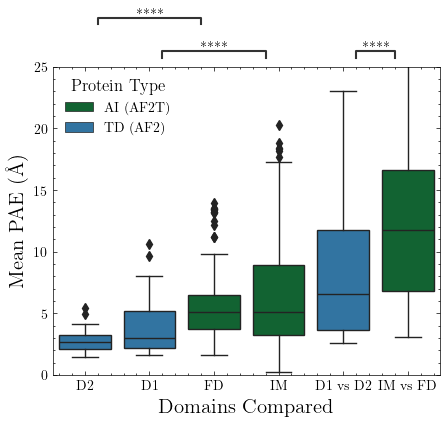

In [2243]:
plot_pae(plot_pae_af2t, 'AI (AF2T)', 'TD (AF2)', colors)

plt.savefig('./project_pipeline/data/figures/paper/af2t_pae.png', bbox_inches='tight', dpi=1200)

### AF2T Cluster PAE

/tmp/ipykernel_2466124/2997063109.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:6.376e-01 U_stat=1.150e+02
FD_AI Full Depth vs. FD_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.912e-01 U_stat=9.950e+01
IM vs FD_AI Full Depth vs. IM vs FD_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:8.358e-01 U_stat=1.220e+02


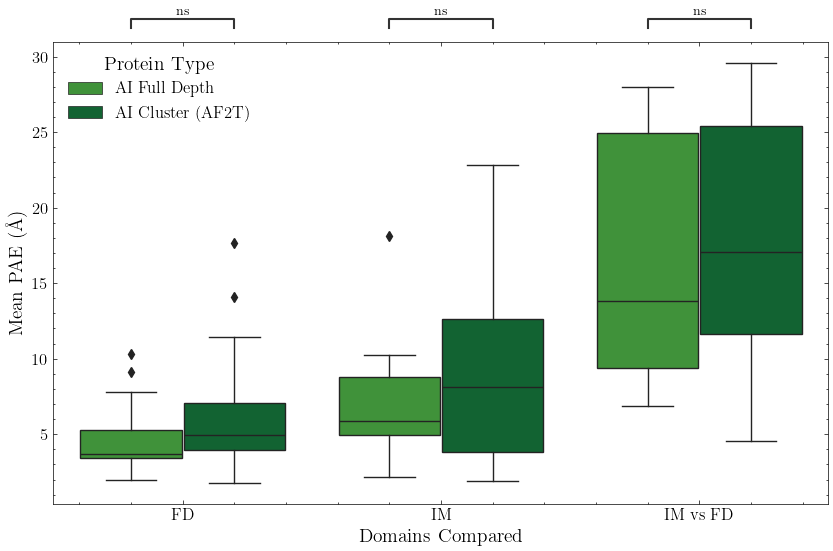

In [2244]:
plot_cluster_pae(plot_pae_af2t_2s, 'AI Full Depth', 'AI Cluster (AF2T)', colors)

### AF3 & AF2 Non-Homologous

/tmp/ipykernel_2466124/1575437852.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_Non-Homologous 
AI (AF2) vs. IM_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:8.951e-01 U_stat=1.320e+02
FD_Non-Homologous 
AI (AF2) vs. FD_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:3.964e-01 U_stat=1.510e+02
IM vs FD_Non-Homologous 
AI (AF2) vs. IM vs FD_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:9.249e-01 U_stat=1.310e+02


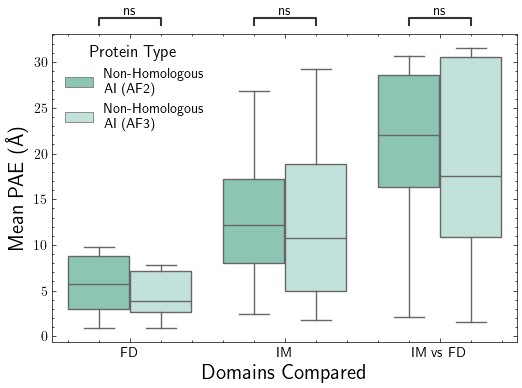

In [2851]:
type1 = 'Non-Homologous \nAI (AF2)'
type2 = 'Non-Homologous \nAI (AF3)'

region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_nonh_af3_af2, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors3, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10', loc='upper left')

pairs = [[('FD', type1), ('FD', type2)],
        [('IM', type1), ('IM', type2)],
        [('IM vs FD', type1), ('IM vs FD', type2)]]
annotator = Annotator(ax, pairs, data=plot_nonh_af3_af2, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/no_structs_pae_annotated.png', dpi=1200, bbox_inches='tight')

### AF3 and AF2 Non-homologous, folded only.

/tmp/ipykernel_2466124/124044587.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_Non-Homologous 
AI (AF2) vs. IM_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:3.823e-01 U_stat=4.100e+01
FD_Non-Homologous 
AI (AF2) vs. FD_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:5.737e-01 U_stat=3.800e+01
IM vs FD_Non-Homologous 
AI (AF2) vs. IM vs FD_Non-Homologous 
AI (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:5.054e-01 U_stat=3.900e+01


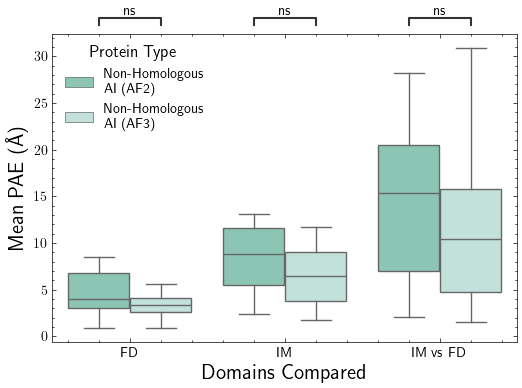

In [2897]:
type1 = 'Non-Homologous \nAI (AF2)'
type2 = 'Non-Homologous \nAI (AF3)'

plot_nonh_folded = plot_nonh_af3_af2[plot_nonh_af3_af2['status'] == 'folded']
folded = plot_nonh_folded['uniprot'].unique().tolist()

region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_nonh_folded, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors3, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10', loc='upper left')

pairs = [[('FD', type1), ('FD', type2)],
        [('IM', type1), ('IM', type2)],
        [('IM vs FD', type1), ('IM vs FD', type2)]]
annotator = Annotator(ax, pairs, data=plot_nonh_folded, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/nonhomologous_folded_pae.png', dpi=500, bbox_inches='tight')

### AF2 and AF3 non-homologous, trimmed, folded only

In [2706]:
plot_nonh_af3t_af2t.head()

,uniprot,region,mean_pae,type
0,A0A044RE18,IM,4.144834,Non-Homologous \nAI (AF2T)
1,A0A378K7V6,IM,11.144597,Non-Homologous \nAI (AF2T)
2,A0A544CH04,IM,4.318848,Non-Homologous \nAI (AF2T)
4,B7YZY9,IM,6.104410,Non-Homologous \nAI (AF2T)
9,Q48F24,IM,2.240806,Non-Homologous \nAI (AF2T)


/tmp/ipykernel_2466124/3468157217.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_Non-Homologous 
AI (AF2T) vs. IM_Non-Homologous 
AI (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:3.823e-01 U_stat=4.100e+01
FD_Non-Homologous 
AI (AF2T) vs. FD_Non-Homologous 
AI (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.786e-01 U_stat=4.300e+01
IM vs FD_Non-Homologous 
AI (AF2T) vs. IM vs FD_Non-Homologous 
AI (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:4.418e-01 U_stat=4.000e+01


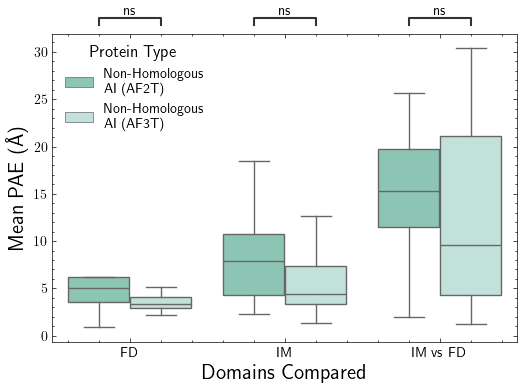

In [2898]:
type1 = 'Non-Homologous \nAI (AF2T)'
type2 = 'Non-Homologous \nAI (AF3T)'


plot_nonh_af3t_af2t = plot_nonh_af3t_af2t[plot_nonh_af3t_af2t['uniprot'].isin(folded)]

region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_nonh_af3t_af2t, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10', loc='upper left')

pairs = [[('FD', type1), ('FD', type2)],
        [('IM', type1), ('IM', type2)],
        [('IM vs FD', type1), ('IM vs FD', type2)]]
annotator = Annotator(ax, pairs, data=plot_nonh_af3t_af2t, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/nonhomologous_trimmed_folded_pae.png', dpi=500, bbox_inches='tight')

### AF2 & AF3 AI, TD

/tmp/ipykernel_2466124/3727793466.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (AF2) vs. IM/D1_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:9.318e-02 U_stat=9.187e+03
IM vs FD/D1 vs D2_Autoinhibitory (AF2) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:7.314e-02 U_stat=9.254e+03
FD/D2_Autoinhibitory (AF2) vs. FD/D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:7.216e-03 U_stat=9.784e+03
IM vs FD/D1 vs D2_Two-Domain (AF2) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:2.837e-03 U_stat=2.854e+03
IM/D1_Two-Domain (AF2) vs. IM/D1_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:4.846e-03 U_stat=2.913e+03
FD/D2_Two-Domain (AF2) vs. FD/D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.295e-08 U_stat=1.

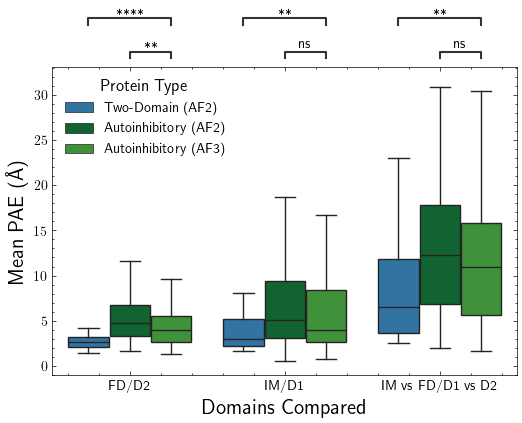

In [2850]:
type1 = 'Two-Domain (AF2)'
type2 = 'Autoinhibitory (AF2)'
type3 = 'Autoinhibitory (AF3)'

region_order = ['FD/D2', 'IM/D1', 'IM vs FD/D1 vs D2']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_pae_af2_af3_td, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10')

pairs = [[('FD/D2', type2), ('FD/D2', type3)],
         [('FD/D2', type1), ('FD/D2', type3)],
        [('IM/D1', type2), ('IM/D1', type3)],
        [('IM/D1', type1), ('IM/D1', type3)],
        [('IM vs FD/D1 vs D2', type2), ('IM vs FD/D1 vs D2', type3)],
        [('IM vs FD/D1 vs D2', type1), ('IM vs FD/D1 vs D2', type3)]]
annotator = Annotator(ax, pairs, data=plot_pae_af2_af3_td, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/pae_af2_af3_td.png', dpi=1200, bbox_inches='tight')

### AF3 and AF2 AI, AF2 TD, ordered IMs only

/tmp/ipykernel_2466124/2862748346.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (AF2) vs. IM/D1_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.165e-01 U_stat=6.204e+03
IM vs FD/D1 vs D2_Autoinhibitory (AF2) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.374e-01 U_stat=6.167e+03
FD/D2_Autoinhibitory (AF2) vs. FD/D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:3.687e-02 U_stat=6.432e+03
IM vs FD/D1 vs D2_Two-Domain (AF2) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.123e-02 U_stat=2.445e+03
IM/D1_Two-Domain (AF2) vs. IM/D1_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.957e-02 U_stat=2.505e+03
FD/D2_Two-Domain (AF2) vs. FD/D2_Autoinhibitory (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.616e-09 U_stat=1.

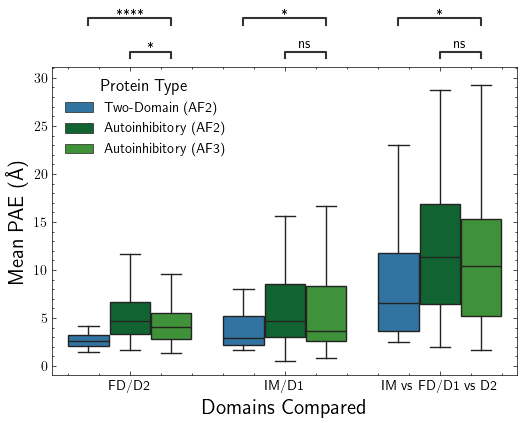

In [2919]:
type1 = 'Two-Domain (AF2)'
type2 = 'Autoinhibitory (AF2)'
type3 = 'Autoinhibitory (AF3)'

region_order = ['FD/D2', 'IM/D1', 'IM vs FD/D1 vs D2']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=ordered_af2_af3_td, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10')

pairs = [[('FD/D2', type2), ('FD/D2', type3)],
         [('FD/D2', type1), ('FD/D2', type3)],
        [('IM/D1', type2), ('IM/D1', type3)],
        [('IM/D1', type1), ('IM/D1', type3)],
        [('IM vs FD/D1 vs D2', type2), ('IM vs FD/D1 vs D2', type3)],
        [('IM vs FD/D1 vs D2', type1), ('IM vs FD/D1 vs D2', type3)]]
annotator = Annotator(ax, pairs, data=ordered_af2_af3_td, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/pae_structured_af2_af3_td.png', dpi=500, bbox_inches='tight')

### AF3 and AF2 AI, AF2 TD, trimmed

/tmp/ipykernel_2466124/889794330.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (AF2T) vs. IM/D1_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.362e-01 U_stat=8.826e+03
IM vs FD/D1 vs D2_Autoinhibitory (AF2T) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:6.351e-01 U_stat=8.408e+03
FD/D2_Autoinhibitory (AF2T) vs. FD/D2_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.077e-04 U_stat=1.031e+04
IM vs FD/D1 vs D2_Two-Domain (AF2) vs. IM vs FD/D1 vs D2_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.163e-04 U_stat=2.548e+03
IM/D1_Two-Domain (AF2) vs. IM/D1_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:1.025e-03 U_stat=2.749e+03
FD/D2_Two-Domain (AF2) vs. FD/D2_Autoinhibitory (AF3T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.761e-08 

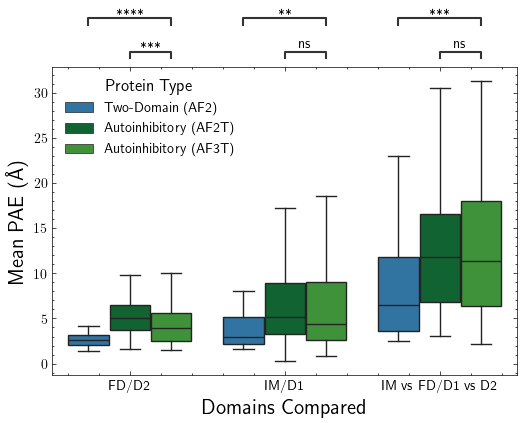

In [2920]:
type1 = 'Two-Domain (AF2)'
type2 = 'Autoinhibitory (AF2T)'
type3 = 'Autoinhibitory (AF3T)'

region_order = ['FD/D2', 'IM/D1', 'IM vs FD/D1 vs D2']

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=plot_pae_af3t_af2t_td, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=True, fliersize=0)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE (Å)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Protein Type', title_fontsize='12', fontsize='10')

pairs = [[('FD/D2', type2), ('FD/D2', type3)],
         [('FD/D2', type1), ('FD/D2', type3)],
        [('IM/D1', type2), ('IM/D1', type3)],
        [('IM/D1', type1), ('IM/D1', type3)],
        [('IM vs FD/D1 vs D2', type2), ('IM vs FD/D1 vs D2', type3)],
        [('IM vs FD/D1 vs D2', type1), ('IM vs FD/D1 vs D2', type3)]]
annotator = Annotator(ax, pairs, data=plot_pae_af3t_af2t_td, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/pae_af2t_af3t_td.png', dpi=1200, bbox_inches='tight')

### AF3 PLDDT

/tmp/ipykernel_2466124/1215475420.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory (AF3) vs. Global TD_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:9.988e-19 U_stat=1.870e+02
IM_Autoinhibitory (AF3) vs. D1_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.394e-18 U_stat=2.240e+02
FD_Autoinhibitory (AF3) vs. D2_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.352e-10 U_stat=8.580e+02


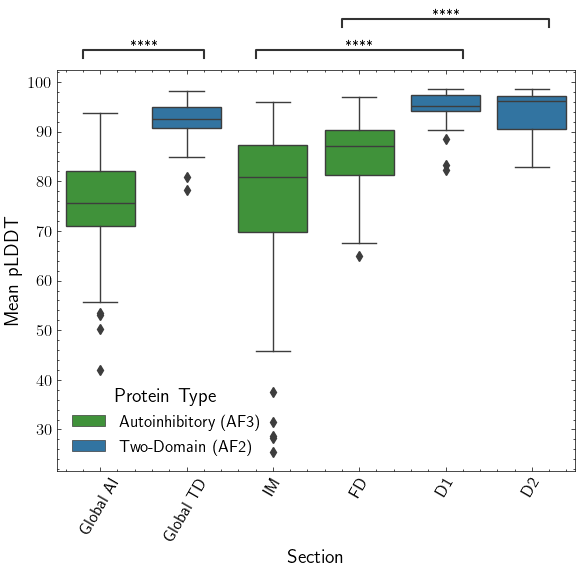

In [2916]:
plot_plddt(plot_pld_af3, 'Autoinhibitory (AF3)', 'Two-Domain (AF2)', colors)
plt.savefig('./project_pipeline/data/figures/paper/af3_full_depth_plddt.png', dpi=500, bbox_inches='tight')

### AF3 Structured IM pLDDT

/tmp/ipykernel_2466124/1215475420.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_Autoinhibitory (AF3) vs. Global TD_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:8.464e-18 U_stat=1.570e+02
IM_Autoinhibitory (AF3) vs. D1_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.874e-17 U_stat=1.890e+02
FD_Autoinhibitory (AF3) vs. D2_Two-Domain (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.946e-10 U_stat=6.750e+02


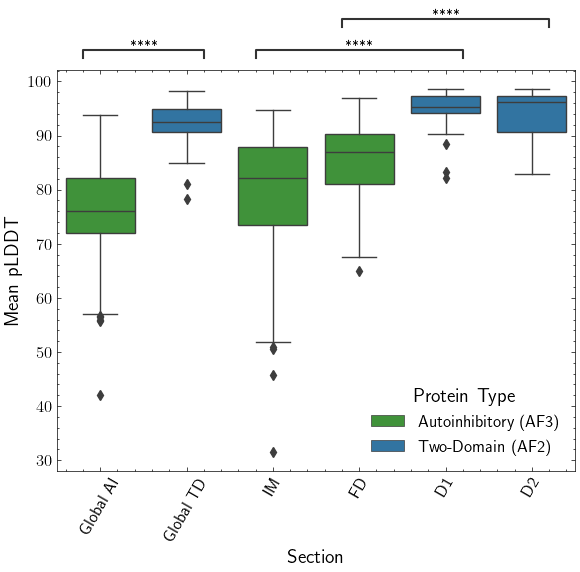

In [2918]:
plot_plddt(plot_pld_struct_af3, 'Autoinhibitory (AF3)', 'Two-Domain (AF2)', colors3)
plt.savefig('./project_pipeline/data/figures/paper/af3_structured_im_plddt.png', dpi=500, bbox_inches='tight')

### AF3T PLDDT

/tmp/ipykernel_2466124/2997063109.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_AI (AF3T) vs. Global TD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:4.601e-12 U_stat=7.020e+02
IM_AI (AF3T) vs. D1_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.027e-17 U_stat=2.580e+02
FD_AI (AF3T) vs. D2_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.201e-08 U_stat=1.029e+03


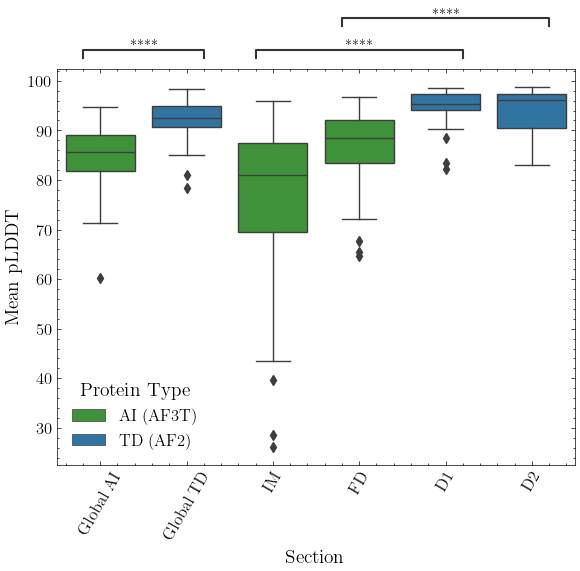

In [2254]:
plot_plddt(plot_pld_af3t, 'AI (AF3T)', 'TD (AF2)', colors)

### AF2T PLDDT

/tmp/ipykernel_2466124/477423857.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Global AI_AI (AF2T) vs. Global TD_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.043e-07 U_stat=1.121e+03
IM_AI (AF2T) vs. D1_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.900e-15 U_stat=4.340e+02
FD_AI (AF2T) vs. D2_TD (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:3.808e-06 U_stat=1.307e+03


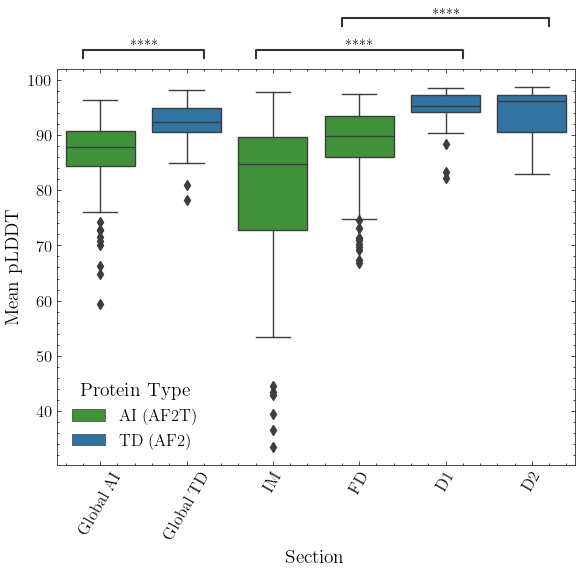

In [874]:
plot_plddt(plot_pld_af2t, 'AI (AF2T)', 'TD (AF2)', colors)

### AF2T Cluster pLDDT

/tmp/ipykernel_2466124/1790248206.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Full Depth vs. IM_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:9.549e-01 U_stat=1.300e+02
Global AI_AI Full Depth vs. Global AI_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:2.662e-01 U_stat=9.800e+01
FD_AI Full Depth vs. FD_AI Cluster (AF2T): Mann-Whitney-Wilcoxon test two-sided, P_val:7.487e-01 U_stat=1.370e+02


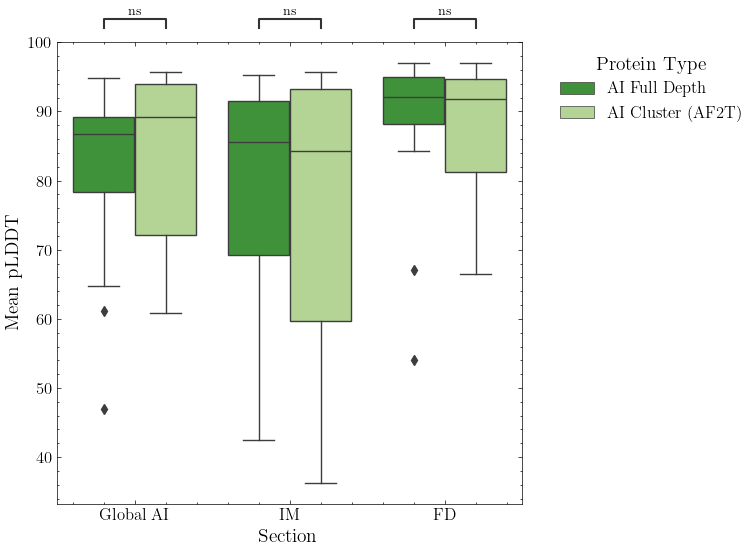

In [965]:
plot_cluster_plddt(plot_pld_af2t_2s,  'AI Full Depth', 'AI Cluster (AF2T)', colors)

## Distributions of trimmed residues

Here we look at the distribution of the number of residues removed from protein sequences by trimming so that the protein contains only the IM, FD, and everything between those.

In [985]:
def string2range(x):
    
    """
    This function takes in a `string` representing a region of interest in a
    protein. The region of interest can be a single region or multiple regions
    of a protein. Returns a range for single regions or a list of ranges for
    multiple regions.
    
    Parameters:
    
        x (string): String containing a region or several regions of interest in a 
            protein.
            Format of x: single region -> 'start-end'
                         multiple regions -> 'start1-end1,start2-end2'
                     
    Returns:
    
        range or list of ranges: For single region proteins a range is returned. For 
            multiple region proteins a list of ranges is returned

            Format: single region -> range(start, end+1)
                    multiple region -> [range(start1, end1+1), range(start2, end2+1)]
    """
    # Handle instances with more than one range
    if ',' in x:
        list_temp = x.split(sep = ',') #list_temp = ['123-456,' '789-1111']
        for y in range(len(list_temp)): 
            list_temp[y] = list_temp[y].split(sep = '-') #list_temp[y] = [['123', '456'], ['789', '1111']]
        for y in range(len(list_temp)): 
            for x in range(len(list_temp[y])):
                list_temp[y][x] = int(list_temp[y][x]) #turns each list item into an integer

        # Make a range object with the bounds of the range. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        for y in range(len(list_temp)): #[1, 2] where 1=[123, 456] and 2=[789, 1111]
            for x in range(len(list_temp[y])): #[123, 456]       
                list_temp[y] = list(range(list_temp[y][x], list_temp[y][x+1]+1)) #list_temp[0][0] = [123], list_temp[0][0+1]+1 or [456] + 1 = [457]
                break

        return list(set([item for sublist in list_temp for item in sublist]))

    # Handle instances with only one range
    else:
        list_temp = x.split(sep = '-')
        for y in range(len(list_temp)):
            list_temp[y] = int(list_temp[y]) #

        # Make a range object with the bounds of the region. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        return list(range(list_temp[0], list_temp[1]+1))

In [1010]:
# Protein lengths
pdf = pd.read_csv('./project_pipeline/data/proteins.tsv', sep='\t')

# Only our proteins of interest
pdf = pdf[pdf['uniprot'].isin(all_class_uniprots)].reset_index(drop=True)

for idx, row in pdf.iterrows():

    region_1_search = string2range(row['region_1'])
    region_2_search = string2range(row['region_2'])

    trim_reg = set(region_1_search + region_2_search)
    trim_len = max(trim_reg) - (min(trim_reg) - 1)
    pdf.at[idx, 'n_seq_trim'] = row['protein_length'] - trim_len


In [1017]:
pdf.sort_values('n_seq_trim')

,gene_name,uniprot,protein_length,region_1,region_2,af_filename,n_seq_trim
35,PANX1,Q96RD7,426.0,412-426,1-287,F-Q96RD7-F1-model_v3.cif,0.0
68,GSDMD,P57764,484.0,280-484,1-275,F-P57764-F1-model_v3.cif,0.0
110,NaN,Q5Y4Y6,464.0,240-464,1-239,F-Q5Y4Y6-F1-model_v3.cif,0.0
82,NaN,A0A0R4I961,279.0,155-279,3-147,F-A0A0R4I961-F1-model_v3.cif,2.0
25,SMYD3,Q9H7B4,428.0,280-428,4-240,F-Q9H7B4-F1-model_v3.cif,3.0
...,...,...,...,...,...,...,...
65,WNK3,Q9BYP7,1800.0,440-463,147-405,F-Q9BYP7-F1-model_v3.cif,1483.0
20,EP300,Q09472,2414.0,1520-1581,1287-1663,F-Q09472-F1-model_v3.cif,2037.0
31,FLNA,P21333,2647.0,2142-2235,2236-2325,F-P21333-F1-model_v3.cif,2463.0
76,MAPKAPK3,Q16644,NaN,307-343,44-304,F-Q16644-F1-model_v3.cif,NaN


Text(0.5, 0, 'Number of Residues Trimmed')

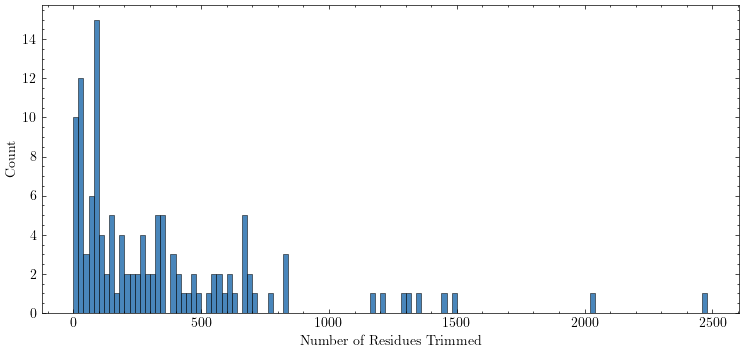

In [1025]:
fig, ax = plt.subplots(figsize=(9, 4))

sns.histplot(pdf, x='n_seq_trim', ax=ax, binwidth=20)
ax.set_xlabel('Number of Residues Trimmed')

## Comparing Two-State Performances Across Models


In [2598]:
# These predictions were done including the partners and PTMs.
af3_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_two_state_proteins.tsv', sep='\t')
af3_2s = af3_2s.rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', '2_comp': imfd, 'complex_rmsd': 'gRMSD'})

best_of_both_confs = pd.concat([best_conf_one, best_conf_two]).drop_duplicates().reset_index(drop=True)
conformation_types = best_of_both_confs[['UniProt', 'PDB', 'conformation_type']]
af3_2s = pd.merge(af3_2s, conformation_types, on=['UniProt', 'PDB'], how='inner')

af3t_all_acc = sort_by_cutoff(af3t, 'AF3T')

af2_acc = sort_by_cutoff(minimum_cl, 'AF2')

to_plot_all_af2_af3t = pd.concat([af2_acc, af3t_all_acc])

af3t_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_twostate_trimmed_AF3_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                    '2_comp': imfd, 'complex_rmsd': 'gRMSD'})

af2t_2s = pd.read_csv('./project_pipeline/data/jp_data/rmsds_twostate_trimmed_af2_best_models.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB',
                                                                                                                    '2_comp': imfd, 'complex_rmsd': 'gRMSD'})

af2t_2s_acc = sort_by_cutoff(af2t_2s, 'AF2T')

af3t_2s_acc = sort_by_cutoff(af3t_2s, 'AF3T')

af3_2s_acc = sort_by_cutoff(af3_2s, 'AF3')

compare_af3 = minimum_cl[minimum_cl['UniProt'].isin(af3_2s['UniProt'].unique().tolist())]

to_plot_accurate_three = sort_by_cutoff(compare_af3, 'AF2')
# to_plot_accurate_three = to_plot_accurate_three.groupby(['Method', 'Accuracy']).size().reset_index().pivot(columns='Accuracy', index='Method', values=0)

to_plot_2s = pd.concat([af3_2s_acc, to_plot_accurate_three, af3t_2s_acc, af2t_2s_acc])
to_plot_2s_pivot = to_plot_2s.groupby(['Method', 'Accuracy']).size().reset_index().pivot(columns='Accuracy', index='Method', values=0)

/tmp/ipykernel_2466124/1300301891.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_five['Accuracy'] = 'Accurate'
/tmp/ipykernel_2466124/1300301891.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inaccurate_five['Accuracy'] = 'Inaccurate'
/tmp/ipykernel_2466124/1300301891.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Base, Alternative, and Other Conformation Accuracies

### Preparing Data

In [2736]:
def barchart_data(df, method, cutoffs, conf_type):

    d = {}

    for cutoff in cutoffs:

        df1 = df.copy()

        df1['Cluster Method'] = f'{method} ({cutoff} \AA)'
        df1['Conformation Type'] = conf_type

        df1['Accuracy'] = np.where(df1['gRMSD'] <= cutoff, f'{conf_type} Conformation', 'Other Conformation')

        d[cutoff] = df1

    return d

def imfd_barchart_data(df, method, cutoffs, conf_type):

    d = {}

    for cutoff in cutoffs:

        df1 = df.copy()

        df1['Cluster Method'] = f'{method} ({cutoff} \AA)'
        df1['Conformation Type'] = conf_type

        df1['Accuracy'] = np.where(df1[imfd] <= cutoff, f'{conf_type} Conformation', 'Other Conformation')

        d[cutoff] = df1

    return d

def cutoff_counts(df, metric, method, cutoffs, type1, type2):

    dic = {'method_conf': [], 'method': [], 'cutoff': [], 'count': [], 'Conformation': []}
    base = df[df['Type'] == type1]
    alt = df[df['Type'] == type2]

    labels = ['Base', 'Alternate']
    dfs = [base, alt]

    # Get the number of proteins that fit the base and alt confs at the given
    # cutoffs and add the information to the dict
    for c in cutoffs:
        for l, d in zip(labels, dfs):
            label = f'({c} \AA) {l}'
            count = len(d[d[metric] <= c])
            dic['method_conf'].append(label)
            dic['method'].append(method)
            dic['cutoff'].append(c)
            dic['count'].append(count)
            dic['Conformation'].append(l)

    # Get the number of proteins that fit both confs at the given cutoffs
    for c in cutoffs:
        label = f'({c} \AA) Both'
        d = df[df[metric] <= c]
        vs = d['UniProt'].value_counts().to_frame()
        count = len(vs[vs['UniProt'] == 2])
        dic['method_conf'].append(label)
        dic['method'].append(method)
        dic['cutoff'].append(c)
        dic['count'].append(count)
        dic['Conformation'].append('Both')

    new_df = pd.DataFrame.from_dict(dic)

    return new_df

In [2625]:
best_conf_one = clust_bins.sort_values('FD $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()

best_conf_one_fd = best_conf_one[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})

In [2626]:
locally_clustered_only = clust[~clust['Cluster'].str.contains('U')]
uniformly_clustered_only = clust[clust['Cluster'].str.contains('U')]

In [2627]:
cfold2 = cfold.copy()
cfold2 = cfold2.rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})
cfold2['Type'] = 'CFold'

# Assign bins for Cfold structures compared to full-depth structures
get_cfold2_bins = pd.concat([clSub2, cfold2])

cfold2_bins = assign_bins(get_cfold2_bins)
cfold2_bins = cfold2_bins[cfold2_bins['Type'] == 'CFold']

# Make a dataframe for CFold base conformation and alternate conformations based on gRMSD
best_conf_one_grmsd_cfold = cfold2_bins[cfold2_bins['bin_id'].isin(best_conf_one_grmsd['bin_id'])] # Shares a bin ID with the full-depth base conformation
best_conf_one_grmsd_cfold['Type'] = 'CFold vs Base Conf.'
best_conf_two_grmsd_cfold = cfold2_bins[~cfold2_bins['bin_id'].isin(best_conf_one_grmsd['bin_id'])] # Opposite of above
best_conf_two_grmsd_cfold['Type'] = 'CFold vs Alt. Conf.'

# Make a dataframe for CFold base conformation and alternate conformations based on imfdRMSD
best_conf_one_cfold = cfold2_bins[cfold2_bins['bin_id'].isin(best_conf_one['bin_id'])]
best_conf_two_cfold = cfold2_bins[~cfold2_bins['bin_id'].isin(best_conf_one['bin_id'])]

/tmp/ipykernel_2466124/2997063109.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df[imfd], bins=bins, labels=labels, include_lowest=True).astype(float)
/tmp/ipykernel_2466124/2997063109.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df[imfd], bins=bins, labels=labels, include_lowest=True).astype(float)
/tmp/ipykernel_2466124/2997063109.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [2628]:
# Adjust all dfs to have only the 15 proteins of interest

best_conf_one_grmsdclust = best_conf_one_grmsdclust[best_conf_one_grmsdclust['UniProt'].isin(fifteen_prots)]
best_conf_two_grmsdclust = best_conf_two_grmsdclust[best_conf_two_grmsdclust['UniProt'].isin(fifteen_prots)]
best_conf_one_grmsd_fd = best_conf_one_grmsd_fd[best_conf_one_grmsd_fd['UniProt'].isin(fifteen_prots)]
best_conf_one_grmsd_cfold = best_conf_one_grmsd_cfold[best_conf_one_grmsd_cfold['UniProt'].isin(fifteen_prots)]
best_conf_two_grmsd_cfold = best_conf_two_grmsd_cfold[best_conf_two_grmsd_cfold['UniProt'].isin(fifteen_prots)]

best_conf_one_clust = best_conf_one_clust[best_conf_one_clust['UniProt'].isin(fifteen_prots)]
best_conf_two_clust = best_conf_two_clust[best_conf_two_clust['UniProt'].isin(fifteen_prots)]
best_conf_one_fd = best_conf_one_fd[best_conf_one_fd['UniProt'].isin(fifteen_prots)]
best_conf_one_cfold = best_conf_one_cfold[best_conf_one_cfold['UniProt'].isin(fifteen_prots)]
best_conf_two_cfold = best_conf_two_cfold[best_conf_two_cfold['UniProt'].isin(fifteen_prots)]

In [2629]:
# Take the best local and uniform clusters based on gRMSD
best_lc_pdb = locally_clustered_only.sort_values('gRMSD').groupby('PDB').first().reset_index()
best_uc_pdb = uniformly_clustered_only.sort_values('gRMSD').groupby('PDB').first().reset_index()

best_lc_pdb = best_lc_pdb[['PDB', 'Cluster', 'gRMSD', imfd]]
best_uc_pdb = best_uc_pdb[['PDB', 'Cluster', 'gRMSD', imfd]]

best_conf_one_lc = pd.merge(best_conf_one_grmsdclust.drop(columns=['gRMSD', imfd]), best_lc_pdb, on='PDB', how='left').drop_duplicates().reset_index(drop=True)
best_conf_one_uc = pd.merge(best_conf_one_grmsdclust.drop(columns=['gRMSD', imfd]), best_uc_pdb, on='PDB', how='left').drop_duplicates().reset_index(drop=True)

best_conf_two_lc = pd.merge(best_conf_two_grmsdclust.drop(columns=['gRMSD', imfd]), best_lc_pdb, on='PDB', how='left').drop_duplicates().reset_index(drop=True)
best_conf_two_uc = pd.merge(best_conf_two_grmsdclust.drop(columns=['gRMSD', imfd]), best_uc_pdb, on='PDB', how='left').drop_duplicates().reset_index(drop=True)

In [ ]:
# Two-state proteins

af3_2s = af3_2s.fillna('base')
af3_2s = af3_2s[af3_2s['UniProt'].isin(fifteen_prots)]
af3_conf_one = af3_2s[af3_2s['conformation_type'] == 'base']
af3_conf_two = af3_2s[af3_2s['conformation_type'] == 'alternate'] 

In [2632]:
cutoffs = [2, 3, 5, 10]
labels = ['Base', 'Alternate', 'Both']
orders = []

for c in cutoffs:
    for l in labels:
        orders.append(f'({c} \AA) {l}')

uc_df = cutoff_counts(pd.concat([best_conf_one_uc, best_conf_two_uc]), 'gRMSD', 'Uniformly Clustered', cutoffs, 'Cluster vs Base Conf.', 'Cluster vs Alt. Conf.')
uc_df = uc_df.set_index(uc_df['method_conf']).reindex(orders).reset_index(drop=True)
lc_df = cutoff_counts(pd.concat([best_conf_one_lc, best_conf_two_lc]), 'gRMSD', 'Uniformly Clustered', cutoffs, 'Cluster vs Base Conf.', 'Cluster vs Alt. Conf.')
lc_df = lc_df.set_index(lc_df['method_conf']).reindex(orders).reset_index(drop=True)
fd_df = cutoff_counts(best_conf_one_grmsd_fd, 'gRMSD', 'Full Depth', cutoffs, 'Full-Depth vs Base Conf.', 'NA')
fd_df = fd_df.set_index(fd_df['method_conf']).reindex(orders).reset_index(drop=True)

af3_conf_one['Type'] = 'Full-Depth AF3 vs Base Conf.'
af3_conf_two['Type'] = 'Full-Depth AF3 vs Alt. Conf.'

af3_df = cutoff_counts(pd.concat([af3_conf_one, af3_conf_two]), 'gRMSD', 'Full Depth', cutoffs, 'Full-Depth AF3 vs Base Conf.', 'Full-Depth AF3 vs Alt. Conf.')
af3_df = af3_df.set_index(af3_df['method_conf']).reindex(orders).reset_index(drop=True)


### Conformations based off of gRMSD

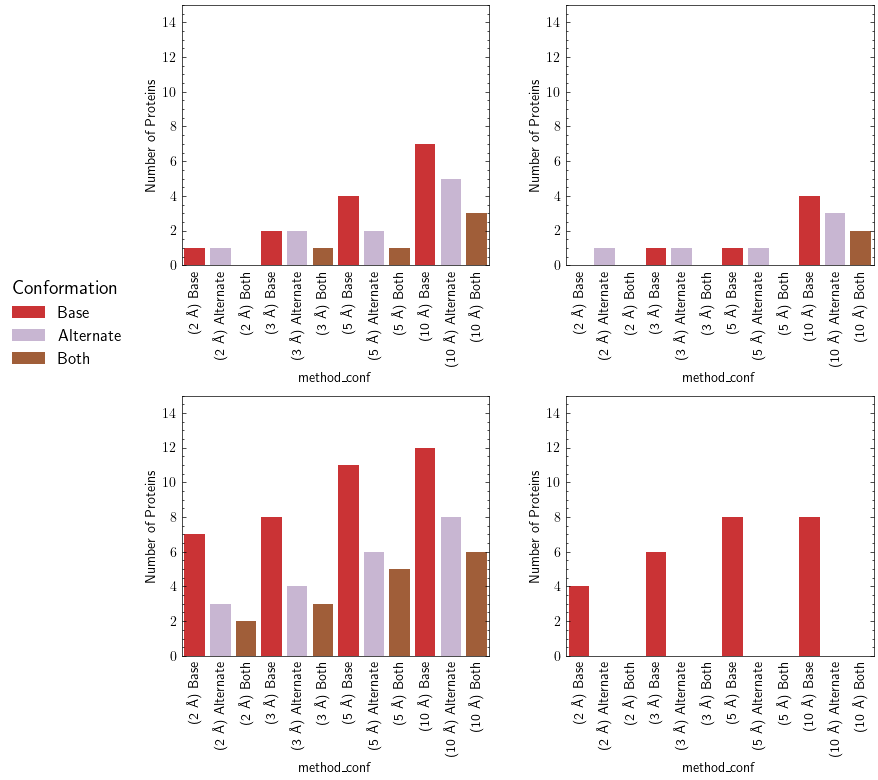

In [2846]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8))

sns.barplot(data=uc_df, x='method_conf', y='count', ax=ax[0][0], hue='Conformation', palette=colors, dodge=False)
ax[0][0].set_ylim(0, 15)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)
ax[0][0].tick_params(axis='x', which='both', bottom=False, top=False)
ax[0][0].set_ylabel('Number of Proteins')
ax[0][0].legend(title='Conformation', title_fontsize=14, fontsize=12, bbox_to_anchor=(-0.15, 0))

sns.barplot(data=lc_df, x='method_conf', y='count', ax=ax[0][1], hue='Conformation', palette=colors, dodge=False)
ax[0][1].set_ylim(0, 15)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)
ax[0][1].tick_params(axis='x', which='both', bottom=False, top=False)
ax[0][1].set_ylabel('Number of Proteins')
ax[0][1].get_legend().remove()

sns.barplot(data=af3_df, x='method_conf', y='count', ax=ax[1][0], hue='Conformation', palette=colors, dodge=False)
ax[1][0].set_ylim(0, 15)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)
ax[1][0].tick_params(axis='x', which='both', bottom=False, top=False)
ax[1][0].set_ylabel('Number of Proteins')
ax[1][0].get_legend().remove()

sns.barplot(data=fd_df, x='method_conf', y='count', ax=ax[1][1], hue='Conformation', palette=colors, dodge=False)
ax[1][1].set_ylim(0, 15)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)
ax[1][1].tick_params(axis='x', which='both', bottom=False, top=False)
ax[1][1].set_ylabel('Number of Proteins')
ax[1][1].get_legend().remove()

fig.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.savefig('./project_pipeline/data/figures/paper/conformations_by_method.png', dpi=500, bbox_inches='tight')

### Number of conformations based off of imfdRMSD

In [2734]:
imfd_conf_one = clust_bins.sort_values('FD $_{fd}^{im}$RMSD').groupby('UniProt').first().reset_index()

imfd_conf_one_fd = imfd_conf_one[['UniProt', 'PDB', 'FD gRMSD', 'FD $_{fd}^{im}$RMSD', 'bin', 'bin_id']] \
                    .rename(columns={'FD gRMSD': 'gRMSD', 'FD $_{fd}^{im}$RMSD': '$_{fd}^{im}$RMSD'})

imfd_lc_pdb = locally_clustered_only.sort_values(imfd).groupby('PDB').first().reset_index()
imfd_uc_pdb = uniformly_clustered_only.sort_values(imfd).groupby('PDB').first().reset_index()

imfd_lc_pdb = imfd_lc_pdb[['PDB', 'Cluster', 'gRMSD', imfd]]
imfd_uc_pdb = imfd_uc_pdb[['PDB', 'Cluster', 'gRMSD', imfd]]

imfd_conf_one_lc = pd.merge(best_conf_one_clust.drop(columns=['gRMSD', imfd]), imfd_lc_pdb, on='PDB', how='left')
imfd_conf_one_uc = pd.merge(best_conf_one_clust.drop(columns=['gRMSD', imfd]), imfd_uc_pdb, on='PDB', how='left')


imfd_conf_two_lc = pd.merge(best_conf_two_clust.drop(columns=['gRMSD', imfd]), imfd_lc_pdb, on='PDB', how='left')
imfd_conf_two_uc = pd.merge(best_conf_two_clust.drop(columns=['gRMSD', imfd]), imfd_uc_pdb, on='PDB', how='left')

ilo_dfs = imfd_barchart_data(imfd_conf_one_lc, 'Locally Clustered', [2, 3, 5, 10], 'Base')
iuo_dfs = imfd_barchart_data(imfd_conf_one_uc, 'Uniformly Clustered', [2, 3, 5, 10], 'Base')

ilt_dfs = imfd_barchart_data(imfd_conf_two_lc, 'Locally Clustered', [2, 3, 5, 10], 'Alternate')
iut_dfs = imfd_barchart_data(imfd_conf_two_uc, 'Uniformly Clustered', [2, 3, 5, 10], 'Alternate')

ifo_dfs = imfd_barchart_data(imfd_conf_one_fd, 'Full Depth', [2, 3, 5, 10], 'Base')

# CFold
ico1_dfs = imfd_barchart_data(best_conf_one_cfold, 'CFold', [2, 3, 5, 10], 'Base')
ico2_dfs = imfd_barchart_data(best_conf_two_cfold, 'CFold', [2, 3, 5, 10], 'Alternate')

# AF3 Two-state
af3_imfd_one = imfd_barchart_data(af3_conf_one, 'Full Depth AF3', [2, 3, 5, 10], 'Base')
af3_imfd_two = imfd_barchart_data(af3_conf_two, 'Full Depth AF3', [2, 3, 5, 10], 'Alternate')

# Concatenate everything

d_list2 = [ilo_dfs, iuo_dfs, ilt_dfs, iut_dfs, af3_imfd_one, af3_imfd_two, ifo_dfs]

best_2s = pd.concat([d[2] for d in d_list2]).reset_index(drop=True).drop_duplicates(subset=['UniProt', 'Cluster Method', 'Accuracy']).reset_index(drop=True)
best_3s = pd.concat([d[3] for d in d_list2]).reset_index(drop=True).drop_duplicates(subset=['UniProt', 'Cluster Method', 'Accuracy']).reset_index(drop=True)
best_5s = pd.concat([d[5] for d in d_list2]).reset_index(drop=True).drop_duplicates(subset=['UniProt', 'Cluster Method', 'Accuracy']).reset_index(drop=True)
best_10s = pd.concat([d[10] for d in d_list2]).reset_index(drop=True).drop_duplicates(subset=['UniProt', 'Cluster Method', 'Accuracy']).reset_index(drop=True)

barchart_df2 = pd.concat([best_2s, best_3s, best_5s, best_10s])

In [2735]:
cutoffs = [2, 3, 5, 10]
labels = ['Base', 'Alternate', 'Both']
orders = []

for c in cutoffs:
    for l in labels:
        orders.append(f'({c} \AA) {l}')

best_conf_one_fd['Type'] = 'Full-Depth vs Base Conf.'

uc_df = cutoff_counts(pd.concat([imfd_conf_one_uc, imfd_conf_two_uc]), imfd, 'Uniformly Clustered', cutoffs, 'Cluster vs Base Conf.', 'Cluster vs Alt. Conf.')
uc_df = uc_df.set_index(uc_df['method_conf']).reindex(orders).reset_index(drop=True)
lc_df = cutoff_counts(pd.concat([imfd_conf_one_lc, imfd_conf_two_lc]), imfd, 'Uniformly Clustered', cutoffs, 'Cluster vs Base Conf.', 'Cluster vs Alt. Conf.')
lc_df = lc_df.set_index(lc_df['method_conf']).reindex(orders).reset_index(drop=True)
fd_df = cutoff_counts(best_conf_one_fd, imfd, 'Full Depth', cutoffs, 'Full-Depth vs Base Conf.', 'NA')
fd_df = fd_df.set_index(fd_df['method_conf']).reindex(orders).reset_index(drop=True)
af3_imfd = cutoff_counts(pd.concat([af3_conf_one, af3_conf_two]), imfd, 'Full Depth', cutoffs, 'Full-Depth AF3 vs Base Conf.', 'Full-Depth AF3 vs Alt. Conf.')
af3_imfd = af3_imfd.set_index(af3_imfd['method_conf']).reindex(orders).reset_index(drop=True)

At 2 angstroms, 1 # of proteins fit the Base conformation
At 2 angstroms, 1 # of proteins fit the Alternate conformation
At 3 angstroms, 2 # of proteins fit the Base conformation
At 3 angstroms, 2 # of proteins fit the Alternate conformation
At 5 angstroms, 4 # of proteins fit the Base conformation
At 5 angstroms, 2 # of proteins fit the Alternate conformation
At 10 angstroms, 7 # of proteins fit the Base conformation
At 10 angstroms, 5 # of proteins fit the Alternate conformation
At 2 angstroms, 0 # of proteins fit the Base conformation
At 2 angstroms, 1 # of proteins fit the Alternate conformation
At 3 angstroms, 1 # of proteins fit the Base conformation
At 3 angstroms, 1 # of proteins fit the Alternate conformation
At 5 angstroms, 1 # of proteins fit the Base conformation
At 5 angstroms, 1 # of proteins fit the Alternate conformation
At 10 angstroms, 4 # of proteins fit the Base conformation
At 10 angstroms, 3 # of proteins fit the Alternate conformation
At 2 angstroms, 4 # of prote

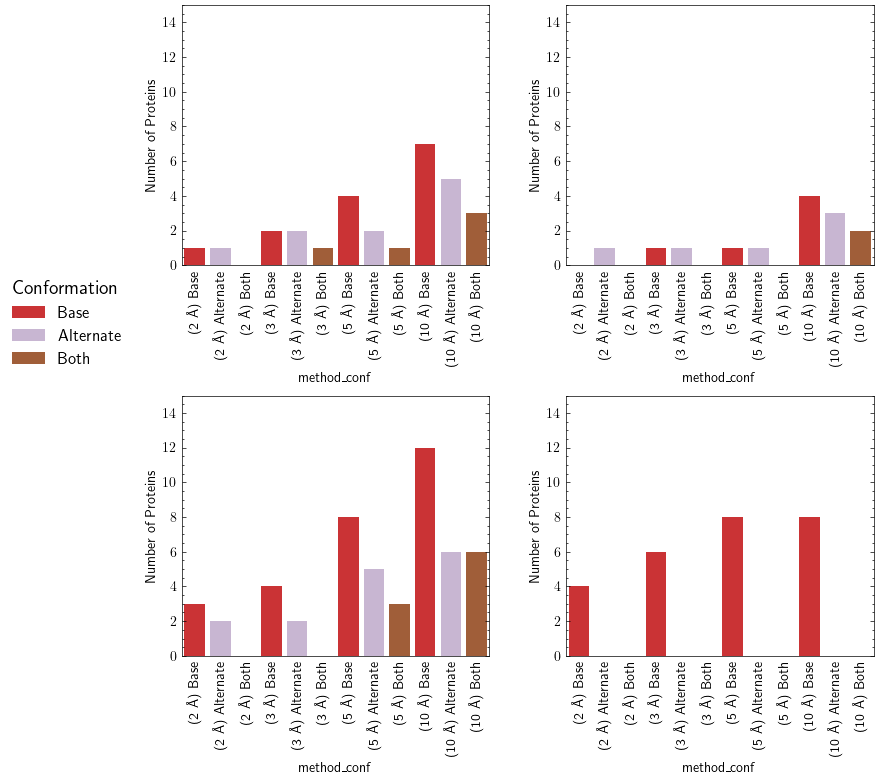

In [2847]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8))

sns.barplot(data=uc_df, x='method_conf', y='count', ax=ax[0][0], hue='Conformation', palette=colors, dodge=False)
ax[0][0].set_ylim(0, 15)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)
ax[0][0].tick_params(axis='x', which='both', bottom=False, top=False)
ax[0][0].set_ylabel('Number of Proteins')
ax[0][0].legend(title='Conformation', title_fontsize=14, fontsize=12, bbox_to_anchor=(-0.15, 0))

sns.barplot(data=lc_df, x='method_conf', y='count', ax=ax[0][1], hue='Conformation', palette=colors, dodge=False)
ax[0][1].set_ylim(0, 15)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)
ax[0][1].tick_params(axis='x', which='both', bottom=False, top=False)
ax[0][1].set_ylabel('Number of Proteins')
ax[0][1].get_legend().remove()

sns.barplot(data=af3_imfd, x='method_conf', y='count', ax=ax[1][0], hue='Conformation', palette=colors, dodge=False)
ax[1][0].set_ylim(0, 15)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)
ax[1][0].tick_params(axis='x', which='both', bottom=False, top=False)
ax[1][0].set_ylabel('Number of Proteins')
ax[1][0].get_legend().remove()

sns.barplot(data=fd_df, x='method_conf', y='count', ax=ax[1][1], hue='Conformation', palette=colors, dodge=False)
ax[1][1].set_ylim(0, 15)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)
ax[1][1].tick_params(axis='x', which='both', bottom=False, top=False)
ax[1][1].set_ylabel('Number of Proteins')
ax[1][1].get_legend().remove()

fig.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.savefig('./project_pipeline/data/figures/paper/imfd_conformations_by_method.png', dpi=500, bbox_inches='tight')

### CFold Conformations

In [2738]:
cf_df = cutoff_counts(pd.concat([best_conf_one_grmsd_cfold, best_conf_two_grmsd_cfold]), 'gRMSD', 'CFold', cutoffs, 'CFold vs Base Conf.', 'CFold vs Alt. Conf.')
cf_df = cf_df.set_index(cf_df['method_conf']).reindex(orders).reset_index(drop=True)

In [2739]:
cf_imfd = cutoff_counts(pd.concat([best_conf_one_cfold, best_conf_two_cfold]), imfd, 'CFold', cutoffs, 'CFold vs Base Conf.', 'CFold vs Alt. Conf.')
cf_imfd = cf_imfd.set_index(cf_imfd['method_conf']).reindex(orders).reset_index(drop=True)

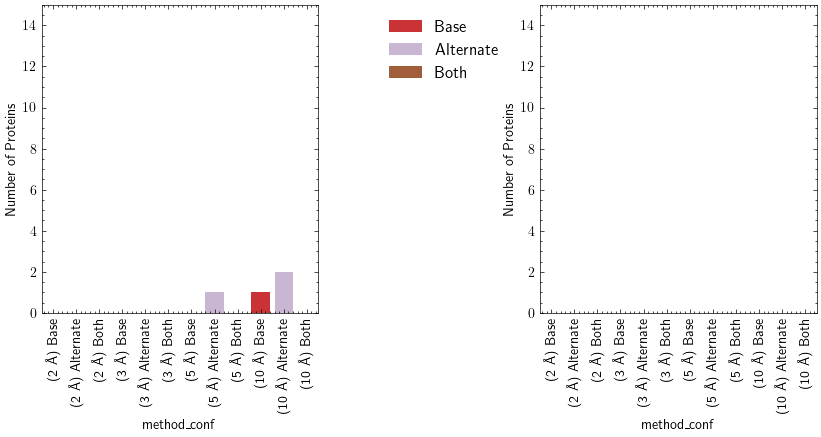

In [2930]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=cf_df, x='method_conf', y='count', ax=ax[0], hue='Conformation', palette=colors, dodge=False)
ax[0].set_ylim(0, 15)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylabel('Number of Proteins')
ax[0].legend(title_fontsize=14, fontsize=12, bbox_to_anchor=(1.2, 1))

sns.barplot(data=cf_imfd, x='method_conf', y='count', ax=ax[1], hue='Conformation', palette=colors, dodge=False)
ax[1].set_ylim(0, 15)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_ylabel('Number of Proteins')
ax[1].get_legend().remove()

plt.subplots_adjust(wspace=0.8)

plt.savefig('./project_pipeline/data/figures/paper/cfold_conformations.png', dpi=500, bbox_inches='tight')

In [2747]:
best_conf_two_cfold['UniProt'].nunique()

13

## Correlations of pLDDT and PAE to RMSD of Clusters

Take a look at how the best uniform clusters compare to their pLDDT

In [2781]:
# To get all 38 proteins, comment out the sections where it filters by the fifteen proteins.

rmsds = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster',
                                                                                                     'complex_rmsd': 'gRMSD', '2_comp': imfd}) \
                [['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]]
pae = pd.read_csv('./project_pipeline/data/ai_cluster_pae.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster'})
pl = pd.read_csv('./project_pipeline/data/ai_cluster_pLDDT.tsv', sep='\t').rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB', 'cluster': 'Cluster'})

# Split into uniform and local clusters
uc = pae[pae['Cluster'].str.contains('U')]
lc = pae[~pae['Cluster'].str.contains('U')]

# Get the best clusters
best_uc = uc.sort_values('mean_pae_1_2', ascending=True).groupby(['UniProt']).first().reset_index()
best_uc = best_uc[best_uc['UniProt'].isin(fifteen_prots)]
best_lc = lc.sort_values('mean_pae_1_2', ascending=True).groupby(['UniProt']).first().reset_index()
best_lc = best_lc[best_lc['UniProt'].isin(fifteen_prots)]

# Now get the best fits to those clusters
best_uc = pd.merge(rmsds, best_uc, on=['UniProt', 'Cluster'], how='inner')
best_uc = best_uc.sort_values('gRMSD').groupby('UniProt').first().reset_index()
best_lc = pd.merge(rmsds, best_lc, on=['UniProt', 'Cluster'], how='inner')
best_lc = best_lc.sort_values('gRMSD').groupby('UniProt').first().reset_index()

pl = pl[['UniProt', 'Cluster', 'complex_mean_plddt']]
pl = pl[pl['UniProt'].isin(fifteen_prots)]

# Get the best cluster based on plddt
pl_uc = pl[pl['Cluster'].str.contains('U')]
pl_lc = pl[~pl['Cluster'].str.contains('U')]
best_pl_uc = pl_uc.sort_values('complex_mean_plddt').groupby('UniProt').first().reset_index()
best_pl_lc = pl_lc.sort_values('complex_mean_plddt').groupby('UniProt').first().reset_index()

best_pl_uc = pd.merge(rmsds, best_pl_uc, on=['UniProt', 'Cluster'], how='inner').drop_duplicates().reset_index(drop=True)
best_pl_lc = pd.merge(rmsds, best_pl_lc, on=['UniProt', 'Cluster'], how='inner').drop_duplicates().reset_index(drop=True)

best_pl_uc = best_pl_uc.sort_values('gRMSD').groupby('UniProt').first().reset_index()
best_pl_lc = best_pl_lc.sort_values('gRMSD').groupby('UniProt').first().reset_index()

best_uc['type'] = 'AI Uniform Clusters (Best PAE)'
best_pl_uc['type'] = 'AI Uniform Clusters (Best pLDDT)'
best_uc['subtype'] = 'AI Uniform Clusters'
best_pl_uc['subtype'] = 'AI Uniform Clusters'

best_lc['type'] = 'AI Local Clusters (Best PAE)'
best_pl_lc['type'] = 'AI Local Clusters (Best pLDDT)'
best_lc['subtype'] = 'AI Local Clusters'
best_pl_lc['subtype'] = 'AI Local Clusters'

compare_rmsds = pd.concat([best_pl_uc, best_pl_lc])
compare_rmsds['gRMSD'] = compare_rmsds['gRMSD'].astype(float)
compare_rmsds[imfd] = compare_rmsds[imfd].astype(float)

compare_pae = pd.concat([best_uc, best_lc])

In [2783]:
coltypes = {'gRMSD': float, imfd: float}

compare_to_pae_only_u = min_only_u[min_only_u['UniProt'].isin(fifteen_prots)]
# compare_to_pae_only_u = min_only_u
compare_to_pae_only_u = compare_to_pae_only_u[['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]]
compare_to_pae_only_u['type'] = 'AI Uniform Clusters (Best gRMSD)'
compare_to_pae_only_u['subtype'] = 'AI Uniform Clusters'

compare_to_pae_no_u = min_nou[min_nou['UniProt'].isin(fifteen_prots)]
# compare_to_pae_no_u = min_nou
compare_to_pae_no_u = compare_to_pae_no_u[['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]]
compare_to_pae_no_u['type'] = 'AI Local Clusters (Best gRMSD)'
compare_to_pae_no_u['subtype'] = 'AI Local Clusters'

compare_to_pld_only_u = min_only_u[min_only_u['UniProt'].isin(fifteen_prots)]
# compare_to_pld_only_u = min_only_u
compare_to_pld_only_u = compare_to_pld_only_u[['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]]
compare_to_pld_only_u['type'] = 'AI Uniform Clusters (Best gRMSD)'
compare_to_pld_only_u['subtype'] = 'AI Uniform Clusters'

compare_to_pld_no_u = min_nou[min_nou['UniProt'].isin(fifteen_prots)]
# compare_to_pld_no_u = min_nou
compare_to_pld_no_u = compare_to_pld_no_u[['UniProt', 'PDB', 'Cluster', 'gRMSD', imfd]]
compare_to_pld_no_u['type'] = 'AI Local Clusters (Best gRMSD)'
compare_to_pld_no_u['subtype'] = 'AI Local Clusters'

compare_pae = pd.concat([compare_to_pae_only_u, best_uc, compare_to_pae_no_u, best_lc]).astype(coltypes)
compare_rmsds = pd.concat([compare_to_pld_only_u, best_pl_uc, compare_to_pld_no_u, best_pl_lc]).astype(coltypes)

### PAE and pLDDT together, gRMSD

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:7.016e-03 U_stat=4.700e+01
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:1.438e-01 U_stat=5.550e+01
AI Uniform Clusters (Best pLDDT) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:1.881e-02 U_stat=4.600e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:2.807e-01 U_stat=8.600e+01
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Be

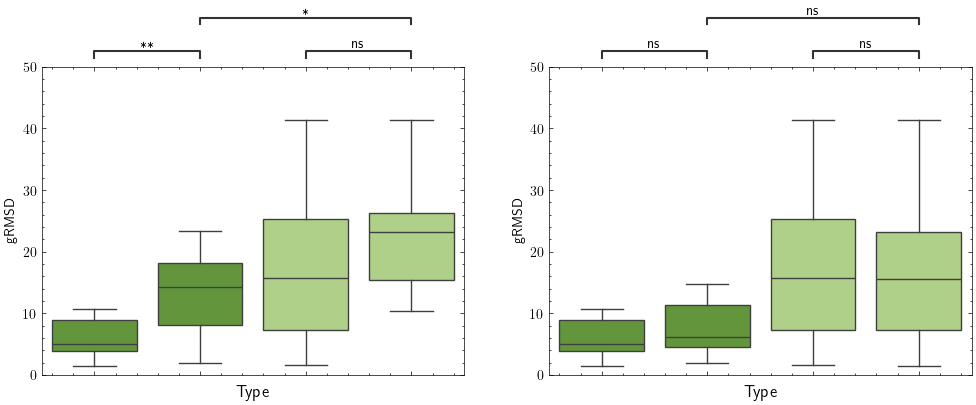

In [2867]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_ylim(0, 50)
ax[1].set_ylim(0, 50)

sns.boxplot(data=compare_rmsds, x='type', y='gRMSD', ax=ax[0], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[0].set_xlabel('Type', fontsize=12)
ax[0].set_xticklabels([])
ax[0].get_legend().remove()

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best pLDDT)'),
         ('AI Uniform Clusters (Best pLDDT)', 'AI Local Clusters (Best pLDDT)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best pLDDT)')]
annotator = Annotator(ax[0], pairs, data=compare_rmsds, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

sns.boxplot(data=compare_pae, x='type', y='gRMSD', ax=ax[1], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[1].set_xlabel('Type', fontsize=12)
ax[1].set_xticklabels([])
ax[1].get_legend().remove()

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best PAE)'),
         ('AI Uniform Clusters (Best PAE)', 'AI Local Clusters (Best PAE)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best PAE)')]
annotator = Annotator(ax[1], pairs, data=compare_pae, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/15_prots_best_clusters_by_pae_and_plddt.png', dpi=500, bbox_inches='tight')

### PAE and pLDDT together, best imfdRMSD

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:1.012e-02 U_stat=5.000e+01
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:2.246e-02 U_stat=3.950e+01
AI Uniform Clusters (Best pLDDT) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:4.070e-01 U_stat=7.900e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:7.089e-01 U_stat=1.030e+02
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Be

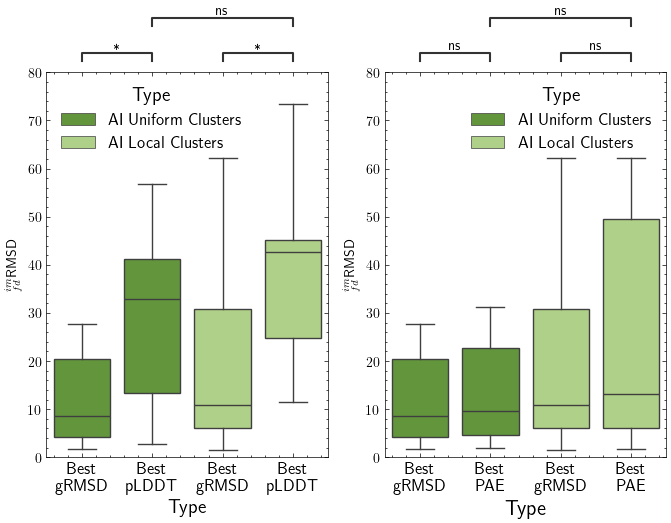

In [2888]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].set_ylim(0, 80)
ax[1].set_ylim(0, 80)

sns.boxplot(data=compare_rmsds, x='type', y=imfd, ax=ax[0], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[0].set_xlabel('Type', fontsize=14)
ax[0].set_xticklabels(['Best \ngRMSD', 'Best \npLDDT', 'Best \ngRMSD', 'Best \npLDDT'], fontsize=12)
ax[0].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best pLDDT)'),
         ('AI Uniform Clusters (Best pLDDT)', 'AI Local Clusters (Best pLDDT)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best pLDDT)')]
annotator = Annotator(ax[0], pairs, data=compare_rmsds, x='type', y=imfd)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

sns.boxplot(data=compare_pae, x='type', y=imfd, ax=ax[1], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[1].set_xlabel('Type', fontsize=15)
ax[1].set_xticklabels(['Best \ngRMSD', 'Best \nPAE', 'Best \ngRMSD', 'Best \nPAE'], fontsize=12)
ax[1].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best PAE)'),
         ('AI Uniform Clusters (Best PAE)', 'AI Local Clusters (Best PAE)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best PAE)')]
annotator = Annotator(ax[1], pairs, data=compare_pae, x='type', y=imfd)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/15_prots_best_clusters_imfd_by_pae_and_plddt.png', dpi=500, bbox_inches='tight')

### Best PAE

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:2.363e-01 U_stat=6.075e+02
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:8.685e-01 U_stat=5.640e+02
AI Uniform Clusters (Best PAE) vs. AI Local Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:1.105e-01 U_stat=5.040e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best PAE): Mann-Whitney-Wilcoxon test two-sided, P_val:5.195e-01 U_stat=6.595e+02
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best PAE):

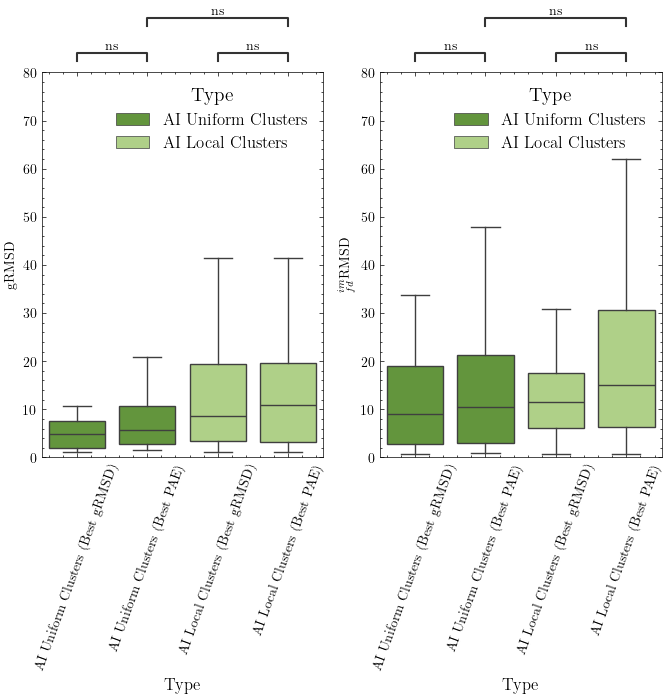

In [2729]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].set_ylim(0, 80)
ax[1].set_ylim(0, 80)

sns.boxplot(data=compare_pae, x='type', y='gRMSD', ax=ax[0], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[0].set_xlabel('Type', fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10, rotation=70)
ax[0].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best PAE)'),
         ('AI Uniform Clusters (Best PAE)', 'AI Local Clusters (Best PAE)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best PAE)')]
annotator = Annotator(ax[0], pairs, data=compare_pae, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()


sns.boxplot(data=compare_pae, x='type', y=imfd, ax=ax[1], hue='subtype', palette=clust_colors, dodge=False, fliersize=0),
ax[1].set_xlabel('Type', fontsize=12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=70)
ax[1].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best PAE)'),
         ('AI Uniform Clusters (Best PAE)', 'AI Local Clusters (Best PAE)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best PAE)')]
annotator = Annotator(ax[1], pairs, data=compare_pae, x='type', y=imfd)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/38_prots_best_clusters_by_pae.png', dpi=1200, bbox_inches='tight')

### Best pLDDT

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:1.237e-04 U_stat=3.520e+02
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:2.730e-05 U_stat=2.355e+02
AI Uniform Clusters (Best pLDDT) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:7.445e-04 U_stat=3.465e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:1.351e-03 U_stat=4.130e+02
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (

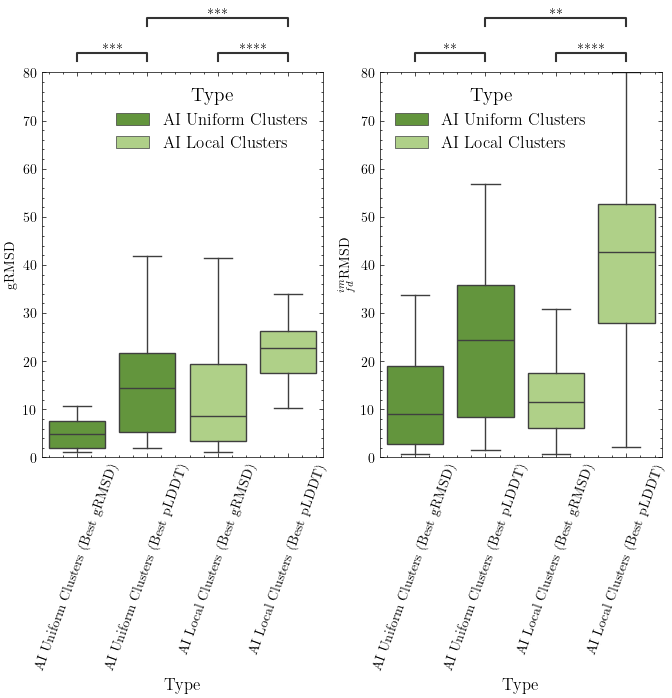

In [2731]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].set_ylim(0, 80)
ax[1].set_ylim(0, 80)

sns.boxplot(data=compare_rmsds, x='type', y='gRMSD', ax=ax[0], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[0].set_xlabel('Type', fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10, rotation=70)
ax[0].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best pLDDT)'),
         ('AI Uniform Clusters (Best pLDDT)', 'AI Local Clusters (Best pLDDT)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best pLDDT)')]
annotator = Annotator(ax[0], pairs, data=compare_rmsds, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()


sns.boxplot(data=compare_rmsds, x='type', y=imfd, ax=ax[1], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[1].set_xlabel('Type', fontsize=12)
ax[1].set_xticklabels(ax[0].get_xticklabels(), fontsize=10, rotation=70)
ax[1].legend(title='Type', title_fontsize=14, fontsize=12)

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best pLDDT)'),
         ('AI Uniform Clusters (Best pLDDT)', 'AI Local Clusters (Best pLDDT)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best pLDDT)')]
annotator = Annotator(ax[1], pairs, data=compare_rmsds, x='type', y=imfd)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/38_prots_best_clusters_by_plddt.png', dpi=1200, bbox_inches='tight')

### pLDDT of the best base and alternate fits.

In [2516]:
conf_one_pld = pd.merge(best_conf_one_grmsd[best_conf_one_grmsd['UniProt'].isin(fifteen_prots)], afAuto.rename(columns={'uniprot': 'UniProt'}), on='UniProt', how='left')
conf_two_pld = pd.merge(best_conf_two_grmsd[best_conf_one_grmsd['UniProt'].isin(fifteen_prots)], clAuto, on=['UniProt', 'Cluster'], how='left')

conf_one_pld = conf_one_pld[['UniProt', 'PDB', 'conformation_type', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']]
conf_two_pld = conf_two_pld[['UniProt', 'PDB', 'Cluster', 'conformation_type', 'complex_mean_plddt', 'r1_mean_plddt', 'r2_mean_plddt']]

conf_one_pld = rename_auto_columns(conf_one_pld)
conf_two_pld = rename_auto_columns(conf_two_pld)

conf_one_pld['conformation_type'] = 'Base'
conf_two_pld['conformation_type'] = 'Alternate'

both_conf = pd.concat([conf_one_pld, conf_two_pld])

both_conf_pld = both_conf.melt(id_vars=['UniProt', 'PDB', 'Cluster', 'conformation_type'], var_name='Section', value_name='Mean pLDDT')
both_conf_pld['Mean pLDDT'] = both_conf_pld['Mean pLDDT'].astype(float)

/tmp/ipykernel_2466124/212707601.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_Base vs. IM_Alternate: Mann-Whitney-Wilcoxon test two-sided, P_val:5.663e-01 U_stat=1.953e+03
Global AI_Base vs. Global AI_Alternate: Mann-Whitney-Wilcoxon test two-sided, P_val:8.387e-05 U_stat=9.190e+02
FD_Base vs. FD_Alternate: Mann-Whitney-Wilcoxon test two-sided, P_val:6.111e-01 U_stat=1.973e+03


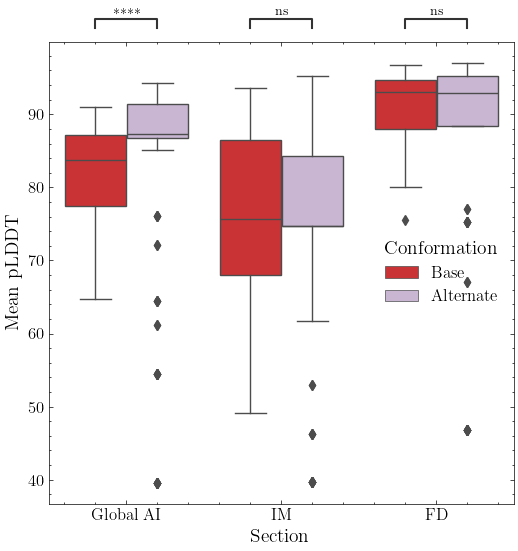

In [2518]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=both_conf_pld, x='Section', y='Mean pLDDT', ax = ax, hue='conformation_type', palette=colors, order=subcat_order)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Conformation', title_fontsize='14', fontsize='12')


# Annotate statistical significance
pairs = [[('Global AI', 'Base'), ('Global AI', 'Alternate')],
         [('IM', 'Base'), ('IM', 'Alternate')],
         [('FD', 'Base'), ('FD', 'Alternate')]]

annotator = Annotator(ax, pairs, data=both_conf_pld, x='Section', y='Mean pLDDT', order=subcat_order, hue='conformation_type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/both_confs_plddt.png', dpi=500, bbox_inches='tight')

### Both Confs PAE

In [2527]:
conf_one_pae = pd.merge(best_conf_one_grmsd[best_conf_one_grmsd['UniProt'].isin(fifteen_prots)], df_auto.rename(columns={'uniprot': 'UniProt'}), on='UniProt', how='left')
conf_two_pae = pd.merge(best_conf_two_grmsd[best_conf_one_grmsd['UniProt'].isin(fifteen_prots)], df_auto_cl, on=['UniProt', 'Cluster'], how='left')

conf_one_pae = conf_one_pae[['UniProt', 'PDB', 'conformation_type', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']] \
    .rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM vs FD', 'mean_pae_2_2': 'FD'})
conf_two_pae = conf_two_pae[['UniProt', 'PDB', 'Cluster', 'conformation_type', 'IM', 'IM vs FD', 'FD']]

conf_one_pae['conformation_type'] = 'Base'
conf_two_pae['conformation_type'] = 'Alternate'

both_conf_pae = pd.concat([conf_one_pae, conf_two_pae])

plot_both_pae = both_conf_pae.melt(id_vars=['UniProt', 'PDB', 'Cluster', 'conformation_type'], var_name='region', value_name='Mean PAE').astype({'Mean PAE': float})

/tmp/ipykernel_2466124/1716174945.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_Base vs. IM_Alternate: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.060e+02
FD_Base vs. FD_Alternate: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.900e+01
IM vs FD_Base vs. IM vs FD_Alternate: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.040e+02


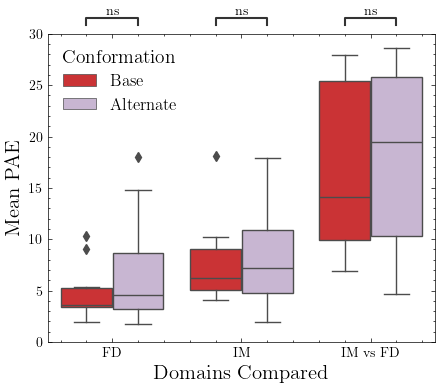

In [2534]:
region_order = ['FD', 'IM', 'IM vs FD']

f, ax = plt.subplots(figsize=(5, 4))
ax.set_ylim(0, 30)
sns.boxplot(data=plot_both_pae, x='region', y='Mean PAE', hue='conformation_type', order=region_order, ax=ax, palette=colors)
ax.set_xlabel('Domains Compared', fontsize=15)
ax.set_ylabel('Mean PAE', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(title='Conformation', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('FD', 'Base'), ('FD', 'Alternate')],
         [('IM', 'Base'), ('IM', 'Alternate')],
         [('IM vs FD', 'Base'), ('IM vs FD', 'Alternate')]]
annotator = Annotator(ax, pairs, data=plot_both_pae, x='region', y='Mean PAE', order=region_order, hue='conformation_type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/both_confs_pae.png', bbox_inches='tight', dpi=500)

## PDB Files with Partners vs No Partners

In [2810]:
nm = pd.read_csv('./project_pipeline/data/ai_nonstandard_monomers.tsv', sep='\t')
# dq = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv')
# inf = pd.read_csv('./project_pipeline/data/proteins_interface.tsv', sep='\t')

# Only experimental files without ptms, partners, etc.
no_p = nm[(nm['has_partner'] == False) & (nm['has_nstds'] == False)]

# Add interface residues
plot_p = no_p[['uniprot', 'pdb', 'complex_rmsd']].rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
best_p = plot_p.sort_values('complex_rmsd').groupby('UniProt').first().reset_index()
best_p['type'] = 'No partners/PTMs (AF2)'
best_p = pd.merge(best_p, clSub, how='left', on=['UniProt', 'PDB']).drop(columns=['Type', 'complex_rmsd']).rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})


best_nm = nm.sort_values('complex_rmsd').groupby('uniprot').first().reset_index()
best_nm = best_nm[~best_nm['uniprot'].isin(best_p['UniProt'].unique())]
best_nm['type'] = 'With partners/PTMs (AF2)'
best_nm = best_nm[['uniprot', 'pdb', 'complex_rmsd', 'type']].rename(columns={'uniprot': 'UniProt', 'pdb': 'PDB'})
best_nm = pd.merge(best_nm, clSub, how='left', on=['UniProt', 'PDB']).drop(columns=['Type', 'complex_rmsd']).rename(columns={imd1: im, fdd2: fd, imfdd1d2: imfd})

af3_all = af3_all.rename(columns={imd1: im, fdd2: fd})
best_p_af3 = af3_all[af3_all['UniProt'].isin(best_p['UniProt'].unique())]
best_p_af3['type'] = 'No partners/PTMs (AF3)'

best_nm_af3 = af3_all[~af3_all['UniProt'].isin(best_p['UniProt'].unique())]
best_nm_af3['type'] = 'With partners/PTMs (AF3)'

both = pd.concat([best_p, best_nm, best_p_af3, best_nm_af3])
# Melt the data
plot_both = pd.melt(both, id_vars=['UniProt', 'PDB', 'type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot_both['RMSD'] = plot_both['RMSD'].astype(float)

/tmp/ipykernel_2466124/838455255.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_p_af3['type'] = 'No partners/PTMs (AF3)'
/tmp/ipykernel_2466124/838455255.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_nm_af3['type'] = 'With partners/PTMs (AF3)'


In [2814]:
best_nm_af3['UniProt'].nunique(), best_p_af3['UniProt'].nunique()

(25, 98)

In [2815]:
best_nm['UniProt'].nunique(), best_p['UniProt'].nunique()

(27, 101)

/tmp/ipykernel_2466124/561265592.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$_{fd}^{im}$RMSD_No partners/PTMs (AF2) vs. $_{fd}^{im}$RMSD_With partners/PTMs (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:6.327e-02 U_stat=1.045e+03
$_{fd}$RMSD_No partners/PTMs (AF3) vs. $_{fd}$RMSD_With partners/PTMs (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:2.099e-01 U_stat=1.025e+03
$_{fd}^{im}$RMSD_No partners/PTMs (AF3) vs. $_{fd}^{im}$RMSD_With partners/PTMs (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:1.250e-03 U_stat=7.110e+02
$_{fd}$RMSD_No partners/PTMs (AF2) vs. $_{fd}$RMSD_With partners/PTMs (AF2): Mann-Whitney-Wilcoxon test two-sided, P_val:4.321e-01 U_stat=1.228e+03
$_{im}$RMSD_No partners/PTMs (AF3) vs. $_{im}$RMSD_With partners/PTMs (AF3): Mann-Whitney-Wilcoxon test two-sided, P_val:4.036e-03 U_stat=7.670e+02
gRMSD_No partners/PTMs (AF3) vs. gRMSD_With part

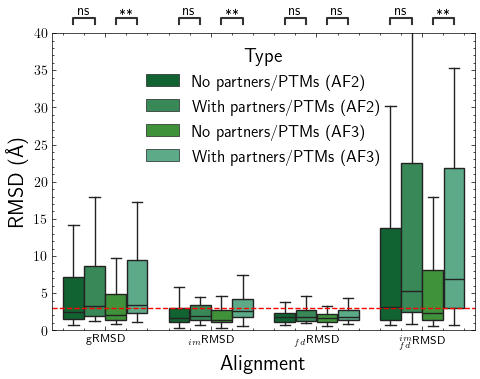

In [2933]:
subcat_order = ['gRMSD', im, fd, imfd]

# Now we plot the data
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=plot_both, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='type', order=subcat_order, fliersize=0)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=15)
ax.set_xlabel('Alignment', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.axhline(y=3, color='r', linestyle='--')
ax.legend(title='Type', fontsize=12, title_fontsize=14, loc='upper center')

# Add the annotations, comparing between structural alignment categories
pairs = [[('gRMSD', 'No partners/PTMs (AF2)'), ('gRMSD', 'With partners/PTMs (AF2)')],
         [(im, 'No partners/PTMs (AF2)'), (im, 'With partners/PTMs (AF2)')],
         [(fd, 'No partners/PTMs (AF2)'), (fd, 'With partners/PTMs (AF2)')],
         [(imfd, 'No partners/PTMs (AF2)'), (imfd, 'With partners/PTMs (AF2)')],
         [('gRMSD', 'No partners/PTMs (AF3)'), ('gRMSD', 'With partners/PTMs (AF3)')],
         [(im, 'No partners/PTMs (AF3)'), (im, 'With partners/PTMs (AF3)')],
         [(fd, 'No partners/PTMs (AF3)'), (fd, 'With partners/PTMs (AF3)')],
         [(imfd, 'No partners/PTMs (AF3)'), (imfd, 'With partners/PTMs (AF3)')]]
annotator = Annotator(ax, pairs, data=plot_both, x='Alignment', y='RMSD', order=subcat_order, hue='type', palette=colors)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/paper/partner_ptms.png', dpi=500, bbox_inches='tight')

## Full Paper figures

### Figure 6

/tmp/ipykernel_2466124/3766957037.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_yticklabels(ax[0][0].get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Uniform Clusters vs. IM_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:4.828e-44 U_stat=2.424e+05
Global AI_AI Uniform Clusters vs. Global AI_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.858e-47 U_stat=2.455e+05
FD_AI Uniform Clusters vs. FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:9.556e-53 U_stat=2.506e+05


/tmp/ipykernel_2466124/3766957037.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][1].set_yticklabels(ax[0][1].get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM_AI Uniform Clusters vs. IM_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:5.054e-40 U_stat=7.939e+04
FD_AI Uniform Clusters vs. FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.593e-51 U_stat=6.843e+04
IM vs FD_AI Uniform Clusters vs. IM vs FD_AI Local Clusters: Mann-Whitney-Wilcoxon test two-sided, P_val:2.200e-24 U_stat=9.770e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI Uniform Clusters (Best gRMSD) vs. AI Uniform Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-sided, P_val:7.016e-03 U_stat=4.700e+01
AI Local Clusters (Best gRMSD) vs. AI Local Clusters (Best pLDDT): Mann-Whitney-Wilcoxon test two-side

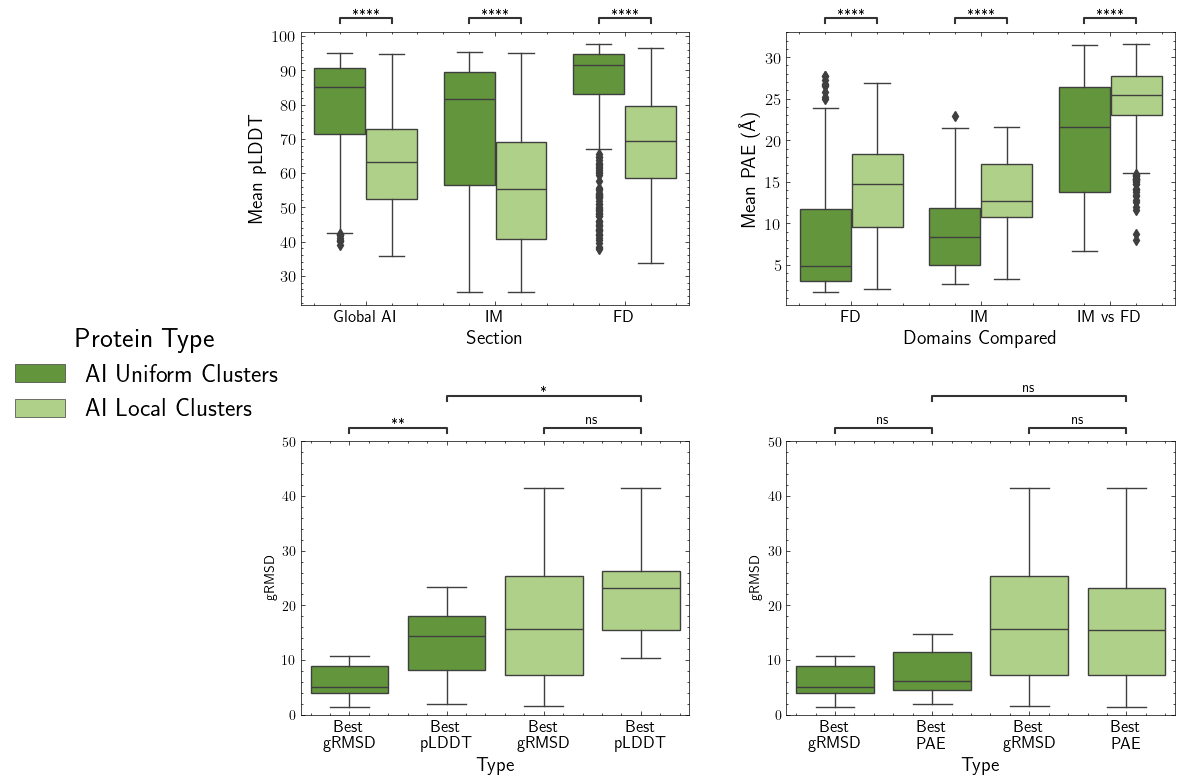

In [2890]:
# AI full depth vs AI cluster
subcat_order = ['Global AI', 'IM', 'FD']

region_order = ['FD', 'IM', 'IM vs FD']


fig, ax = plt.subplots(2, 2, figsize=(12, 8))





sns.boxplot(data=fif_p, x='Section', y='Mean pLDDT', ax = ax[0][0], hue='type', palette=colors, order=subcat_order)
ax[0][0].set_ylabel('Mean pLDDT', fontsize=14)
ax[0][0].set_xlabel('Section', fontsize=14)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), fontsize=12)
ax[0][0].set_yticklabels(ax[0][0].get_yticklabels(), fontsize=12)
handles, labels = ax[0][0].get_legend_handles_labels()
# labels = ['AI Full Depth', 'AI Cluster \n (w/ Uniform \n Clstrs.)']
ax[0][0].legend(title='Protein Type', title_fontsize='20', fontsize='18', bbox_to_anchor=(0, 0))


# Annotate statistical significance
pairs = [[('Global AI', 'AI Uniform Clusters'), ('Global AI', 'AI Local Clusters')],
         [('IM', 'AI Uniform Clusters'), ('IM', 'AI Local Clusters')],
         [('FD', 'AI Uniform Clusters'), ('FD', 'AI Local Clusters')]]

type_order = ['AI Cluster (w/ Uniform Clstrs.)', 'AI Full Depth']
annotator = Annotator(ax[0][0], pairs, data=fif_p, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

sns.boxplot(data=fif_pae_plot, x='region', y='mean_pae', hue='type', order=region_order, ax=ax[0][1], palette=colors)
ax[0][1].set_xlabel('Domains Compared', fontsize=14)
ax[0][1].set_ylabel('Mean PAE (Å)', fontsize=14)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), fontsize=12)
ax[0][1].set_yticklabels(ax[0][1].get_yticklabels(), fontsize=12)
ax[0][1].get_legend().remove()

# Annotate statistical significance

pairs = [[('FD', 'AI Uniform Clusters'), ('FD', 'AI Local Clusters')],
         [('IM', 'AI Uniform Clusters'), ('IM', 'AI Local Clusters')],
         [('IM vs FD', 'AI Uniform Clusters'), ('IM vs FD', 'AI Local Clusters')]]
annotator = Annotator(ax[0][1], pairs, data=fif_pae_plot, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/paper/15_prots_cluster_pae_plddt.png', dpi=500, bbox_inches='tight')

ax[1][0].set_ylim(0, 50)
ax[1][1].set_ylim(0, 50)

sns.boxplot(data=compare_rmsds, x='type', y='gRMSD', ax=ax[1][0], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[1][0].set_xlabel('Type', fontsize=14)
ax[1][0].set_xticklabels(['Best \ngRMSD', 'Best \npLDDT', 'Best \ngRMSD', 'Best \npLDDT'], fontsize=12)
ax[1][0].get_legend().remove()

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best pLDDT)'),
         ('AI Uniform Clusters (Best pLDDT)', 'AI Local Clusters (Best pLDDT)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best pLDDT)')]
annotator = Annotator(ax[1][0], pairs, data=compare_rmsds, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()

sns.boxplot(data=compare_pae, x='type', y='gRMSD', ax=ax[1][1], hue='subtype', palette=clust_colors, dodge=False, fliersize=0)
ax[1][1].set_xlabel('Type', fontsize=14)
ax[1][1].set_xticklabels(['Best \ngRMSD', 'Best \nPAE', 'Best \ngRMSD', 'Best \nPAE'], fontsize=12)
ax[1][1].get_legend().remove()

pairs = [('AI Uniform Clusters (Best gRMSD)', 'AI Uniform Clusters (Best PAE)'),
         ('AI Uniform Clusters (Best PAE)', 'AI Local Clusters (Best PAE)'),
         ('AI Local Clusters (Best gRMSD)', 'AI Local Clusters (Best PAE)')]
annotator = Annotator(ax[1][1], pairs, data=compare_pae, x='type', y='gRMSD')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
_, corrected_results = annotator.apply_and_annotate()


plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.savefig('./project_pipeline/data/figures/paper/fig6_draft.png', dpi=500, bbox_inches='tight')